# <center> Модель предсказания отказов компрессора высокого давления

## Импорт библиотек

In [1]:
#Работа с данными
import pandas as pd
import numpy as np
import math

In [2]:
#Визуализация данных
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [100]:
#Подготовка данных, машинное обучение
#from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

import xgboost as xgb

In [4]:
#Метрики качества модели
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Импорт выборки данных

In [5]:
#Заголовки столбцов параметров
headers = pd.read_excel(r'Описание параметров.XLSX')
headers.head()

field                                description
0       B3_A_SHDT   M6e_A_SHDTIME_RT Таймер останова тек.зн.
1      B3_A_start      M6e_A_F2RENDSEQT Таймер пуска тек.зн.
2     B3_A_TTXD_H  M6e_A_TTXD_H_Предупр-ная уставка Т за ТНД
3    B3_A_TTXD_HH   M6e_A_TTXD_HH_Аварийная уставка Т за ТНД
4  B3_A20AS1_ENUM                 АПР: Состояние АПР (1 ст.)

In [6]:
#Выборка данных
#data = pd.read_excel(r'D:/users/PMurlykin/JupyterProjects/DAR_task/KVD.XLSX')
data = pd.read_excel(r'KVD.XLSX')
data.head()

DateTime   B3_P_C5    B3_P_C6  B3_P_inKVD1  B3_P_inKVD2  \
0 2019-05-17 09:20:00  5.168750  13.500001     5.082812    13.240625   
1 2019-05-17 09:30:00  5.159375  13.500001     5.082812    13.240625   
2 2019-05-17 09:40:00  5.148125  13.471874     5.082812    13.214062   
3 2019-05-17 09:50:00  5.136875  13.445312     5.056250    13.187499   
4 2019-05-17 10:00:00  5.148125  13.446875     5.056250    13.187499   

   B3_PDIT561  B3_PDIT571  B3_PIT561  B3_PIT563  B3_PIT571  ...  \
0   26.105747  104.541084   5.106489  13.912589  13.340695  ...   
1   26.266880  104.962227   5.090353  13.912589  13.340695  ...   
2   26.058136  104.321358   5.074903  13.885215  13.314511  ...   
3   25.900665  104.586861   5.074903  13.859031  13.288327  ...   
4   26.208286  104.641792   5.074903  13.858436  13.288922  ...   

   B3_Tg_outKVD2  B3_TIT561  B3_TIT571  B3_E_BCL   B3_E_Cm  B3_E_MCL  \
0     108.139999  35.343327  41.644539  0.673587  4.394132  1.696910   
1     108.139999  35.041199  41.598763  0.673587  4.394336  1.697093   
2     108.139999  34.940491  41.642250  0.673815  4.398725  1.699382   
3     108.139999  34.940491  41.740669  0.675830  4.403408  1.699291   
4     108.139999  35.041199  41.939804  0.673815  4.394619  1.697002   

   B3_E_Ras1  B3_E_Ras2     B3_evNKVD  y  
0   2.728573   1.678707  10080.102539  0  
1   2.728573   1.678707  10080.102539  0  
2   2.734113   1.678707  10080.102539  0  
3   2.734113   1.678707  10080.102539  0  
4   2.734113   1.678707  10080.102539  0  

[5 rows x 26 columns]

## Исследование данных

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13958 entries, 0 to 13957
Data columns (total 26 columns):
DateTime         13958 non-null datetime64[ns]
B3_P_C5          13955 non-null float64
B3_P_C6          13955 non-null float64
B3_P_inKVD1      13951 non-null float64
B3_P_inKVD2      13955 non-null float64
B3_PDIT561       13955 non-null float64
B3_PDIT571       13955 non-null float64
B3_PIT561        13955 non-null float64
B3_PIT563        13955 non-null float64
B3_PIT571        13955 non-null float64
B3_PIT573        13955 non-null float64
B3_T_C5          13955 non-null float64
B3_T_C6          13955 non-null float64
B3_Tg_inKVD1     13955 non-null float64
B3_Tg_inKVD2     13955 non-null float64
B3_Tg_outKVD1    13955 non-null float64
B3_Tg_outKVD2    13955 non-null float64
B3_TIT561        13955 non-null float64
B3_TIT571        13955 non-null float64
B3_E_BCL         13955 non-null float64
B3_E_Cm          13955 non-null float64
B3_E_MCL         13955 non-null float64
B3_E

Вывод:
1. DataFrame состоит из временного ряда, целевой целочисленной переменной и группы показателей (фич) - рациональных чисел.
2. Фичи содержат пропуски значений.
3. По первым значениям выборки видно, что показания датчиков снимаются с интервалом 10 минут.

Гипотеза:
1. Проверим непрерывность временного ряда.

In [8]:
data.describe()

B3_P_C5       B3_P_C6   B3_P_inKVD1   B3_P_inKVD2    B3_PDIT561  \
count  13955.000000  13955.000000  13951.000000  13955.000000  13955.000000   
mean       5.323898     14.039342      5.226354     13.815826     31.678404   
std        0.064942      0.703086      0.061968      0.678627      3.192738   
min        5.053750      7.142188      4.946875      6.974999     19.880066   
25%        5.273750     13.798438      5.181250     13.585938     29.255209   
50%        5.338750     14.160937      5.240625     13.931251     31.445183   
75%        5.362500     14.514062      5.267187     14.267187     33.609524   
max        6.006250     15.390626      5.662500     15.048437     53.747768   

         B3_PDIT571     B3_PIT561     B3_PIT563     B3_PIT571     B3_PIT573  \
count  13955.000000  13955.000000  13955.000000  13955.000000  13955.000000   
mean     104.633832      5.248177     14.423204     13.921211     25.204768   
std       12.838785      0.064652      0.672769      0.683766      1.838717   
min       72.387276      4.967441      7.670566      7.052850      9.180190   
25%       93.865875      5.197471     14.186931     13.670382     24.697871   
50%      104.669258      5.265793     14.523758     14.031013     25.611525   
75%      113.847565      5.290856     14.876655     14.381530     26.250000   
max      180.503555      5.673666     15.155162     15.205745     27.092756   

       ...  B3_Tg_outKVD2     B3_TIT561     B3_TIT571      B3_E_BCL  \
count  ...   13955.000000  13955.000000  13955.000000  13955.000000   
mean   ...     104.909567     31.575105     28.629974      0.802719   
std    ...       5.442119     10.129655      7.191234      0.074379   
min    ...      72.489998      6.139849     10.294117      0.183864   
25%    ...     102.410004     26.264591     23.080795      0.794392   
50%    ...     104.839996     31.090637     27.018768      0.819890   
75%    ...     108.480003     34.211491     33.429848      0.844060   
max    ...     116.099998    118.540863    111.221100      0.943626   

            B3_E_Cm      B3_E_MCL     B3_E_Ras1     B3_E_Ras2     B3_evNKVD  \
count  13955.000000  13955.000000  13955.000000  13955.000000  13955.000000   
mean       4.802717      1.715054      2.748148      1.808568   9929.570477   
std        0.343508      0.118338      0.120577      0.074821    163.214755   
min        1.786967      0.481804      1.493082      1.184330   8435.300781   
25%        4.713647      1.687480      2.719898      1.800132   9838.818359   
50%        4.918274      1.730144      2.763374      1.826215   9986.375000   
75%        4.992021      1.783703      2.817961      1.850003  10050.109375   
max        5.181017      1.864271      2.903966      1.953301  10104.472656   

                  y  
count  13958.000000  
mean       0.025075  
std        0.156359  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 25 columns]

In [9]:
data.shape

(13958, 26)

In [10]:
#Распределение значениц в столбце показателе отказов
data['y'].value_counts(normalize=True)*100

0    97.492477
1     2.507523
Name: y, dtype: float64

Вывод:
1. Целевой столбец содержит несбалансированные классы. Записей в состоянии отказа значительно меньше, чем в рабочем состоянии.

### Проверка непрерывности временного ряда

In [39]:
#Копирование исходных данных в новый DataFrame для выполнения преобразований
norm_data = data.copy()

In [40]:
#Добавим новый столбец - признак прерывания временного ряда
norm_data['ts_interrupting'] = 0

DateTime_idx = norm_data.columns.get_loc('DateTime') #Индекс столбца с временным рядом
ts_interrupting_idx = norm_data.columns.get_loc('ts_interrupting') #Индекс нового столбца с признаком прерывания временного ряда

In [ ]:
'''
#Цикл отрабатывает очень долго, далее использован метод diff

#Если разница между последовательными записями более 10 минут, то добавляем признак прерывания временного ряда
for row in range(1, len(norm_data)):
    if (norm_data.values[row][DateTime_idx] - norm_data.values[row-1][DateTime_idx]).seconds > 600:
        norm_data.loc[row, 'ts_interrupting'] = 1
    
#(norm_data.values[1][1] - norm_data.values[0][1])/norm_data.values[0][1]
'''

In [41]:
DateTime_diff = norm_data.DateTime.diff()
DateTime_diff.value_counts()

0 days 00:10:00     13931
0 days 05:30:00         2
0 days 02:40:00         2
0 days 08:50:00         1
0 days 01:40:00         1
0 days 03:20:00         1
0 days 08:40:00         1
0 days 02:30:00         1
0 days 03:10:00         1
0 days 05:10:00         1
0 days 05:50:00         1
0 days 07:10:00         1
1 days 22:30:00         1
0 days 02:20:00         1
0 days 21:20:00         1
0 days 07:30:00         1
16 days 09:40:00        1
0 days 03:00:00         1
0 days 03:40:00         1
0 days 14:10:00         1
0 days 07:00:00         1
0 days 18:50:00         1
2 days 13:50:00         1
0 days 03:30:00         1
0 days 11:10:00         1
Name: DateTime, dtype: int64

Вывод:
1. Большая часть измерений произведена с интервалом в 10 минут.
2. Во временном ряду есть прерывания.

Проставим признак прерывания временного ряда и исключим столбец временного ряда для улучшения визуализации данных.

In [42]:
norm_data['ts_interrupting'].loc[norm_data.DateTime.diff() != '0 days 00:10:00'] = 1
norm_data['ts_interrupting'].value_counts()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0    13931
1       27
Name: ts_interrupting, dtype: int64

In [43]:
norm_data.drop('DateTime', axis=1, inplace=True)

### Зависимость отказов КВД от показаний каждого из датчиков

In [44]:
not_features = ['ts_interrupting', 'y'] #Столбцы, не являющиеся атрибутами
features = norm_data.loc[:, ~norm_data.columns.isin(not_features)].columns #Столбцы - показания датчиков
print(features)

Index(['B3_P_C5', 'B3_P_C6', 'B3_P_inKVD1', 'B3_P_inKVD2', 'B3_PDIT561',
       'B3_PDIT571', 'B3_PIT561', 'B3_PIT563', 'B3_PIT571', 'B3_PIT573',
       'B3_T_C5', 'B3_T_C6', 'B3_Tg_inKVD1', 'B3_Tg_inKVD2', 'B3_Tg_outKVD1',
       'B3_Tg_outKVD2', 'B3_TIT561', 'B3_TIT571', 'B3_E_BCL', 'B3_E_Cm',
       'B3_E_MCL', 'B3_E_Ras1', 'B3_E_Ras2', 'B3_evNKVD'],
      dtype='object')


In [45]:
for col in features:
    desc_idx = headers.loc[headers['field']==col].index[0]
    desc = headers.values[desc_idx][1]
    print(col, '-', desc)

B3_P_C5 - Давление в сепараторе С-5.X
B3_P_C6 - Давление в сепараторе С-6.X
B3_P_inKVD1 - Давление на входе 1 ст. КВД
B3_P_inKVD2 - Давление на входе 2 ст. КВД
B3_PDIT561 - PDIT561 Перепад на диафрагме 1 ст. КВД
B3_PDIT571 - PDIT571 Перепад на диафрагме 2 ст. КВД
B3_PIT561 - PIT561 Давление газа перед измерительной диафрагмой  1 ст. КВД
B3_PIT563 - PIT563 Давление на выходе 1 ст. КВД
B3_PIT571 - PIT571 Давление газа перед измерительной диафрагмой  2 ст. КВД
B3_PIT573 - PIT573 Давление на выходе 2 ст. КВД
B3_T_C5 - Температура в сепараторе С-5.X
B3_T_C6 - Температура в сепараторе С-6.X
B3_Tg_inKVD1 - Температура на входе 1 ст. КВД
B3_Tg_inKVD2 - Температура на входе 2 ст. КВД
B3_Tg_outKVD1 - Температура на выходе 1 ст. КВД
B3_Tg_outKVD2 - Температура на выходе 2 ст. КВД
B3_TIT561 - TIT561 Температура на диафрагме 1 ст. КВД
B3_TIT571 - TIT571 Температура на диафрагме 2 ст. КВД
B3_E_BCL - Степень сжатия 2 ст. Км
B3_E_Cm - Степень сжатия
B3_E_MCL - Степень сжатия 1 ст. Км
B3_E_Ras1 - Степе

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


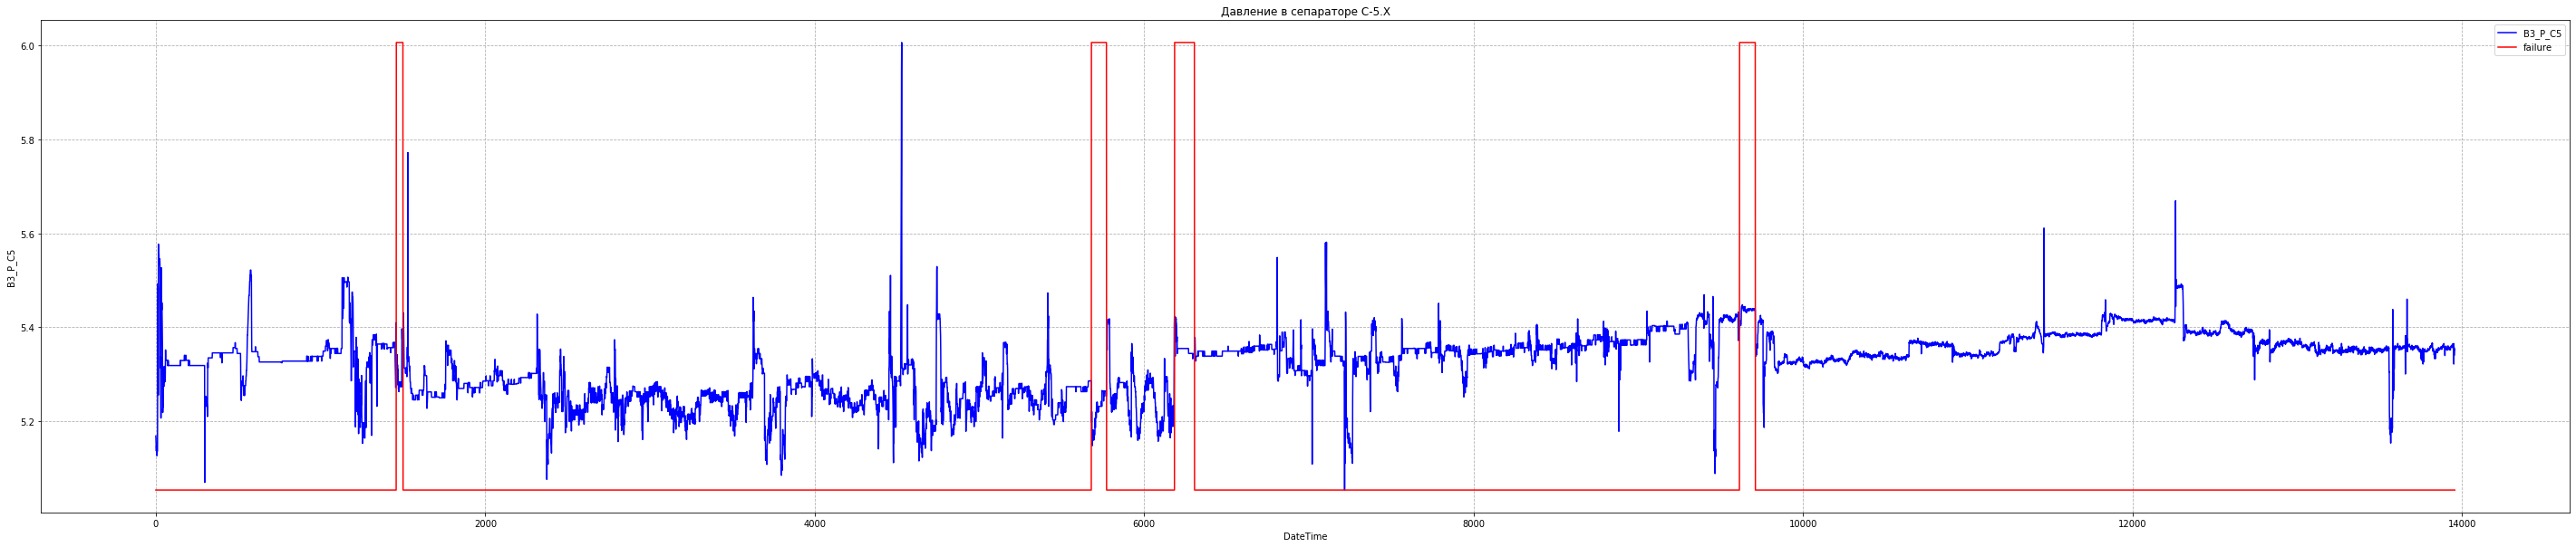

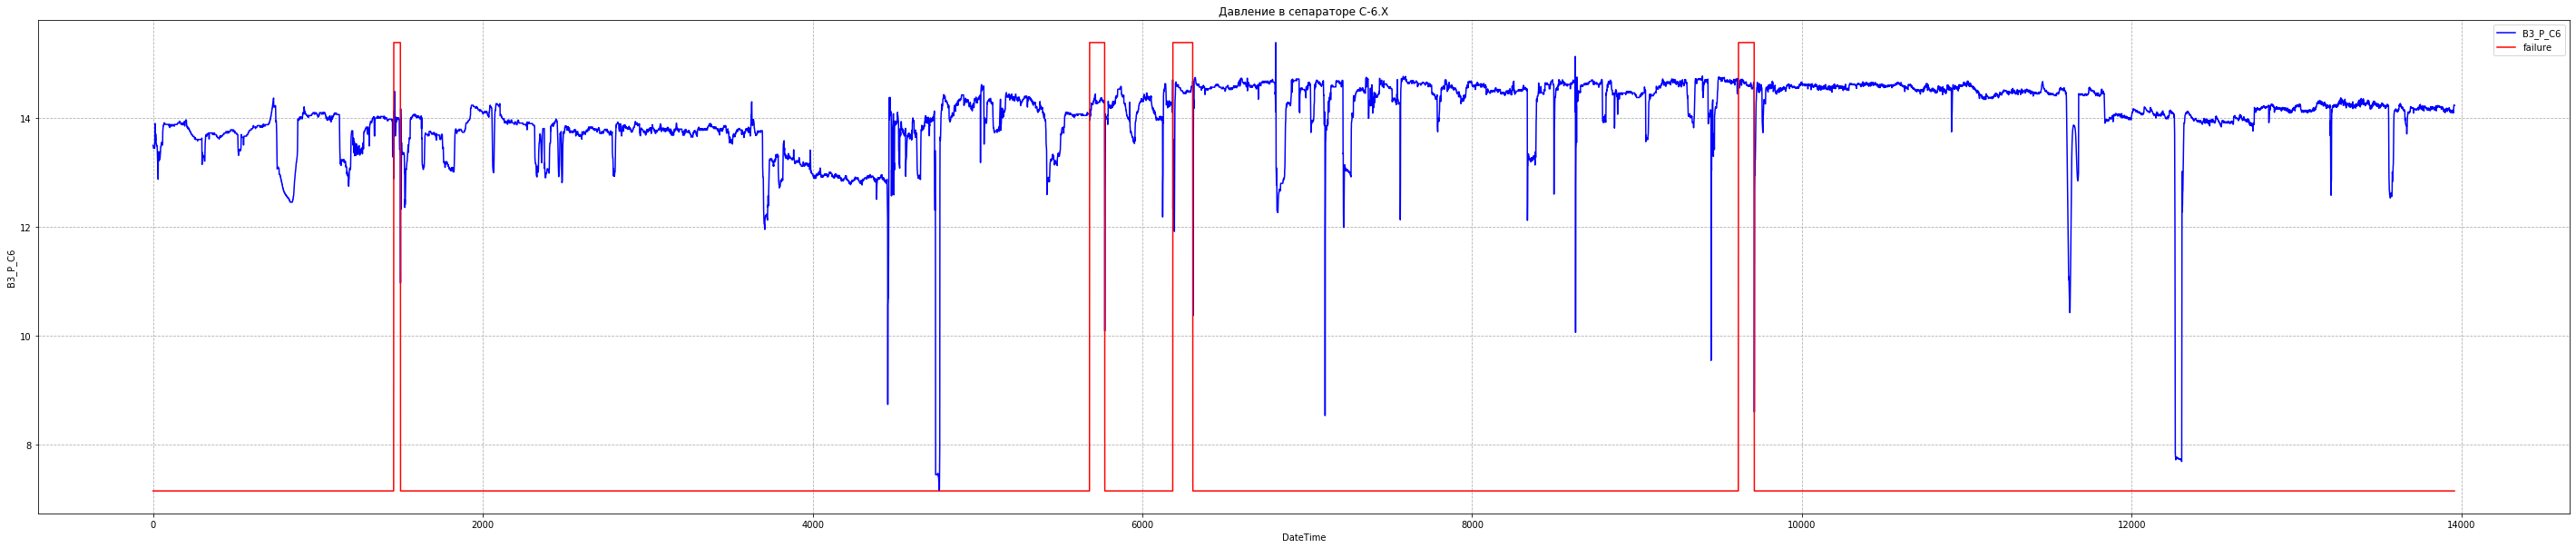

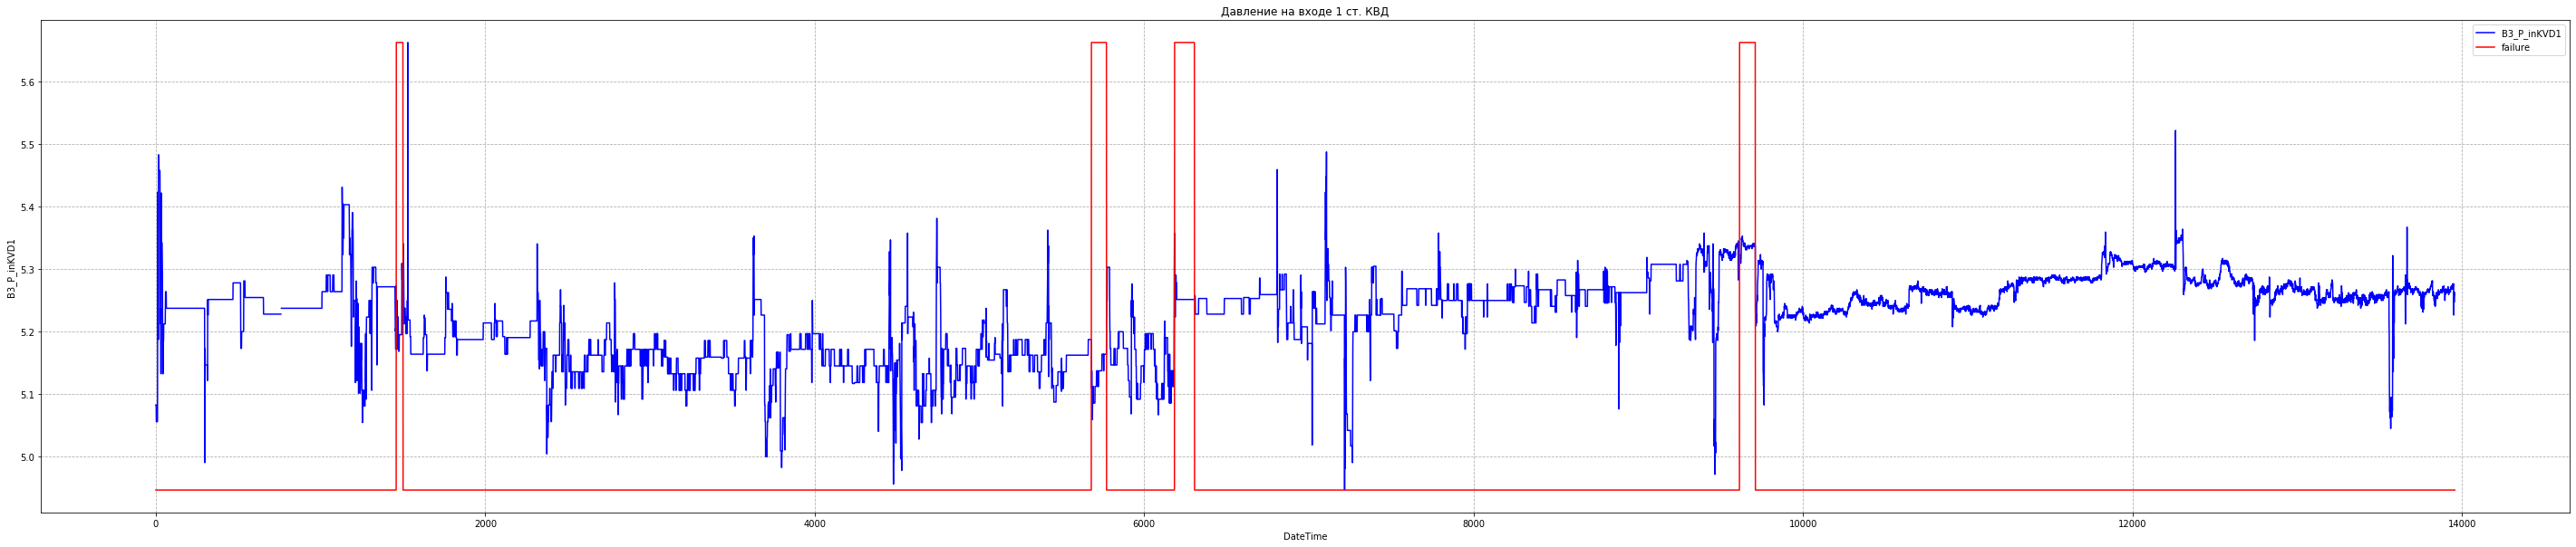

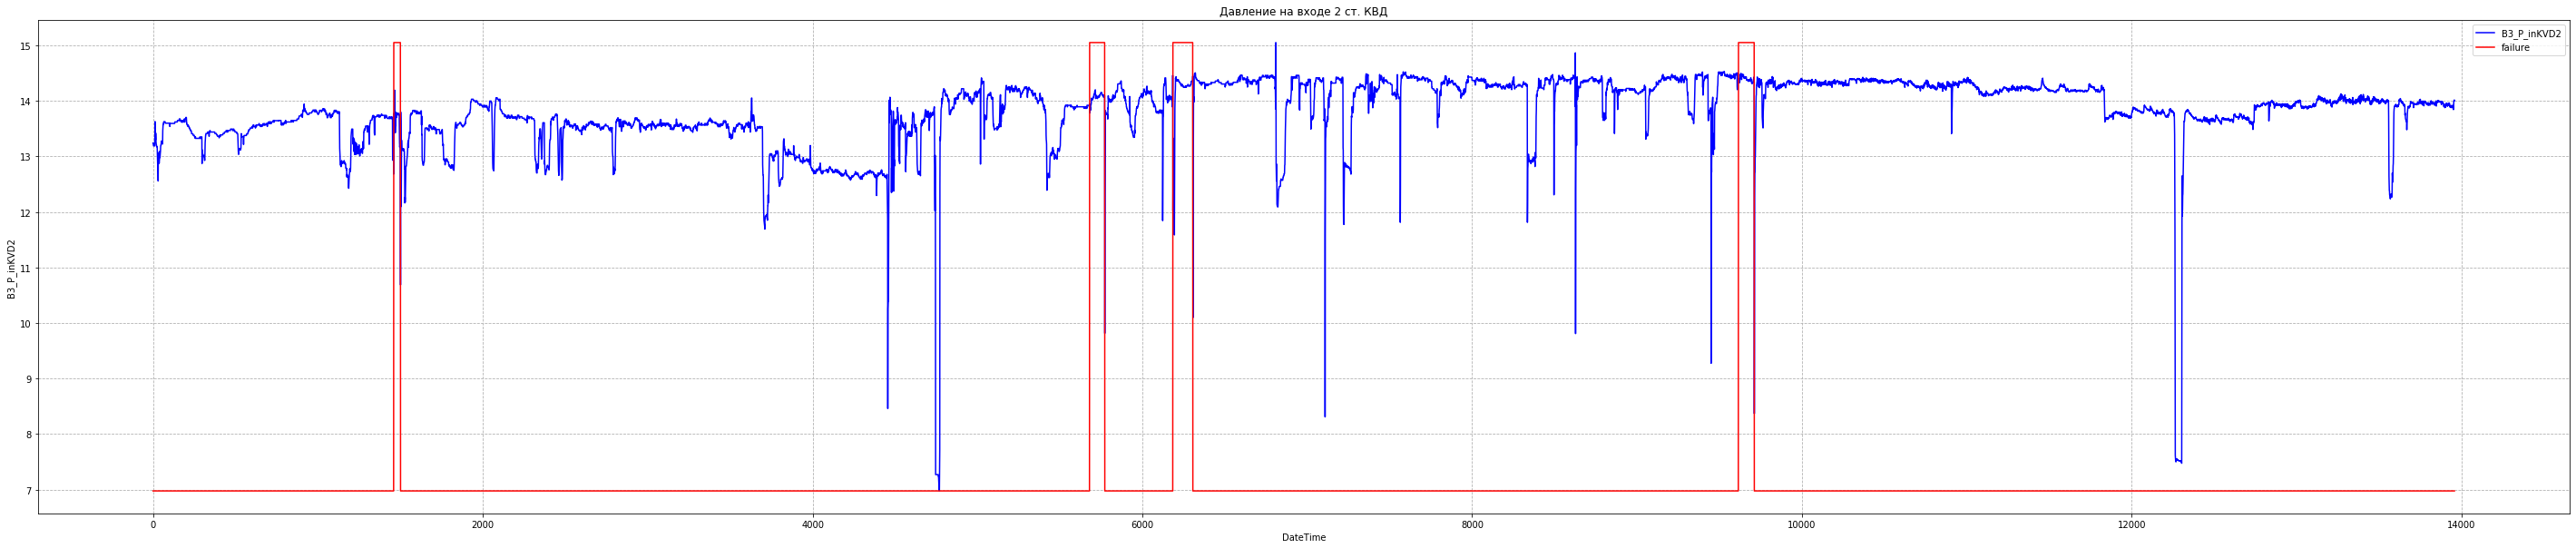

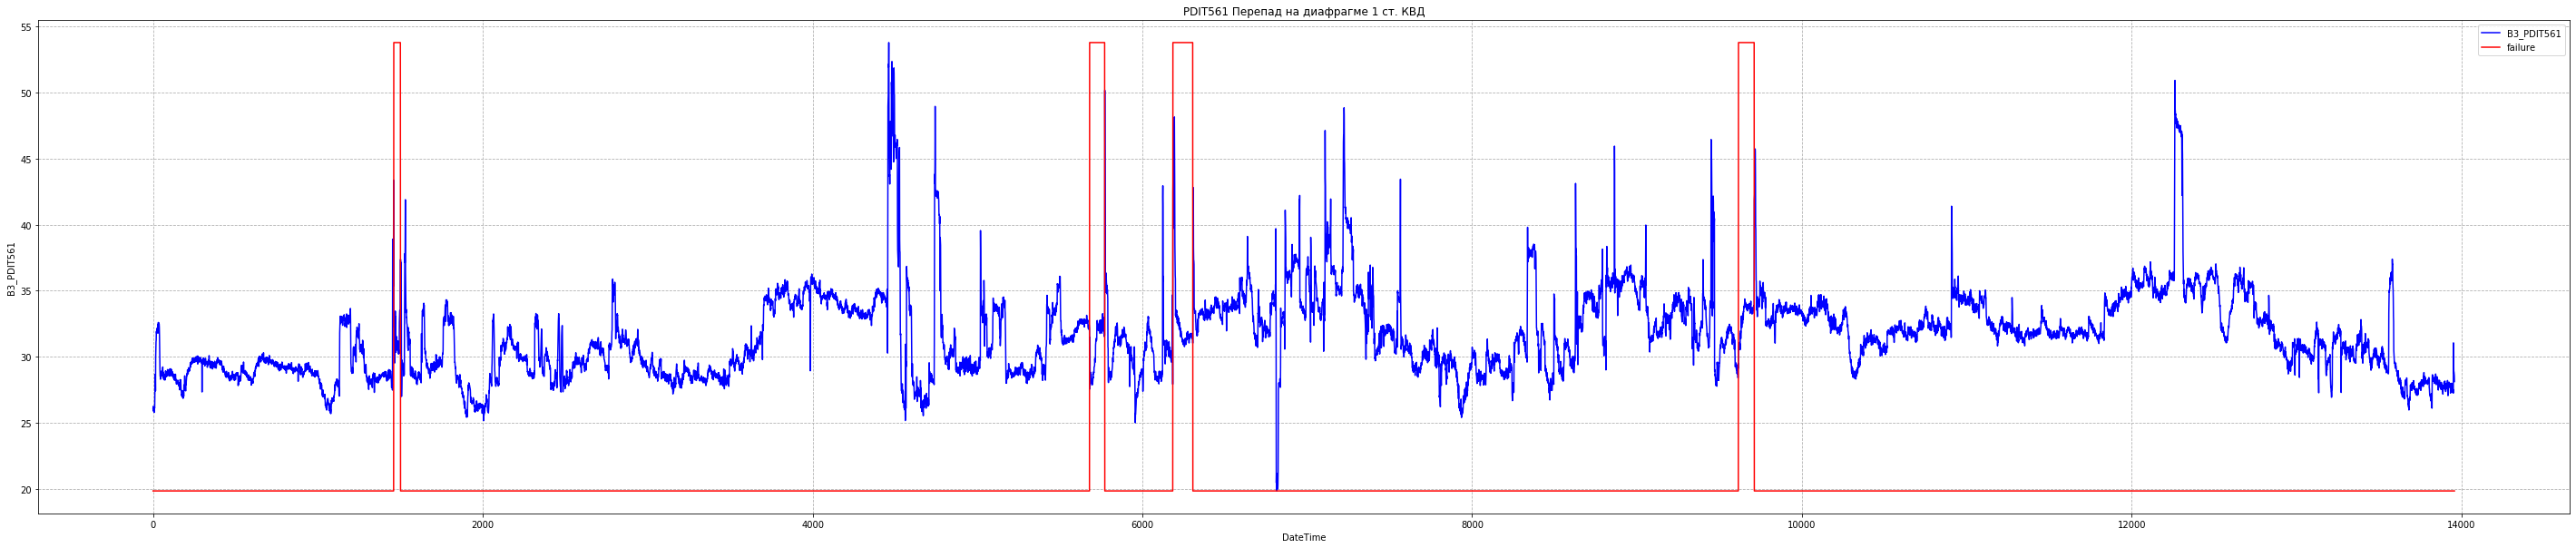

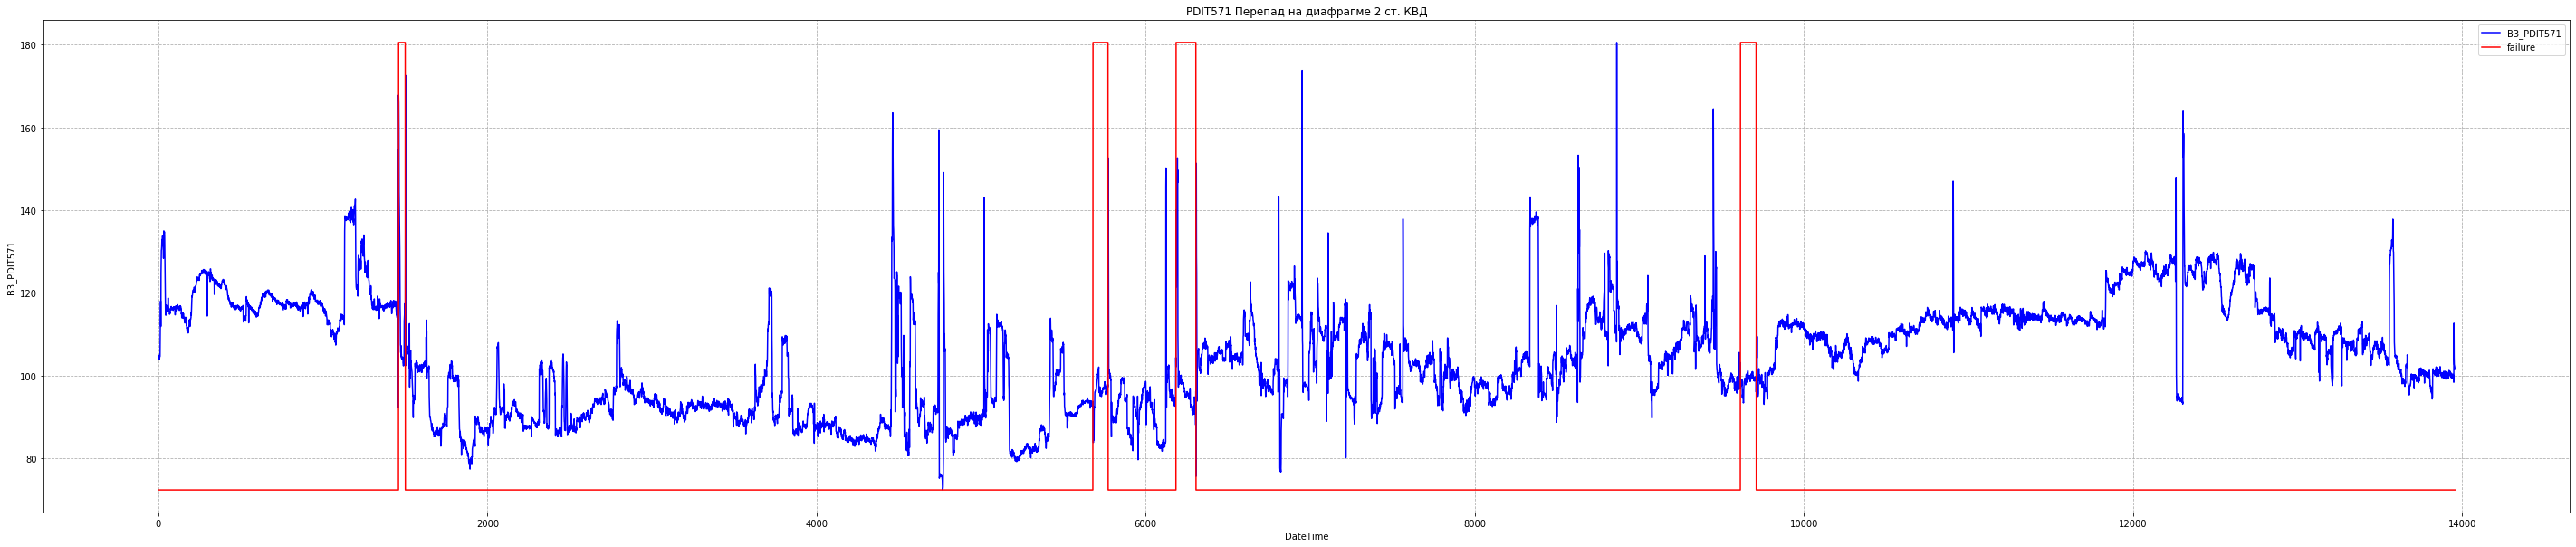

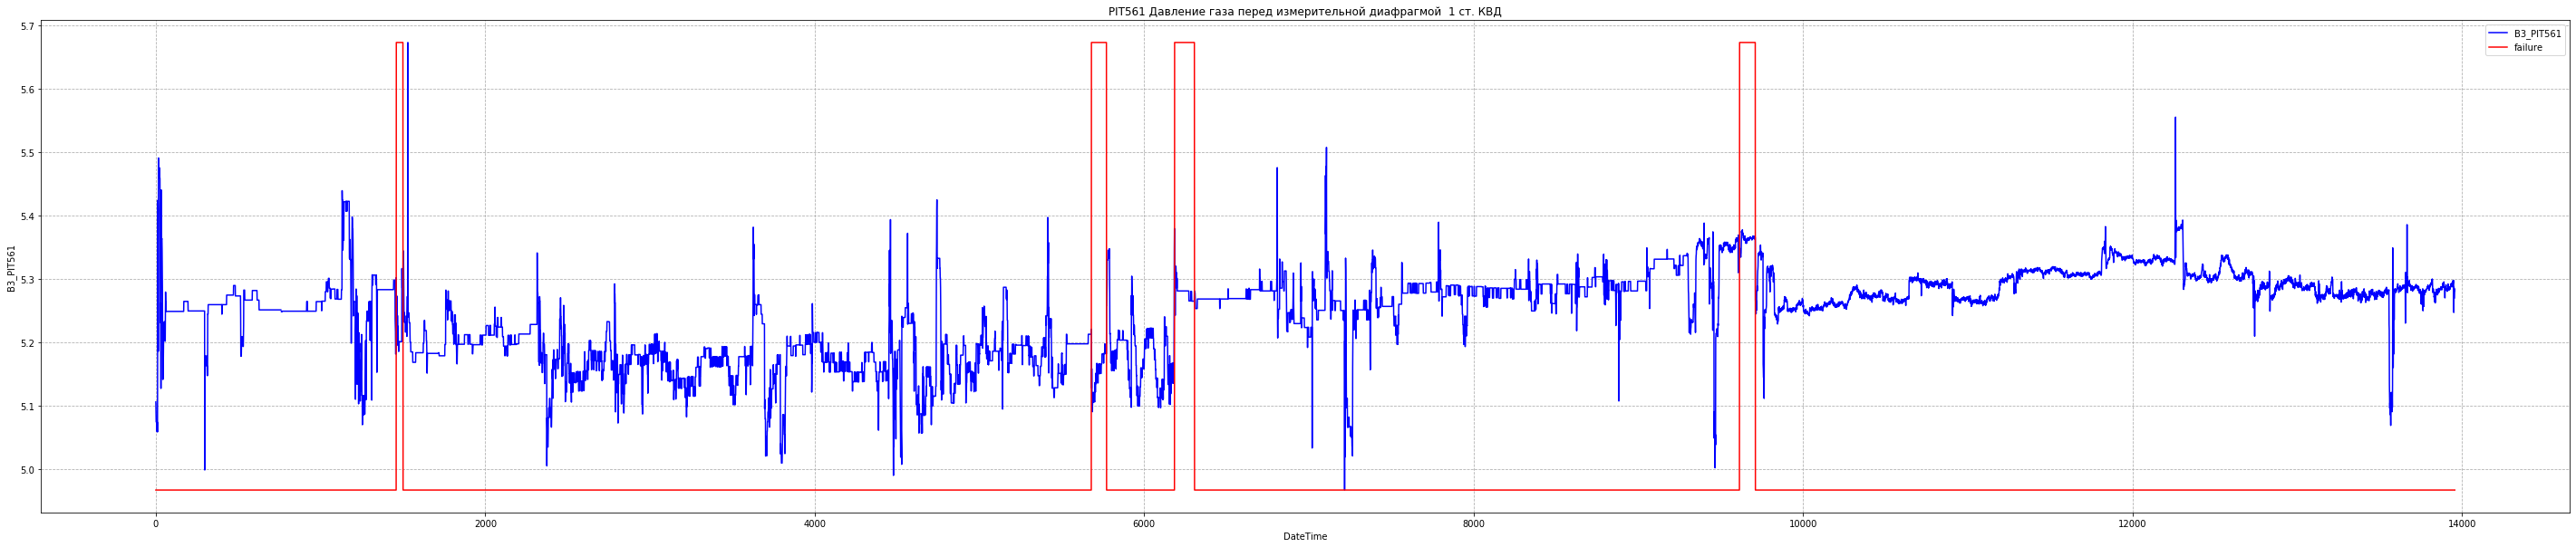

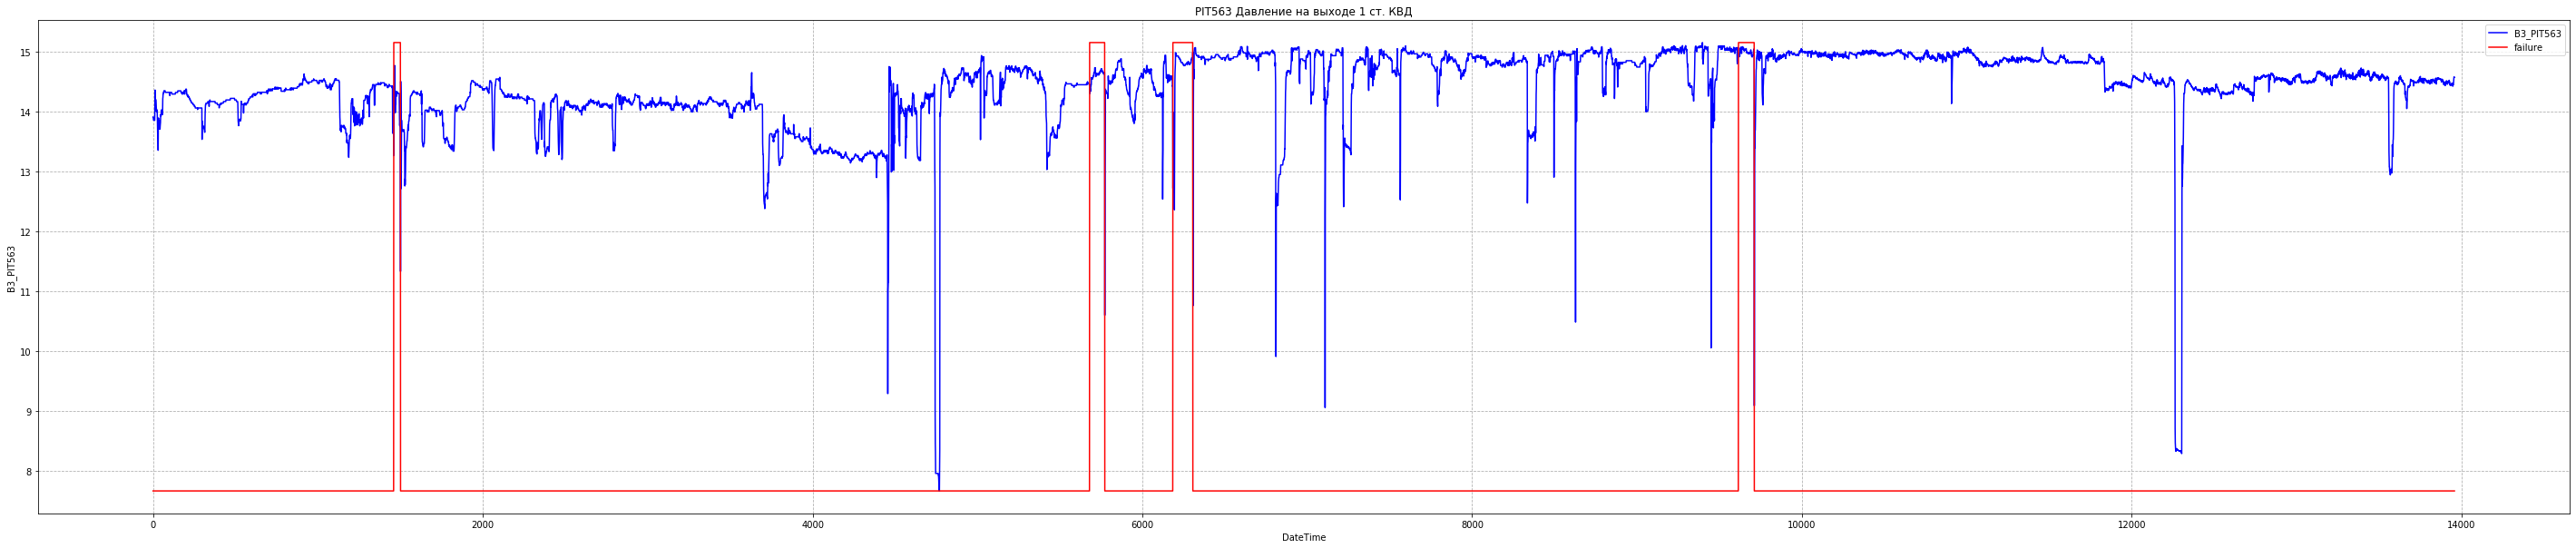

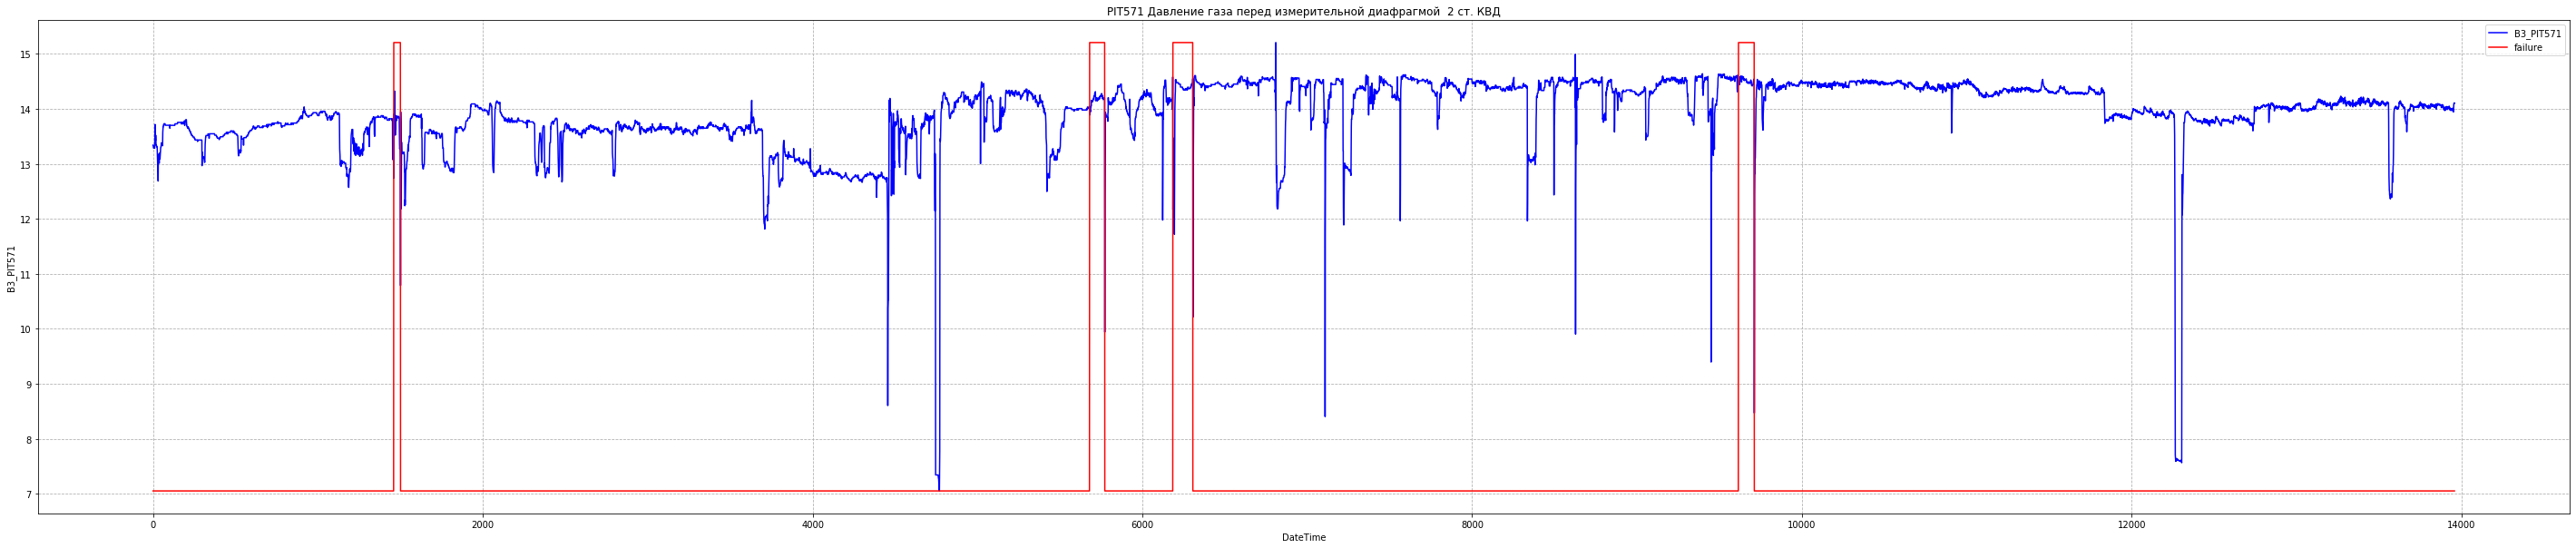

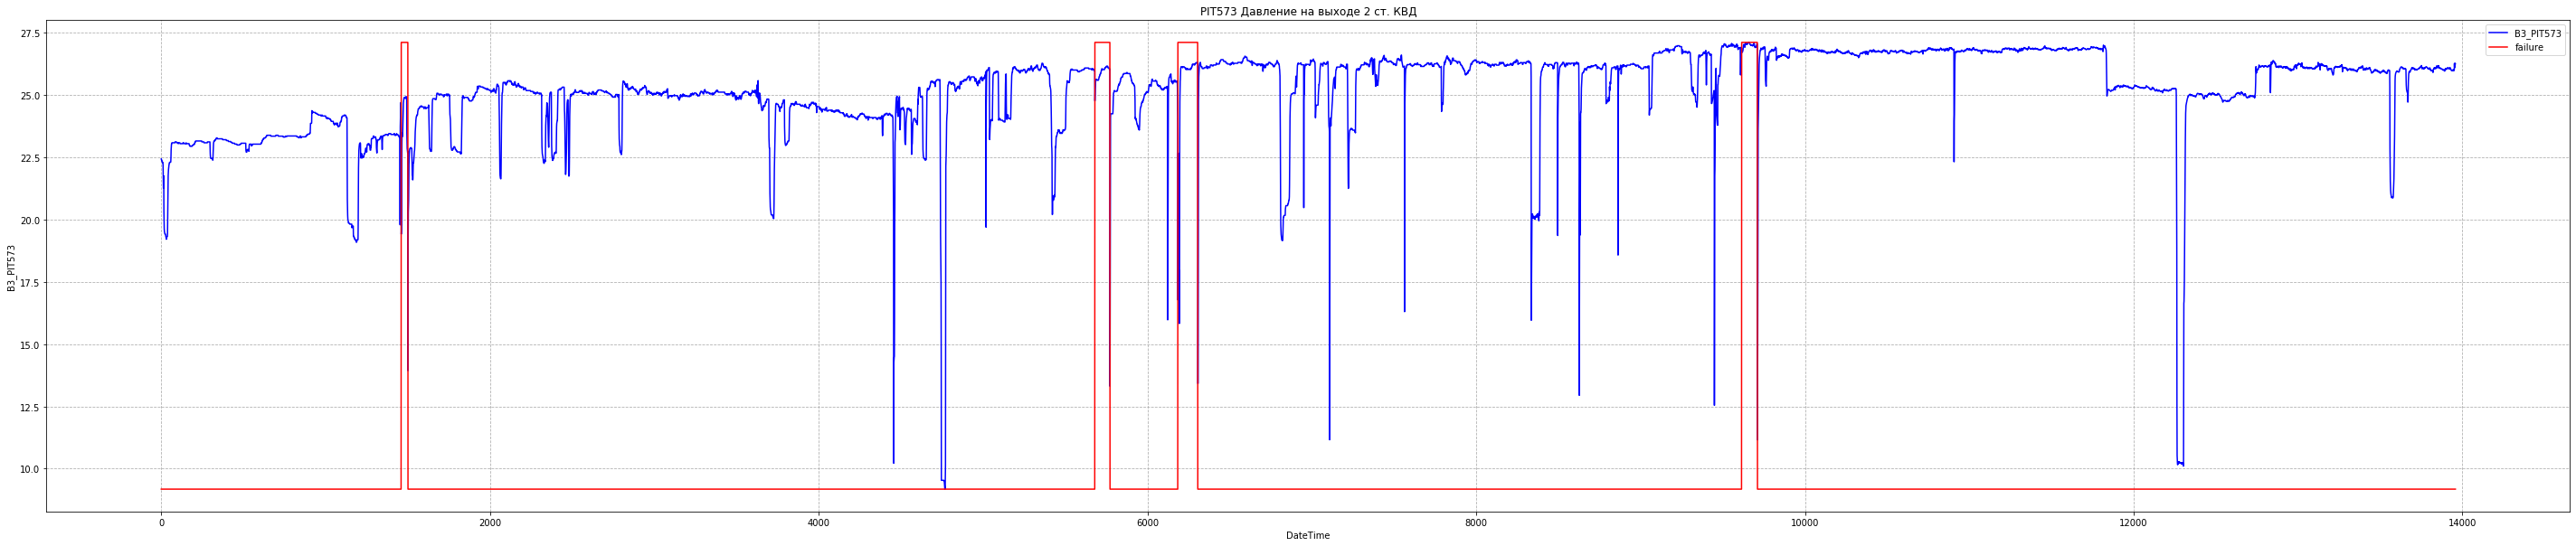

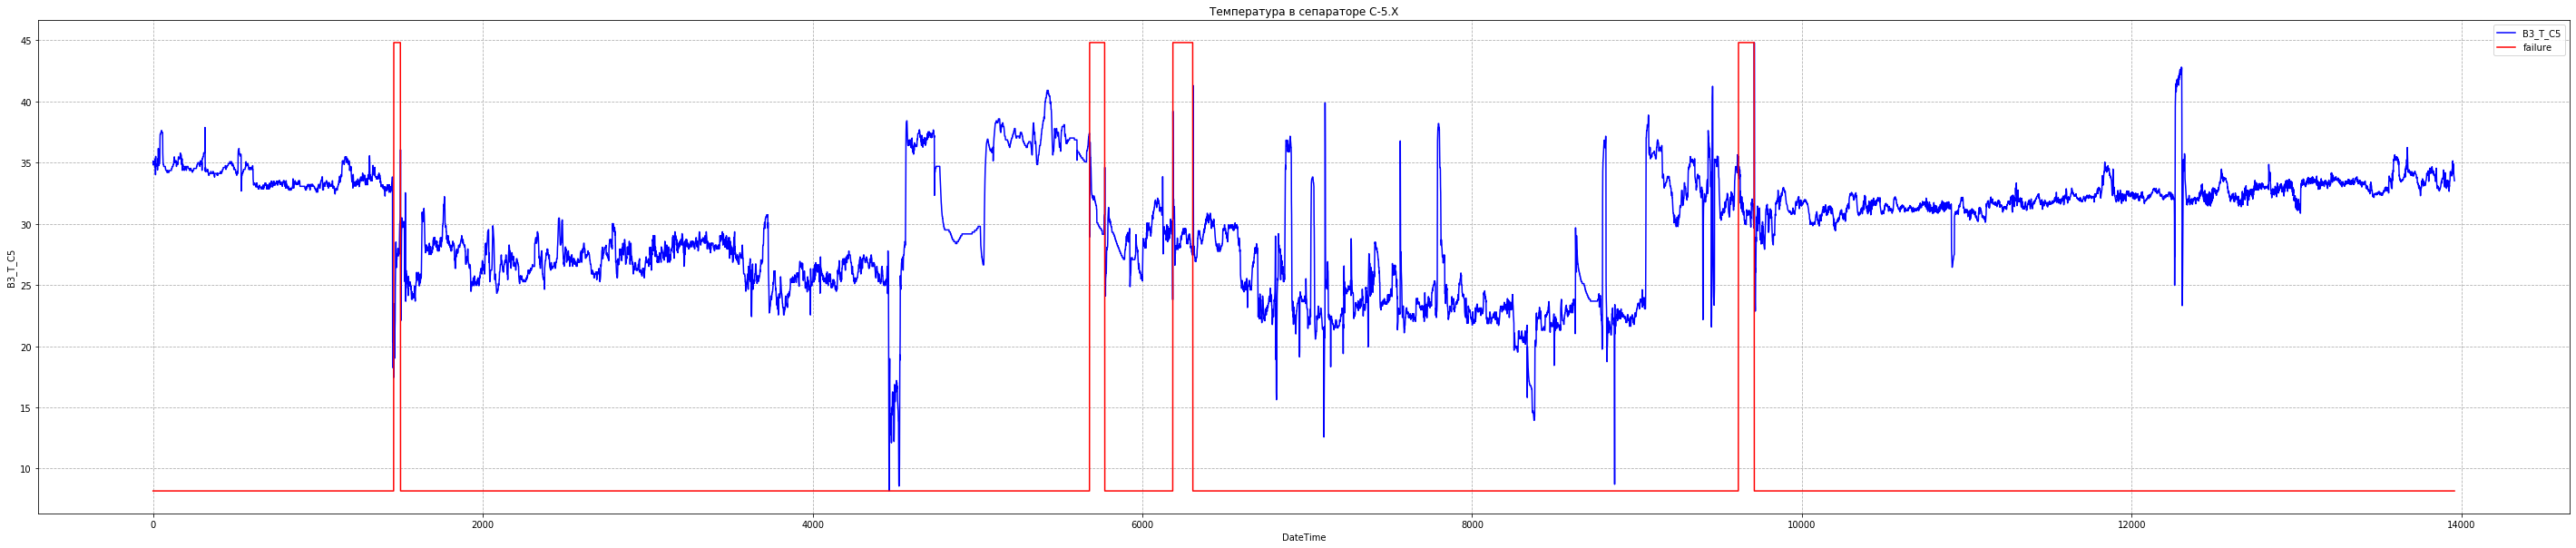

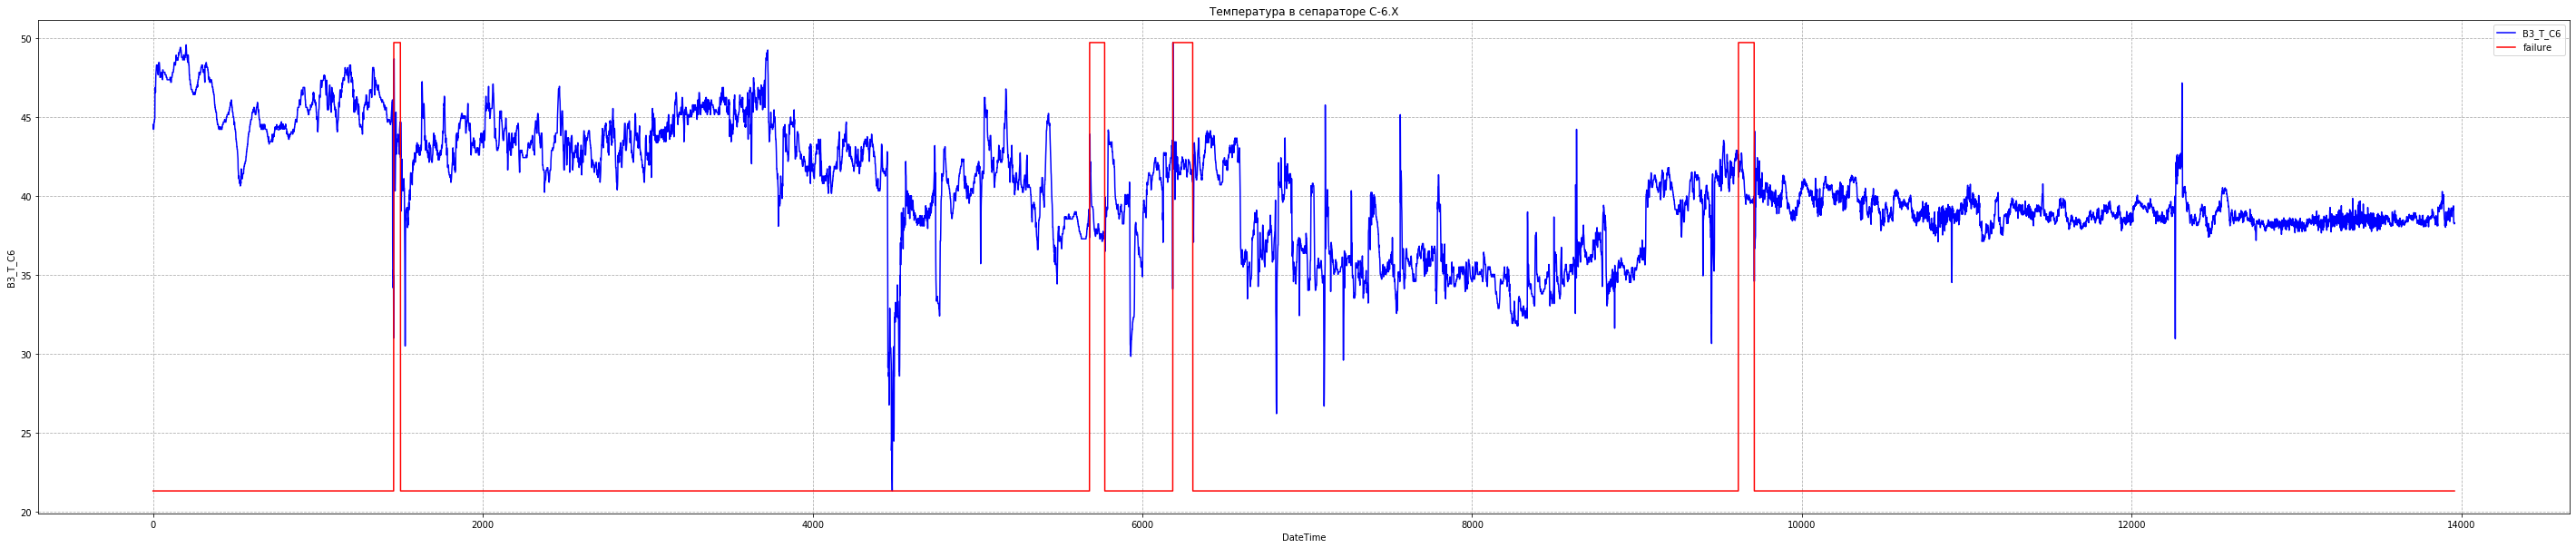

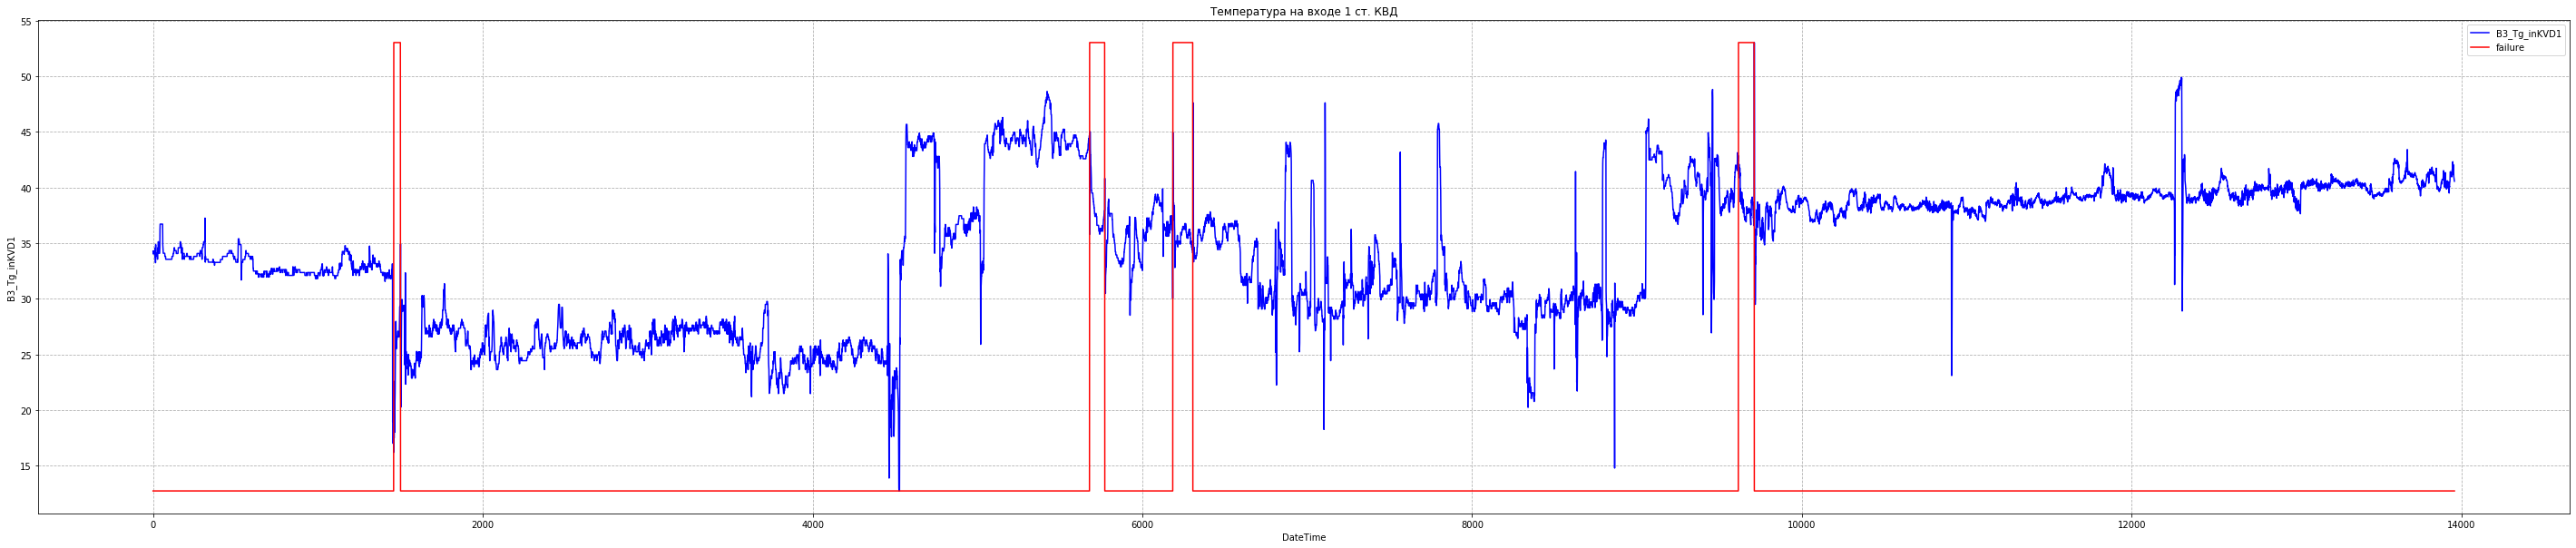

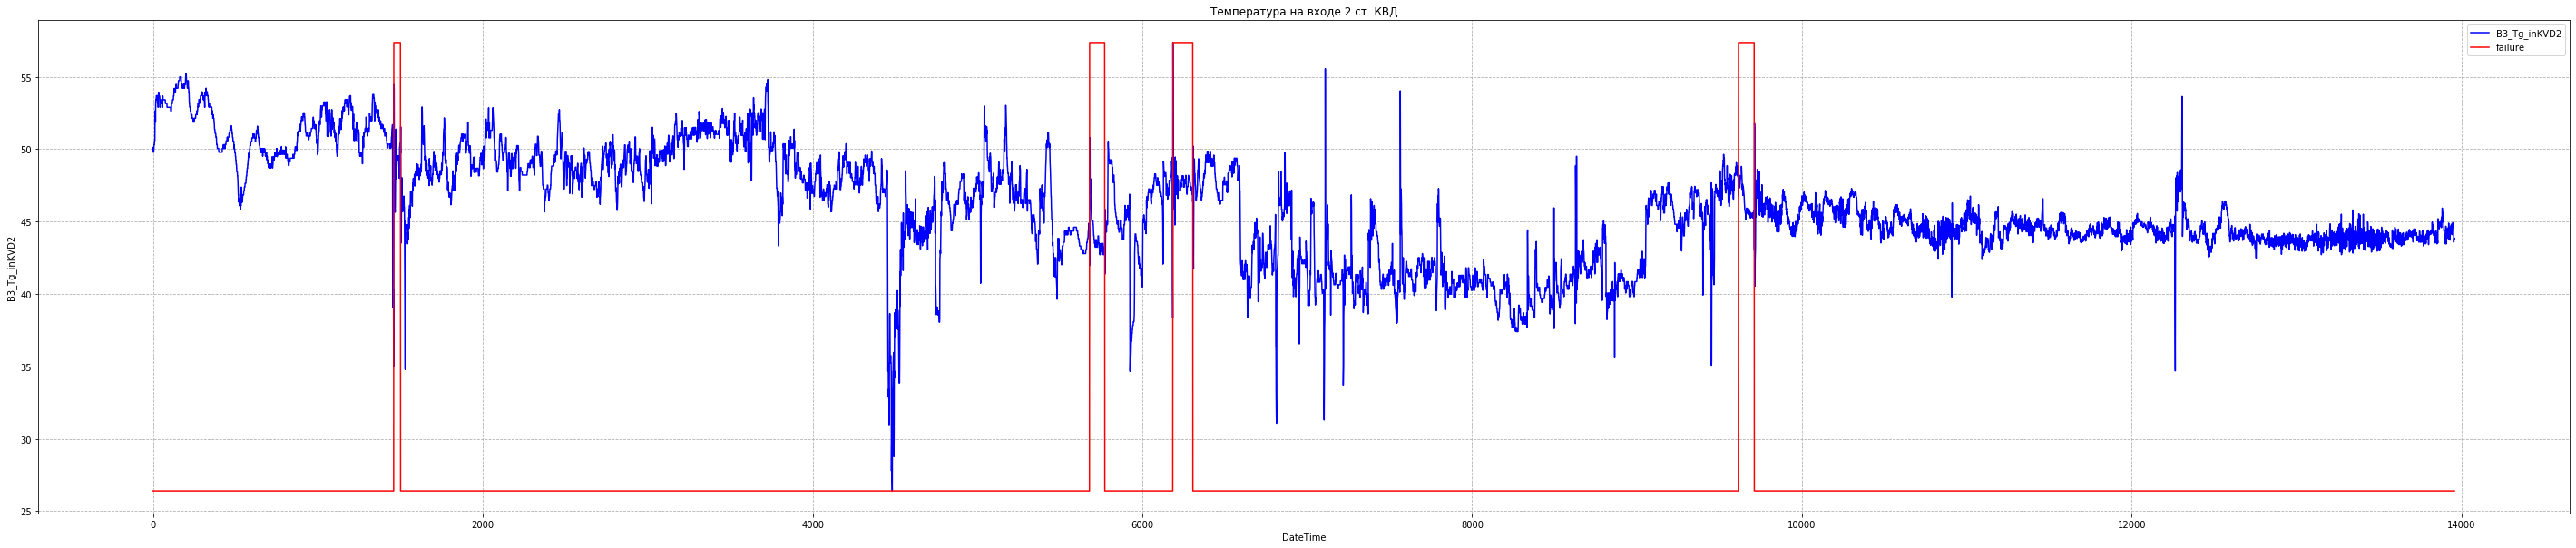

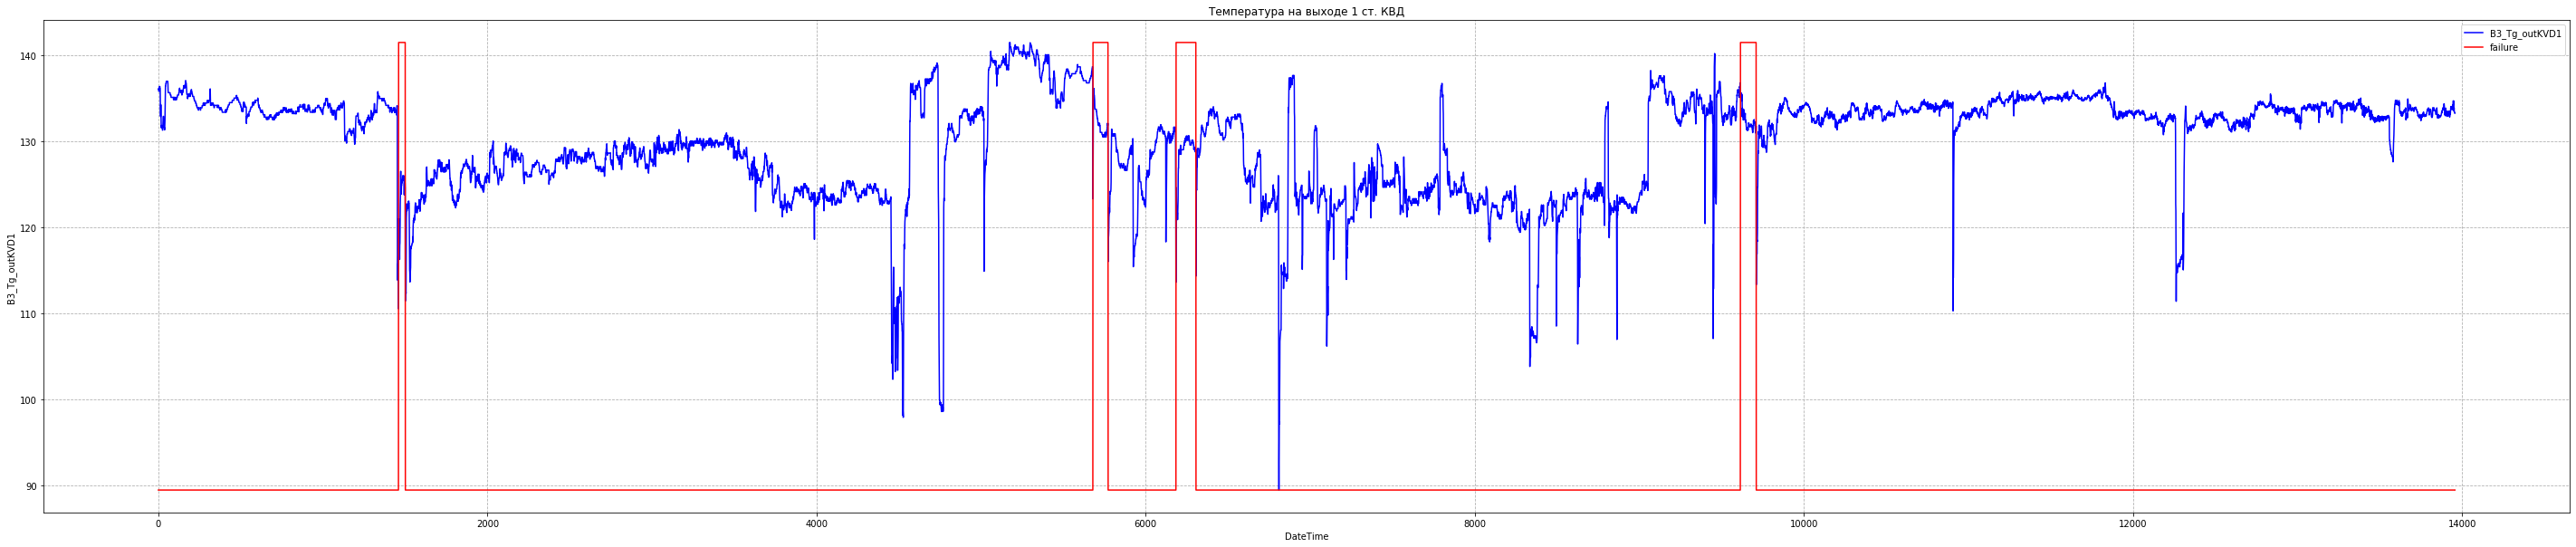

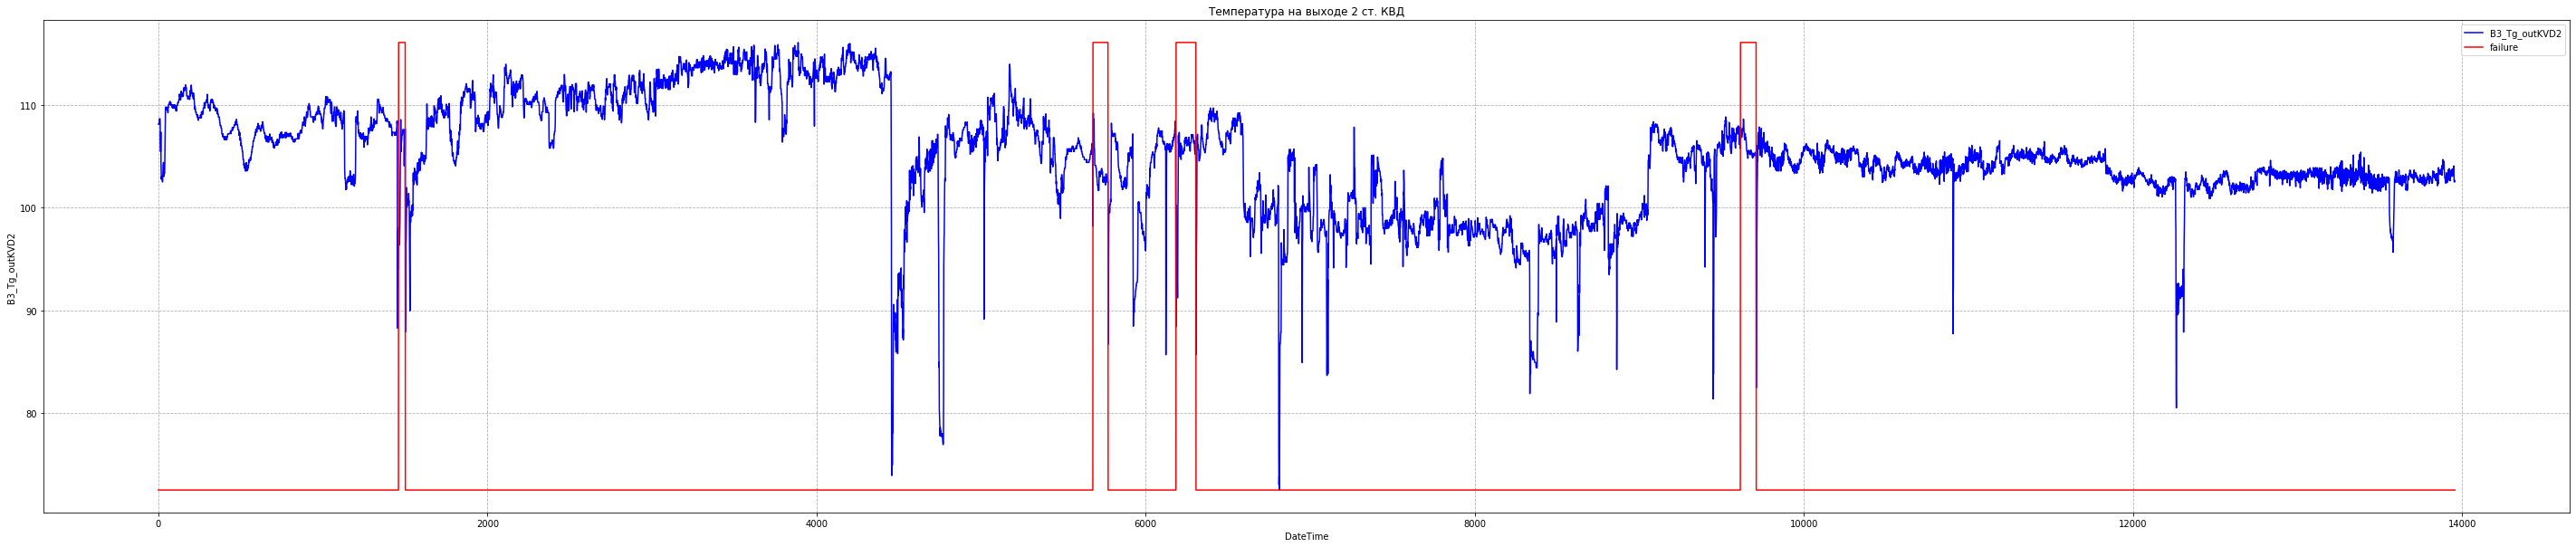

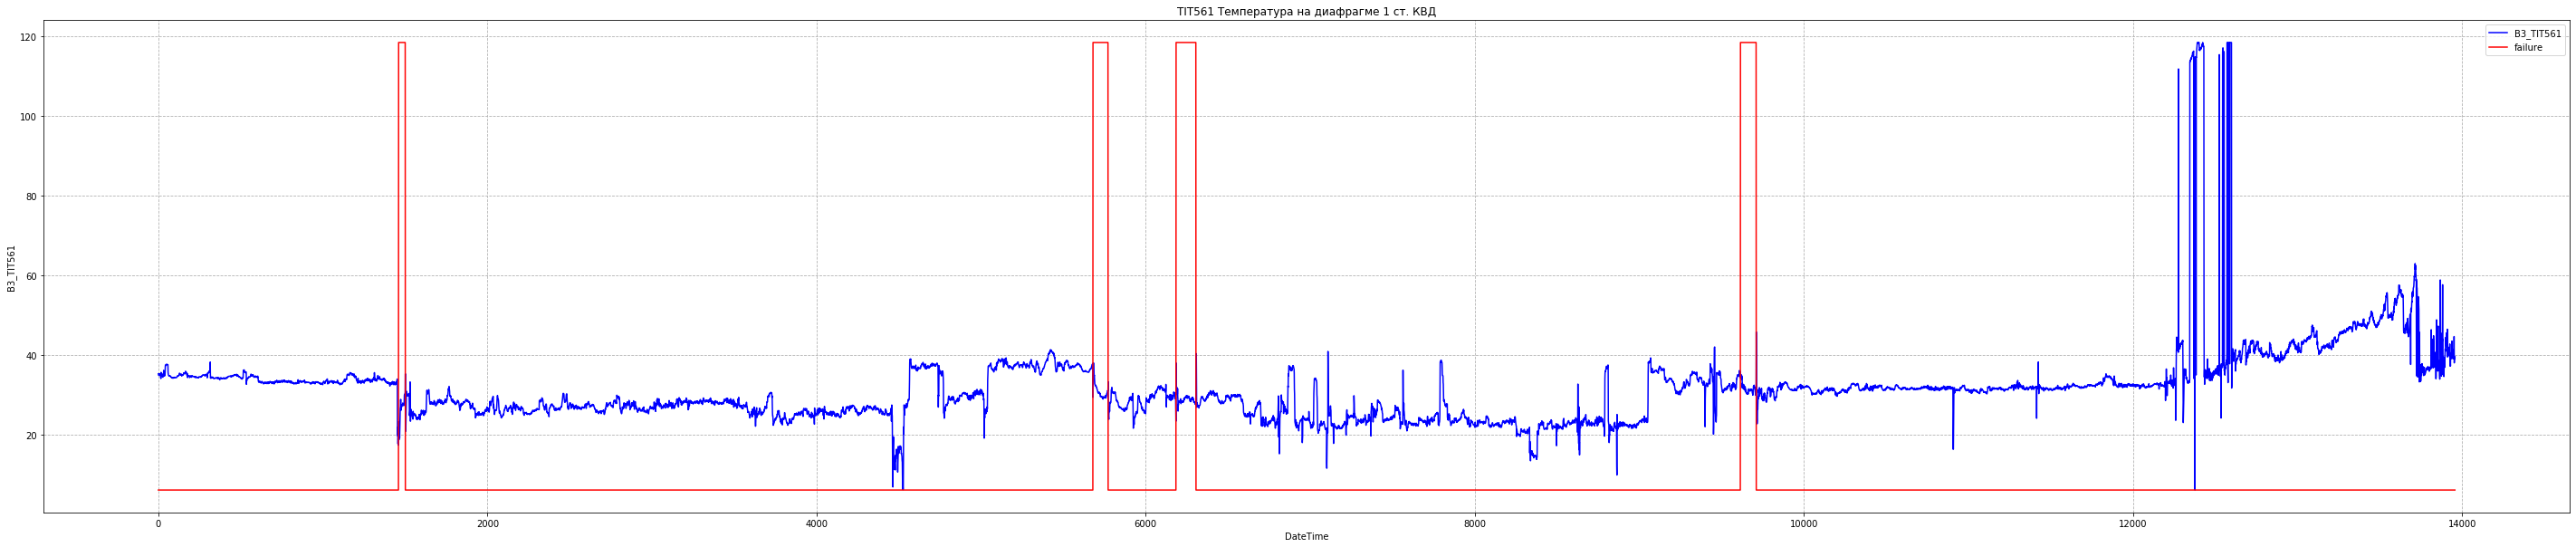

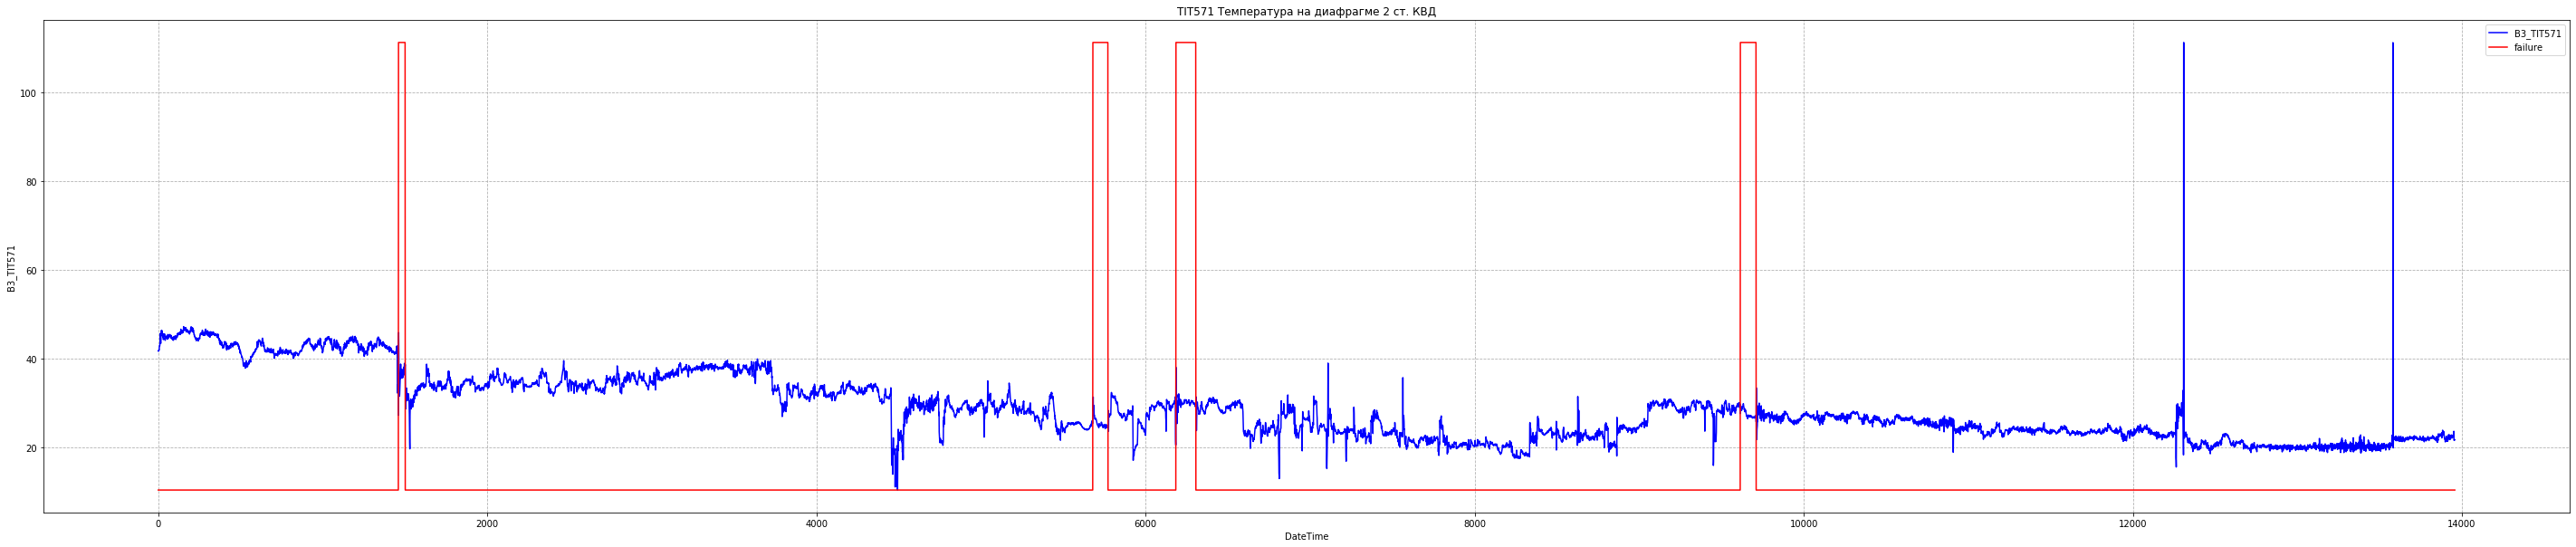

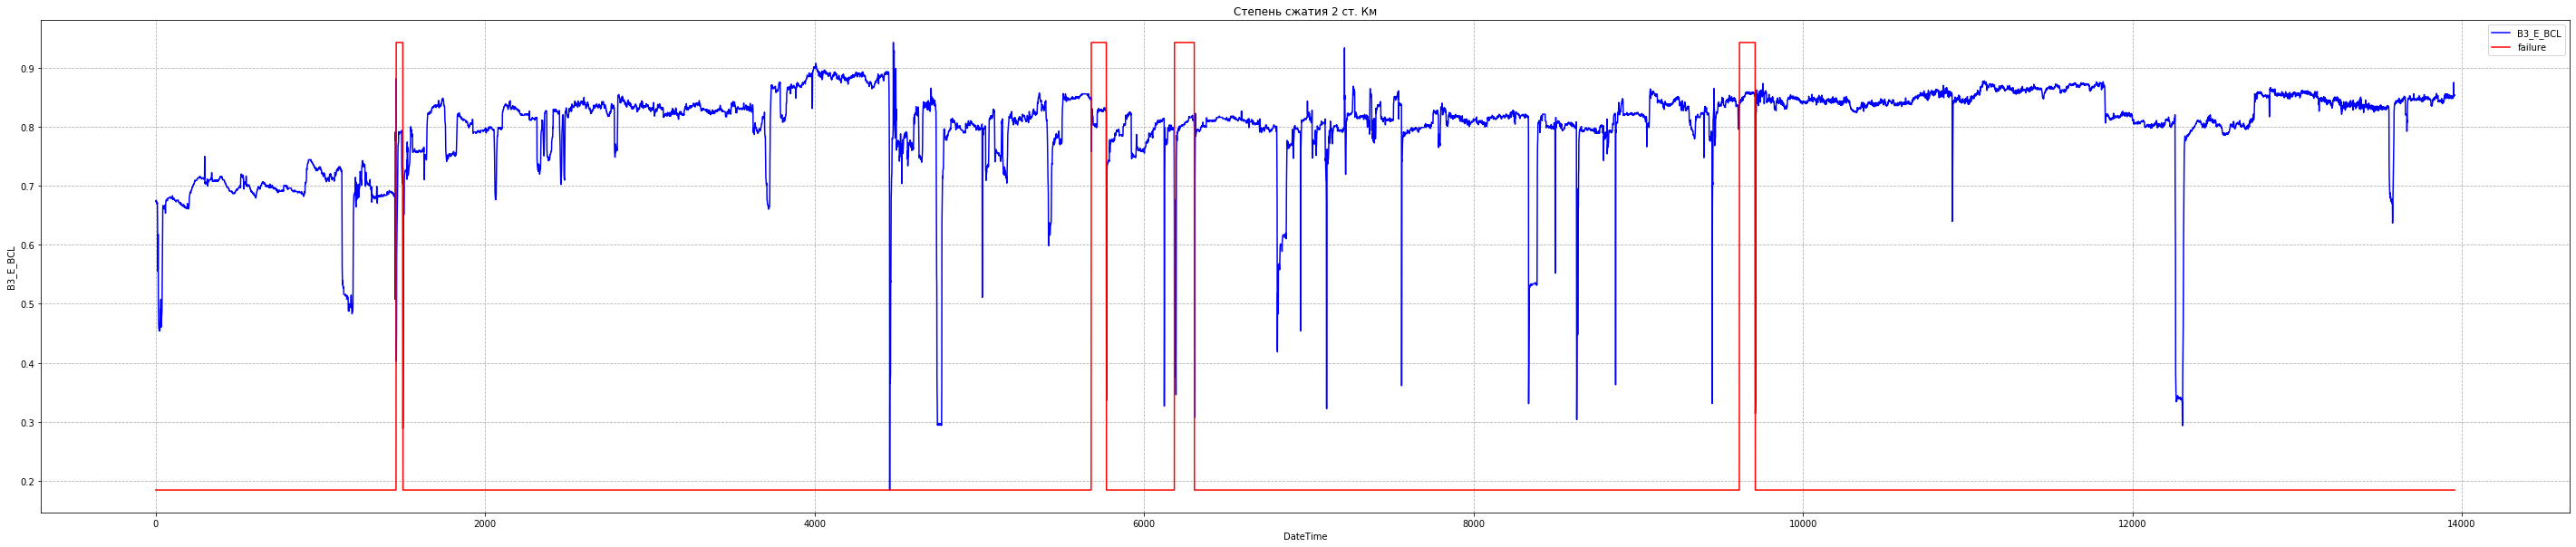

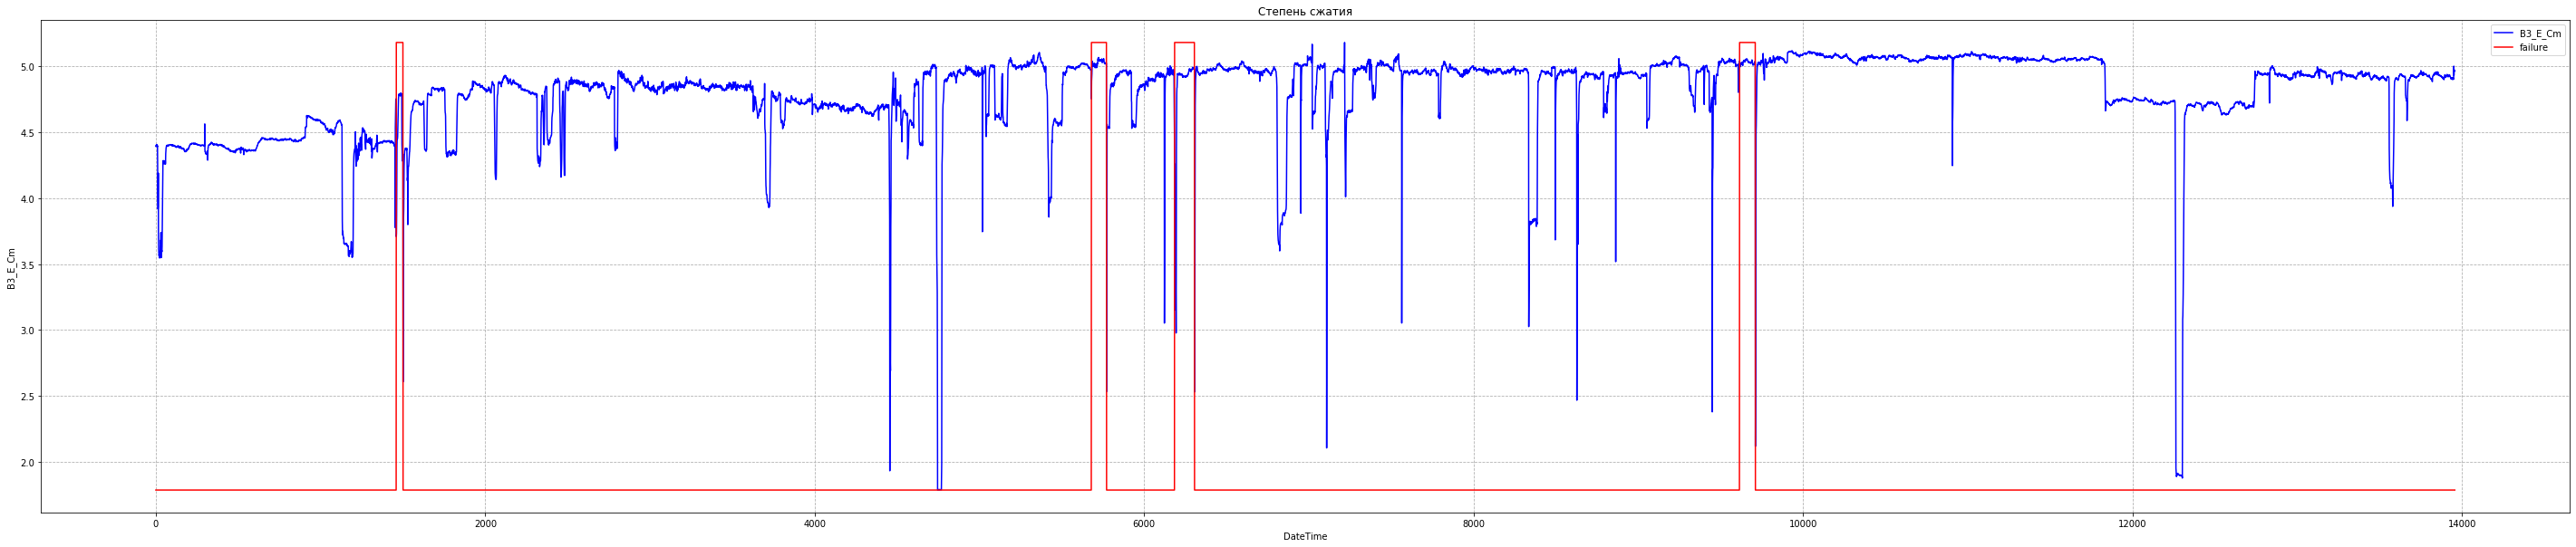

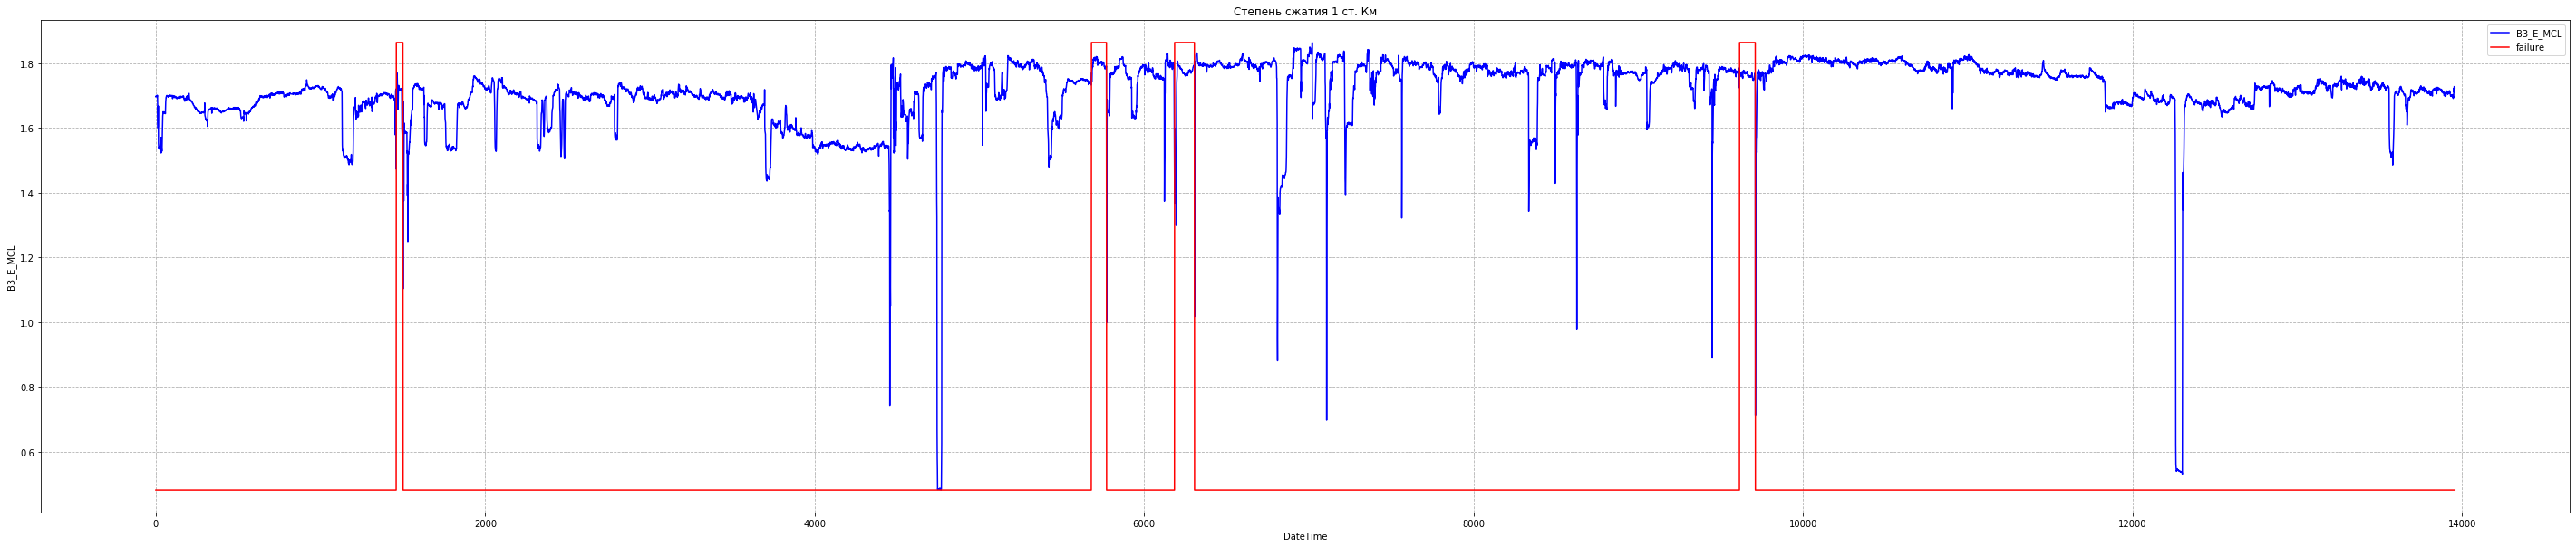

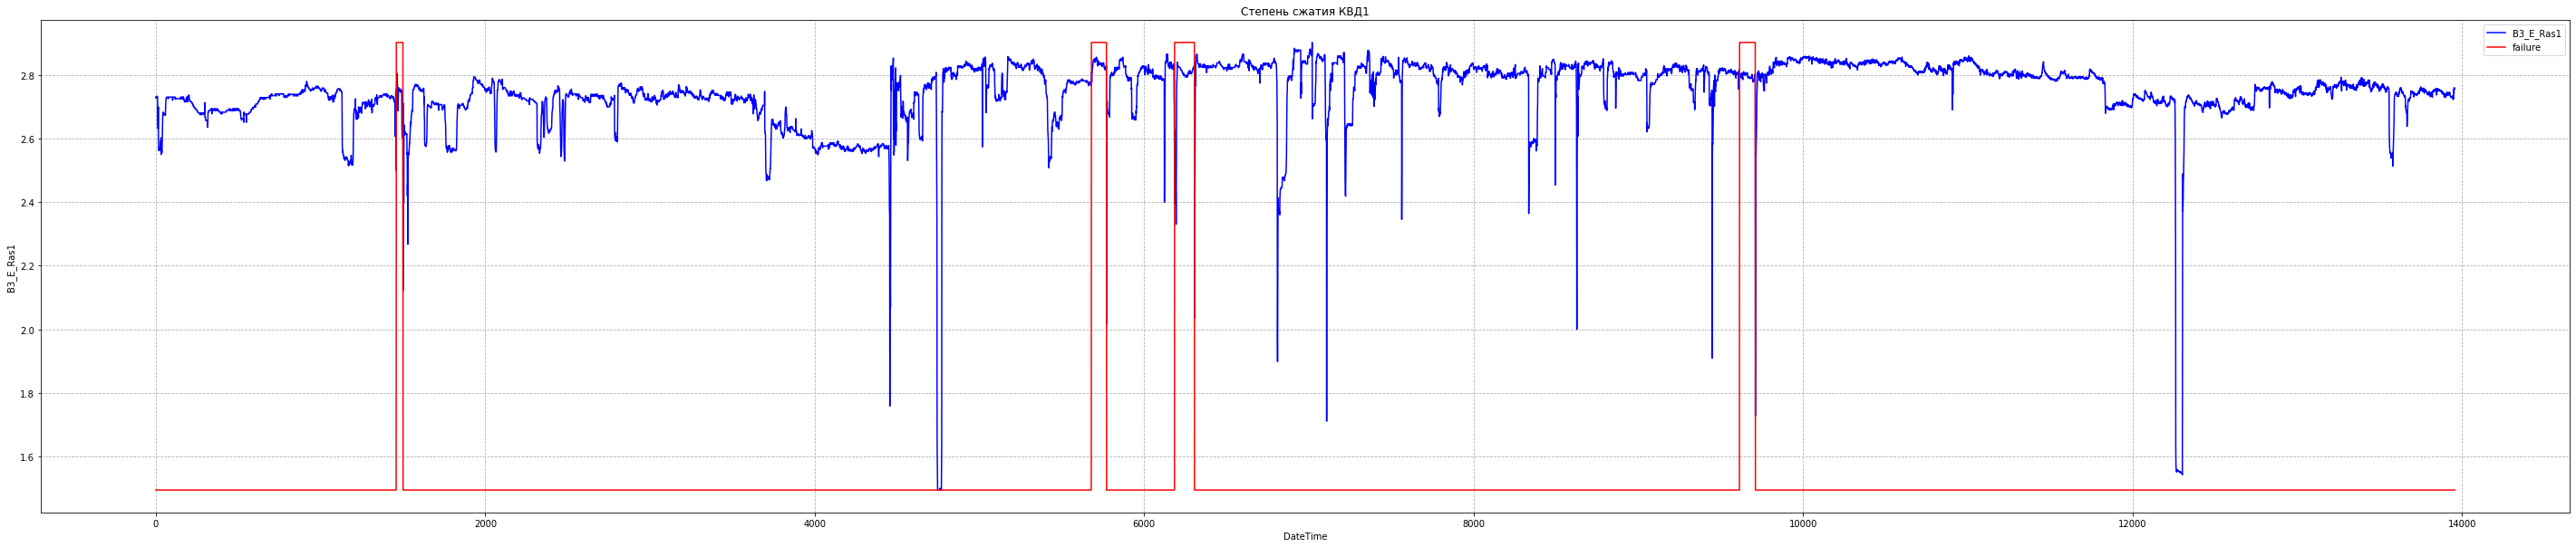

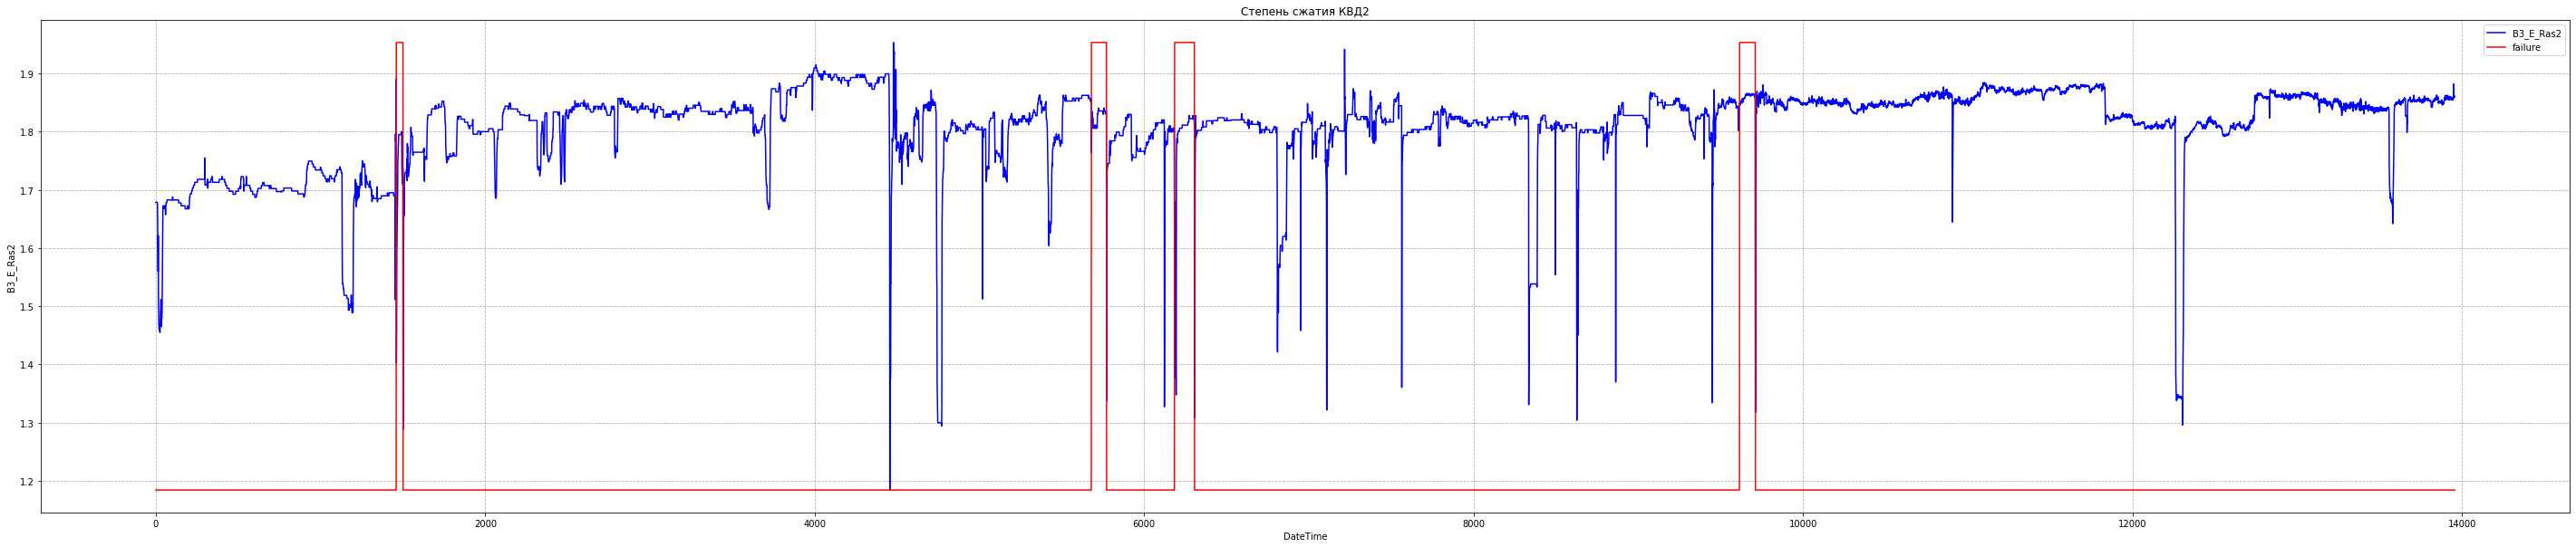

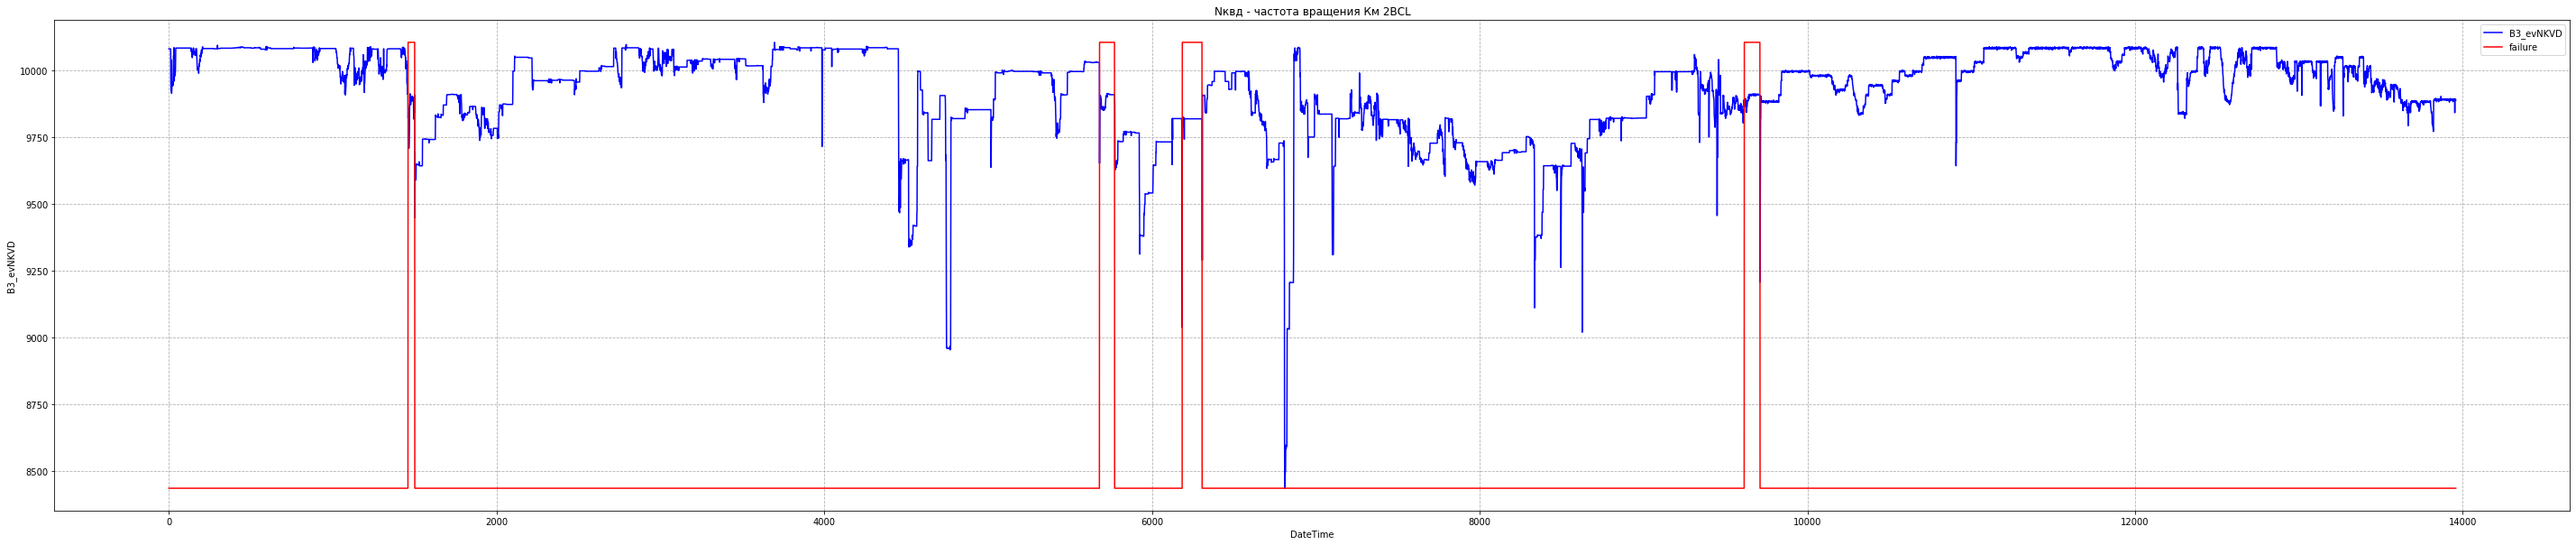

In [46]:
for col in features:

    failure_data = norm_data[not_features]
    min_col = min(norm_data[col])
    max_col = max(norm_data[col])       
    failure_data.loc[failure_data['y']==0, 'y'] = min_col
    failure_data.loc[failure_data['y']==1, 'y'] = max_col
    
    plt.figure(figsize=(50,10)) 
    
    desc_idx = headers.loc[headers['field']==col].index[0]
    desc = headers.values[desc_idx][1]     
    plt.title(desc)
    
    plt.grid(True, linestyle='--')
    
    plt.xlabel('DateTime')
    plt.ylabel(col)
    plt.plot(norm_data[col], label=col, color='blue')
    plt.plot(failure_data['y'], label='failure', color='red')
    
    plt.legend(loc=0)
    plt.show()

Вывод:
1. По графикам визуально оценить зависимость отказов оборудования от показаний датчиков не удается.

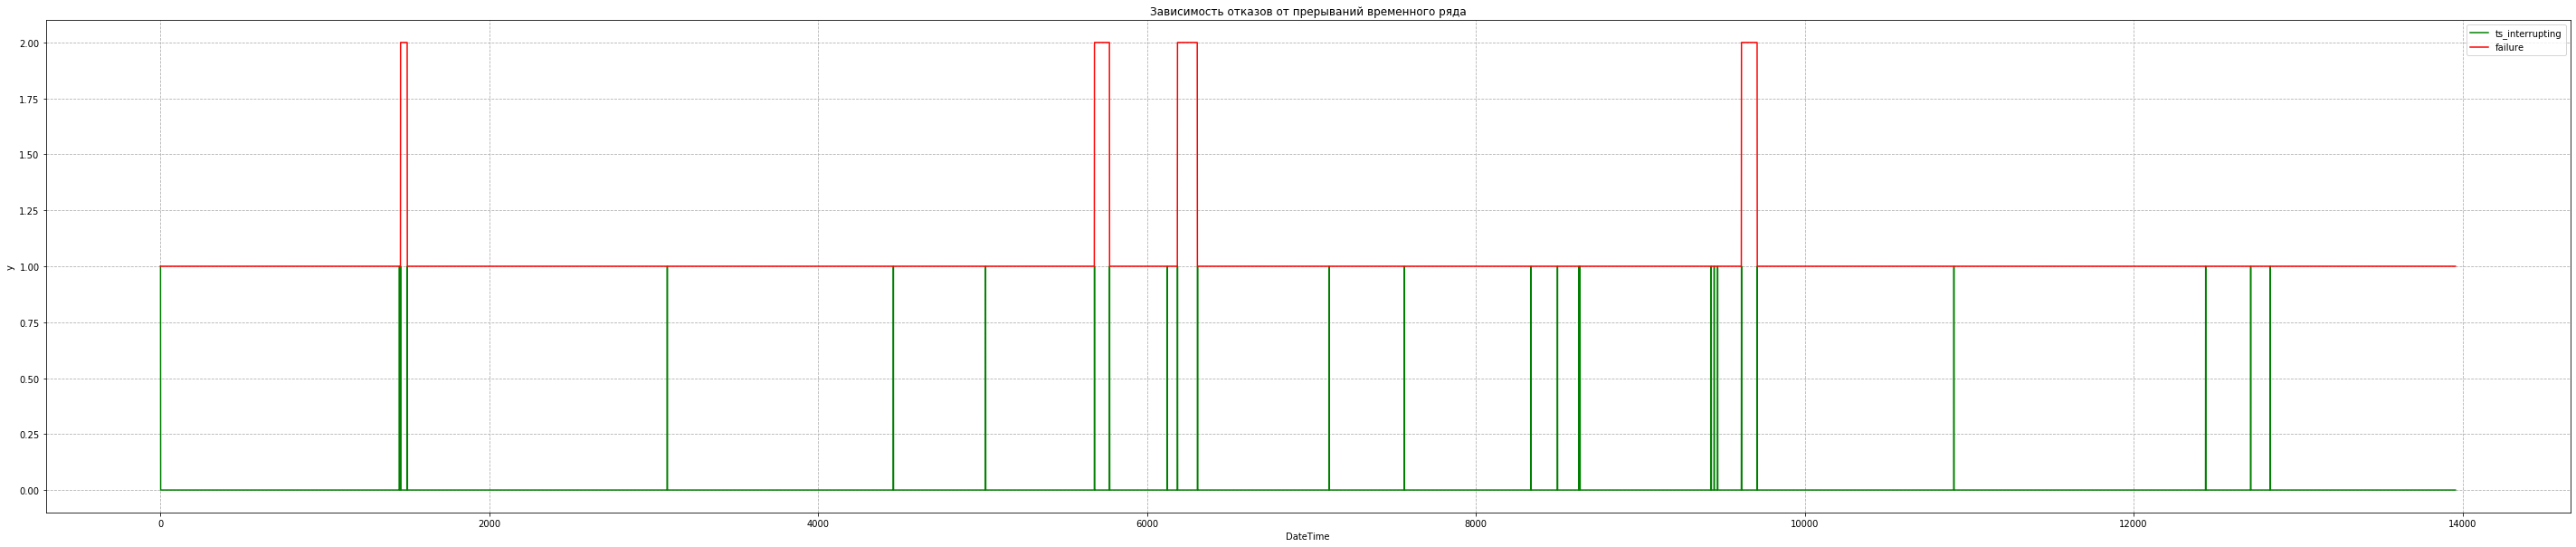

In [47]:
plt.figure(figsize=(50,10))   
plt.title('Зависимость отказов от прерываний временного ряда')
plt.grid(True, linestyle='--')

plt.xlabel('DateTime')
plt.ylabel('y')
plt.plot(norm_data['ts_interrupting'], label='ts_interrupting', color='green')
plt.plot(norm_data['y']+1, label='failure', color='red')
    
plt.legend(loc=0)
plt.show()

Вывод:
1. Переход из нормального режима работы в отказ происходит при прерывании временного ряда. Возможно отказы периодически возникают при включении оборудования.

### Попарная корреляция параметров в рамках групп

Группы параметров:
1. 'B3_P_C5', 'B3_P_C6', 'B3_P_inKVD1', 'B3_P_inKVD2'
2. 'B3_PDIT561', 'B3_PDIT571'
3. 'B3_PIT561', 'B3_PIT563', 'B3_PIT571', 'B3_PIT573'
4. 'B3_T_C5', 'B3_T_C6'
5. 'B3_Tg_inKVD1', 'B3_Tg_inKVD2', 'B3_Tg_outKVD1', 'B3_Tg_outKVD2'
6. 'B3_TIT561', 'B3_TIT571'
7. 'B3_E_BCL', 'B3_E_Cm', 'B3_E_MCL', 'B3_E_Ras1', 'B3_E_Ras2'
8. 'B3_evNKVD'

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


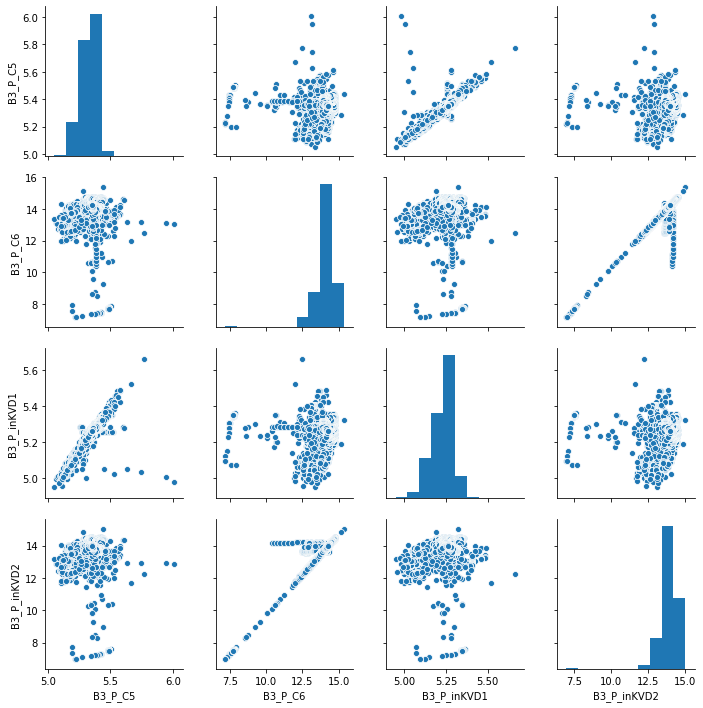

In [48]:
sns_plot = sns.pairplot(norm_data[['B3_P_C5', 'B3_P_C6', 'B3_P_inKVD1', 'B3_P_inKVD2']])
sns_plot.savefig('pairplot.png')

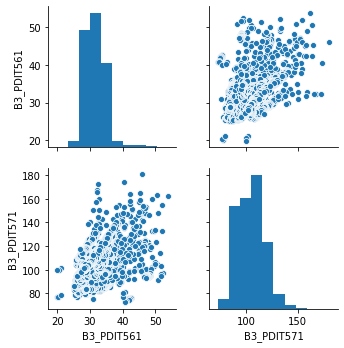

In [49]:
sns_plot = sns.pairplot(norm_data[['B3_PDIT561', 'B3_PDIT571']])
sns_plot.savefig('pairplot.png')

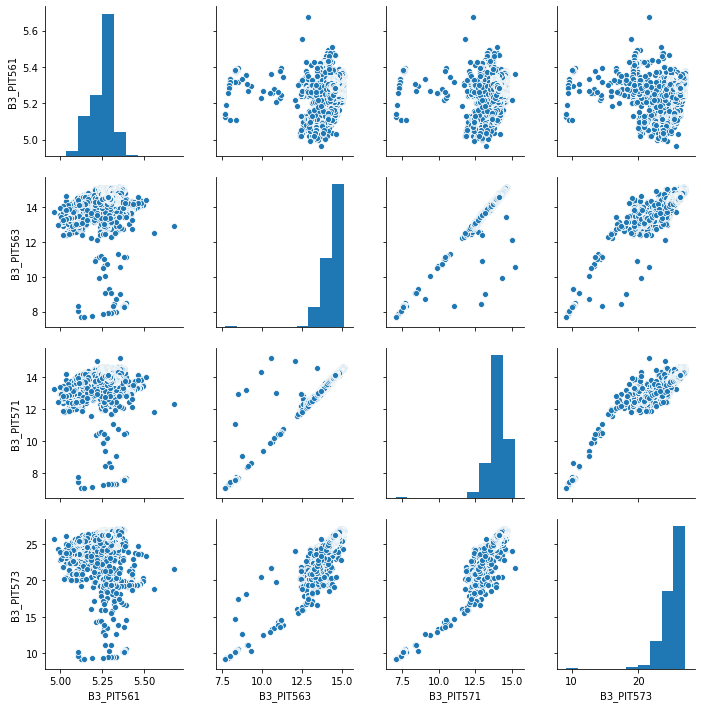

In [50]:
sns_plot = sns.pairplot(norm_data[['B3_PIT561', 'B3_PIT563', 'B3_PIT571', 'B3_PIT573']])
sns_plot.savefig('pairplot.png')

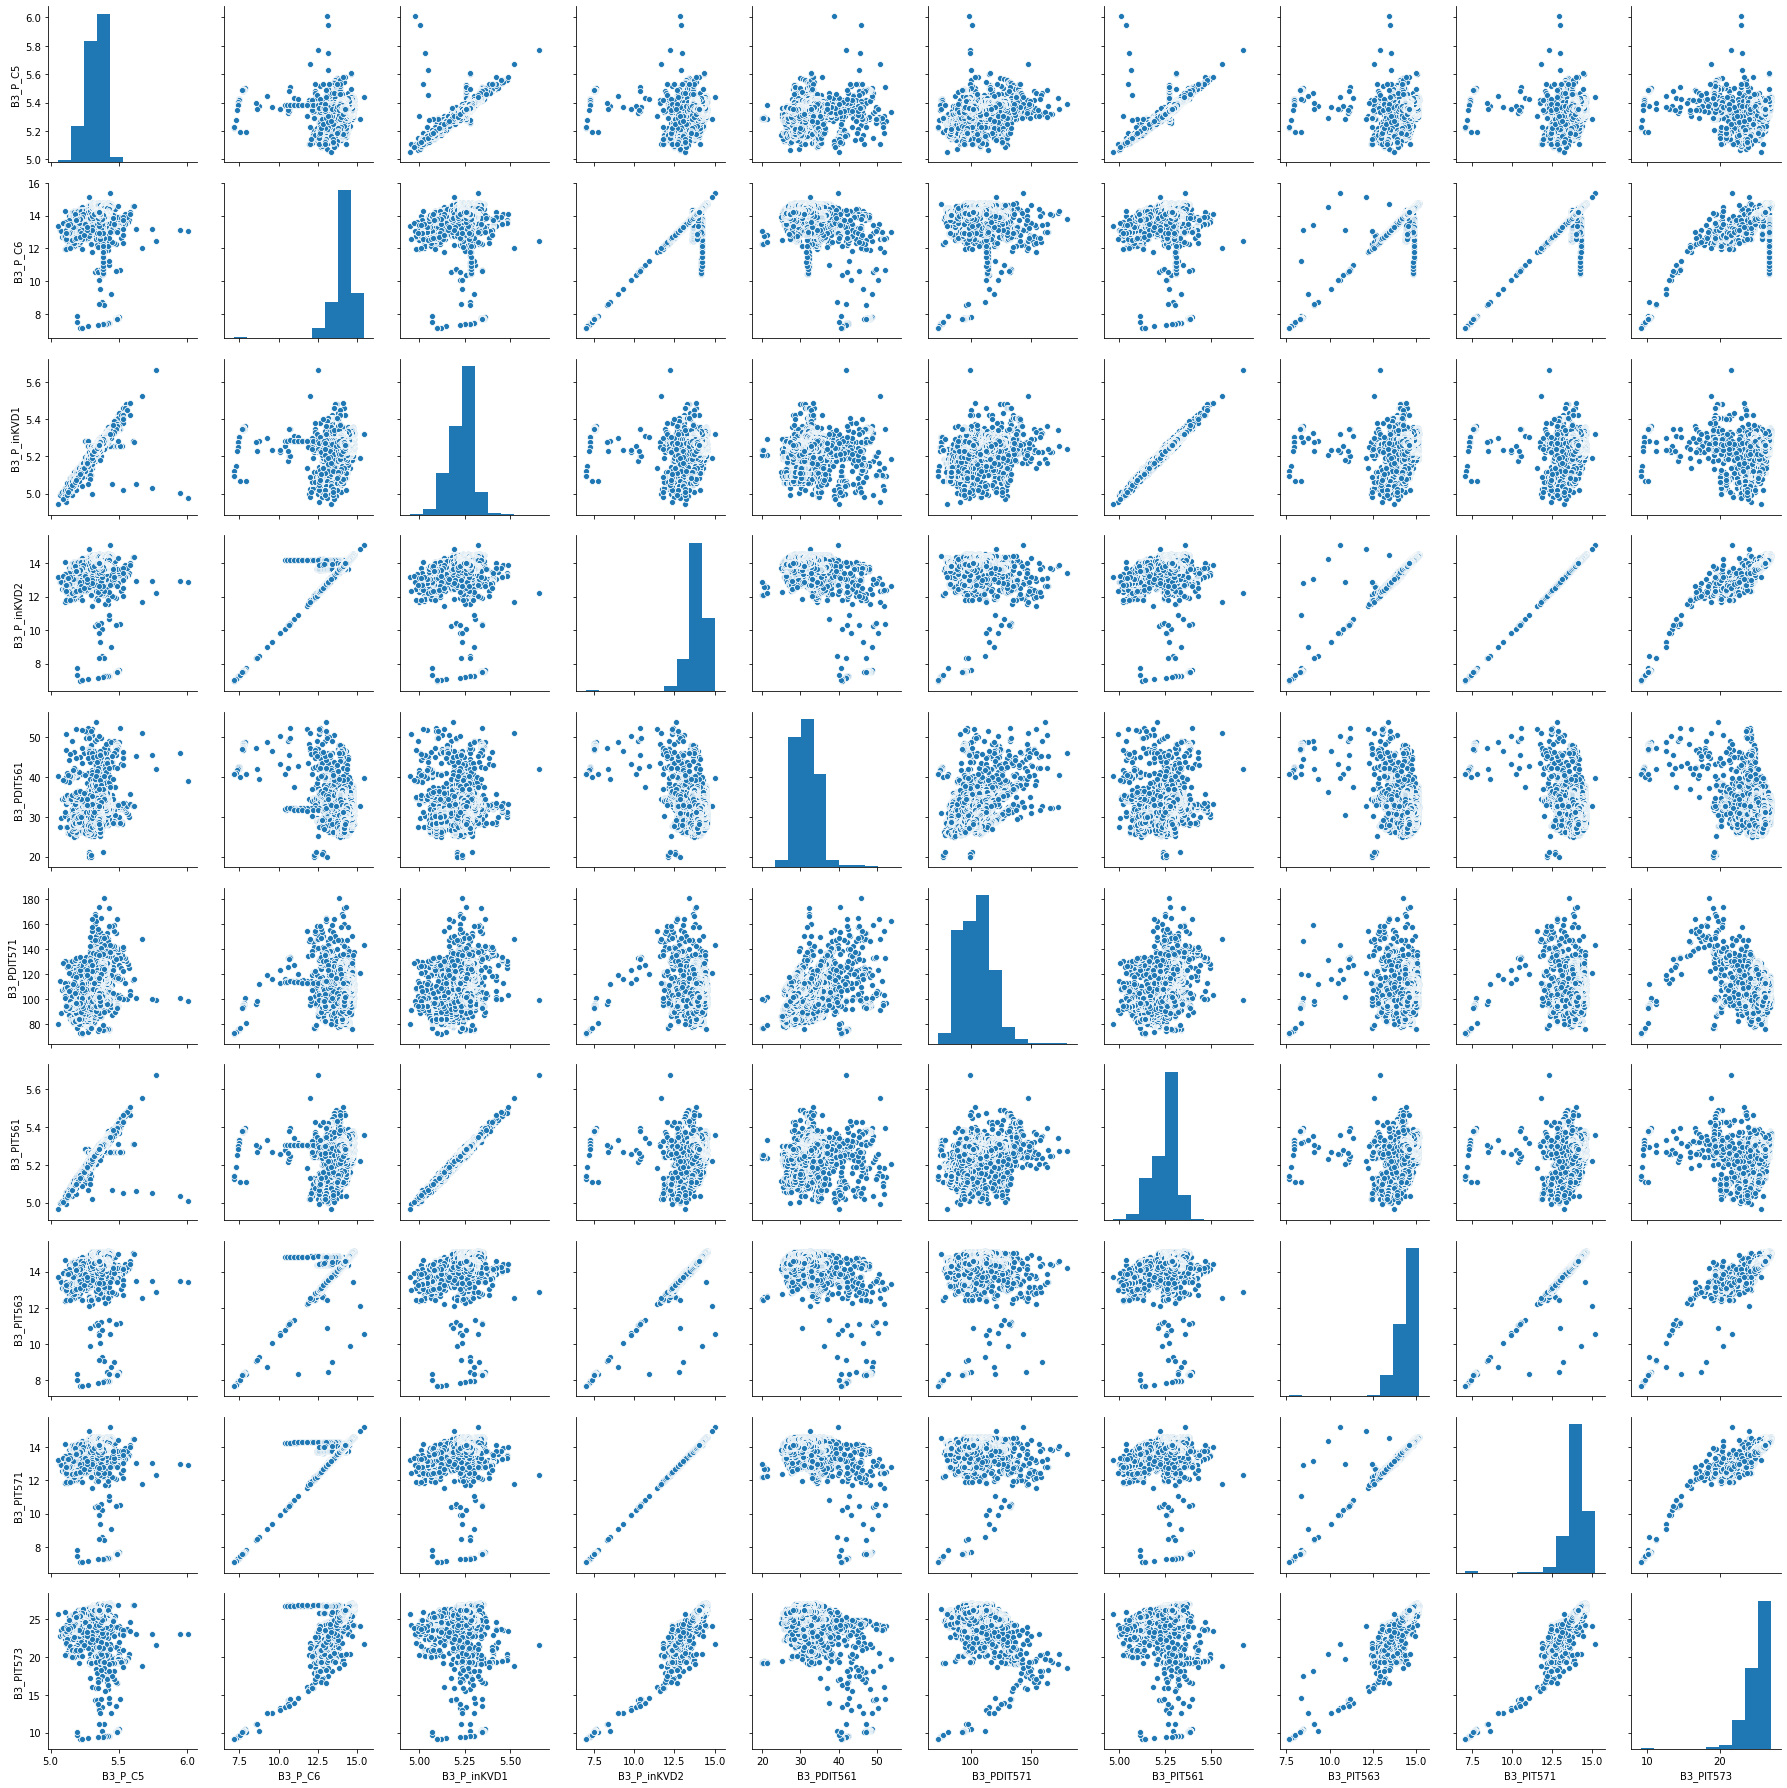

In [51]:
sns_plot = sns.pairplot(norm_data[['B3_P_C5', 'B3_P_C6', 'B3_P_inKVD1', 'B3_P_inKVD2', 'B3_PDIT561', 'B3_PDIT571', 'B3_PIT561', 'B3_PIT563', 'B3_PIT571', 'B3_PIT573']])
sns_plot.savefig('pairplot.png')

Вывод:
1. Сильно скореллированы величины: B3_P_C5, B3_P_inKVD1, B3_PIT561
2. Сильно скореллированы величины: B3_P_C6, B3_P_inKVD2, B3_PIT563, B3_PIT571

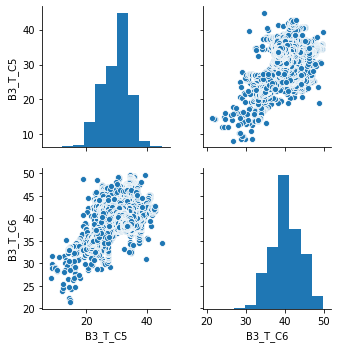

In [17]:
sns_plot = sns.pairplot(norm_data[['B3_T_C5', 'B3_T_C6']])
sns_plot.savefig('pairplot.png')

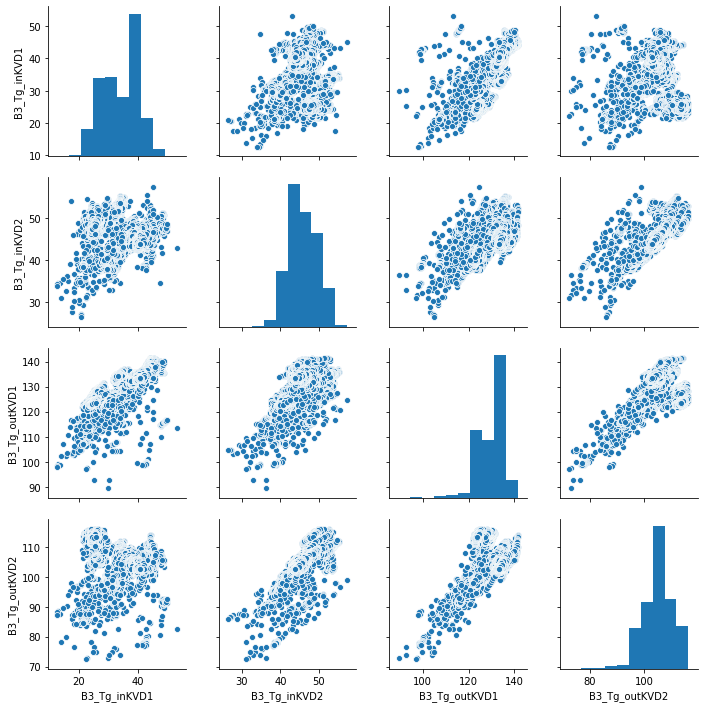

In [18]:
sns_plot = sns.pairplot(norm_data[['B3_Tg_inKVD1', 'B3_Tg_inKVD2', 'B3_Tg_outKVD1', 'B3_Tg_outKVD2']])
sns_plot.savefig('pairplot.png')

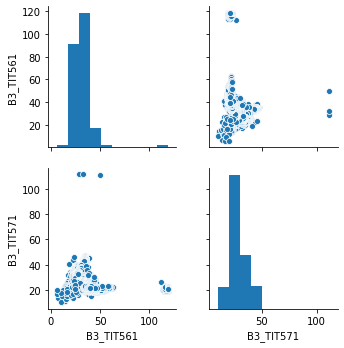

In [19]:
sns_plot = sns.pairplot(norm_data[['B3_TIT561', 'B3_TIT571']])
sns_plot.savefig('pairplot.png')

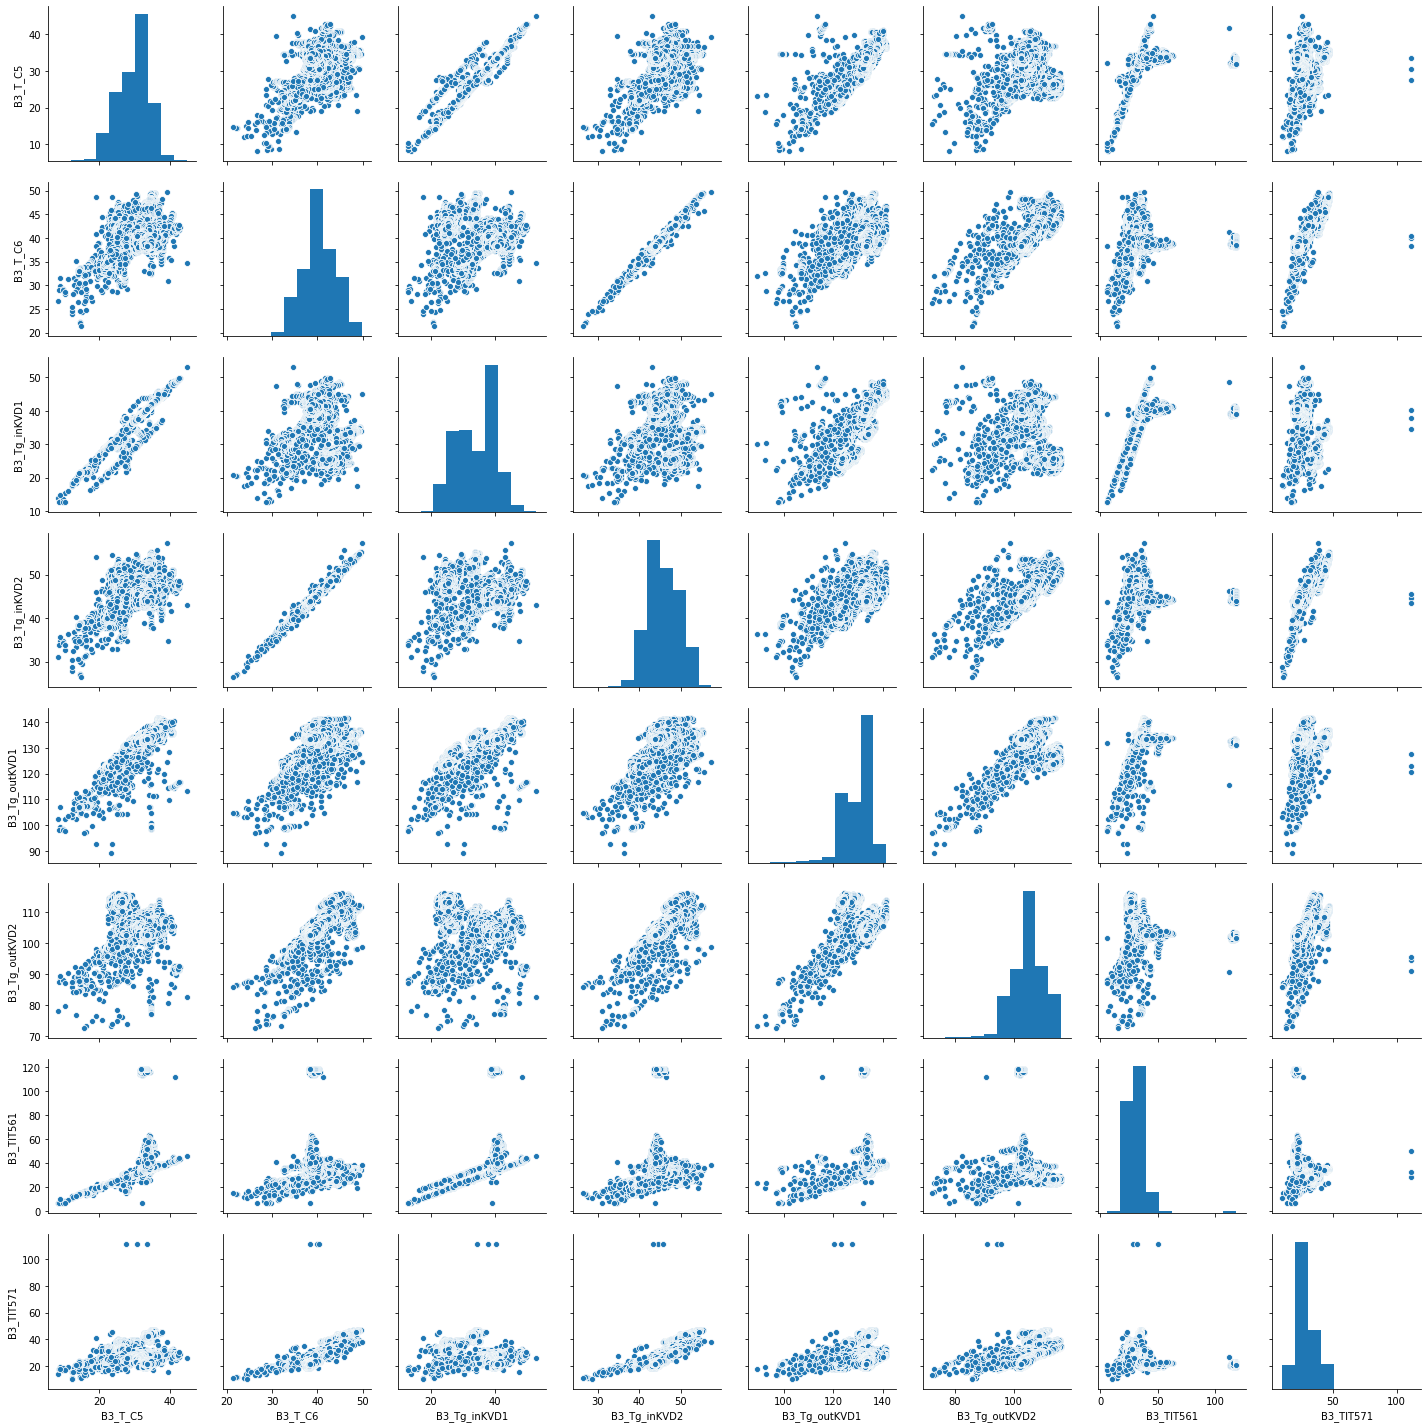

In [52]:
sns_plot = sns.pairplot(norm_data[['B3_T_C5', 'B3_T_C6', 'B3_Tg_inKVD1', 'B3_Tg_inKVD2', 'B3_Tg_outKVD1', 'B3_Tg_outKVD2', 'B3_TIT561', 'B3_TIT571']])
sns_plot.savefig('pairplot.png')

Вывод:
1. Сильно скореллированы величины: B3_T_C5, B3_Tg_inKVD1
2. Сильно скореллированы величины: B3_T_C6, B3_Tg_inKVD2

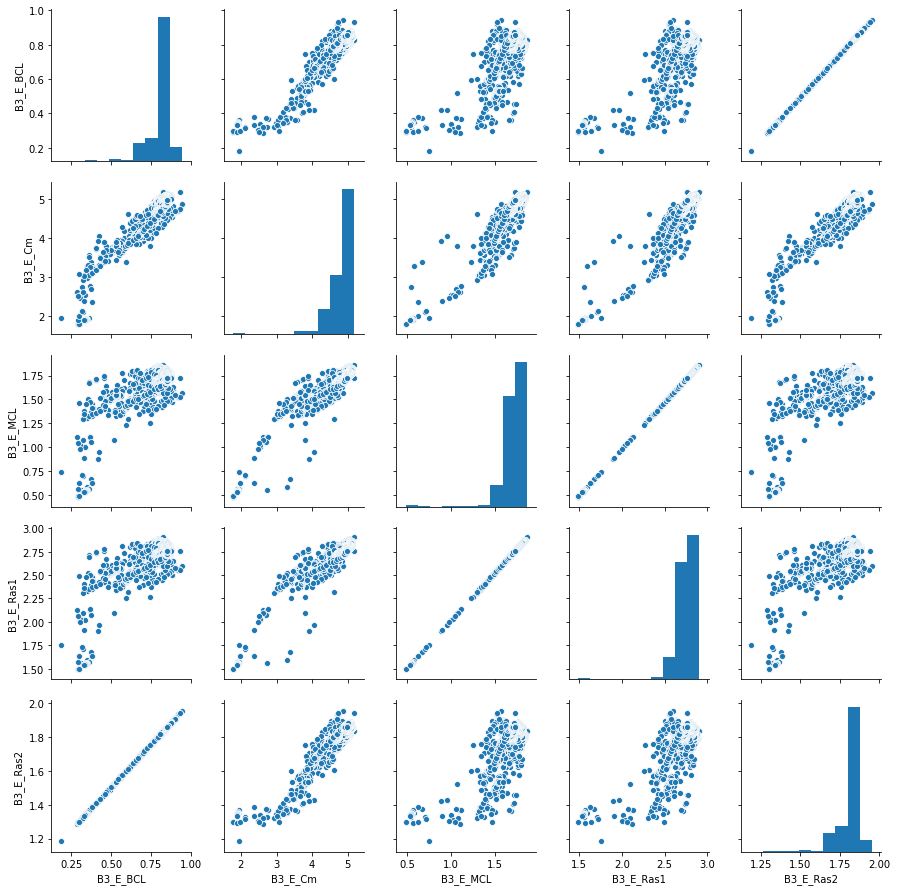

In [20]:
sns_plot = sns.pairplot(kvd[['B3_E_BCL', 'B3_E_Cm', 'B3_E_MCL', 'B3_E_Ras1', 'B3_E_Ras2']])
sns_plot.savefig('pairplot.png')

Вывод:
1. Сильно скореллированы величины: B3_E_BCL, B3_E_Ras2
2. Сильно скореллированы величины: B3_E_MCL, B3_E_Ras1

### Проверка стационарности временных рядов показаний датчиков

In [54]:
#Тест Дики — Фуллера (проверка стационарности ряда)
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [55]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [56]:
for col in features:
    print(col)
    print('-' * len(col))
    #tsplot(kvd[col].loc[(~pd.isnull(kvd[col]))])
    test_stationarity(norm_data[col].loc[(~pd.isnull(norm_data[col]))])
    print()

B3_P_C5
-------
Results of Dickey-Fuller Test:
Test Statistic                -6.181958e+00
p-value                        6.423098e-08
#Lags Used                     4.000000e+01
Number of Observations Used    1.391400e+04
Critical Value (1%)           -3.430820e+00
Critical Value (5%)           -2.861748e+00
Critical Value (10%)          -2.566881e+00
dtype: float64

B3_P_C6
-------
Results of Dickey-Fuller Test:
Test Statistic                -9.563378e+00
p-value                        2.392656e-16
#Lags Used                     4.200000e+01
Number of Observations Used    1.391200e+04
Critical Value (1%)           -3.430820e+00
Critical Value (5%)           -2.861748e+00
Critical Value (10%)          -2.566881e+00
dtype: float64

B3_P_inKVD1
-----------
Results of Dickey-Fuller Test:
Test Statistic                -5.984015e+00
p-value                        1.810164e-07
#Lags Used                     4.200000e+01
Number of Observations Used    1.390800e+04
Critical Value (1%)        

Test Statistic                -1.094983e+01
p-value                        8.855099e-20
#Lags Used                     1.100000e+01
Number of Observations Used    1.394300e+04
Critical Value (1%)           -3.430819e+00
Critical Value (5%)           -2.861747e+00
Critical Value (10%)          -2.566880e+00
dtype: float64

B3_evNKVD
---------
Results of Dickey-Fuller Test:
Test Statistic                -7.709749e+00
p-value                        1.273175e-11
#Lags Used                     1.600000e+01
Number of Observations Used    1.393800e+04
Critical Value (1%)           -3.430819e+00
Critical Value (5%)           -2.861747e+00
Critical Value (10%)          -2.566880e+00
dtype: float64



Вывод:
1. Тест Дики-Фуллера показал, что временные ряды можно считать стационарными (p-value < 0.05), следовательно, можно применить модели прогнозирования временных рядов для заполнения пропусков данных.

## Feature engineering

### Заполнение пропусков в числовых данных

#### Заполнение пустых значений путем предсказания с помощью модели ARMA

In [50]:
# ToDo: обучить модель на исторических данных, выполнить предсказание пропущенных значений, обновить DataFrame.

#### Заполнение пустых значений медианными значениями

In [11]:
'''
#Расчет медиан для каждого атрибута по группам в зависимости от целевого столбца

for col in norm_data.loc[:, ~norm_data.columns.isin(not_features)].columns:
    median_y0 = norm_data[col].loc[~pd.isnull(norm_data[col])].loc[norm_data['y']==0].median()
    median_y1 = norm_data[col].loc[~pd.isnull(norm_data[col])].loc[norm_data['y']==1].median()
    
    #замена пустого значения на медиану
    norm_data.loc[(pd.isnull(norm_data[col])) & (norm_data['y']==0), col] = median_y0
    norm_data.loc[(pd.isnull(norm_data[col])) & (norm_data['y']==1), col] = median_y1

'''

#### Заполнение пустых значений по среднему от ближайших заполненных по временному ряду

In [57]:
for col in features:

    for idx in range(len(norm_data[col].loc[(pd.isnull(norm_data[col]))])-1, -1, -1):
    #Цикл запускается от большего индекса пустого значения к меньшему,
        #т.к. при каждом проходе становится на 1 пустое значение меньше.
    
        row_idx = norm_data[col].loc[(pd.isnull(norm_data[col]))].index[idx]
        #print(row_idx)

        value_before = 0.0
        value_after = 0.0

        value_idx = row_idx
        while math.isnan(norm_data.values[value_idx][norm_data.columns.get_loc(col)]):
            value_idx -= 1
            value_before = norm_data.values[value_idx][norm_data.columns.get_loc(col)]
            #print(value_before)

        value_idx = row_idx
        while math.isnan(norm_data.values[value_idx][norm_data.columns.get_loc(col)]):
            value_idx += 1
            value_after = norm_data.values[value_idx][norm_data.columns.get_loc(col)]
            #print(value_after)   

        value_mean = pd.Series([value_before, value_after]).mean()
        #print(value_mean)
        norm_data.at[row_idx, col] = value_mean

In [58]:
norm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13958 entries, 0 to 13957
Data columns (total 26 columns):
B3_P_C5            13958 non-null float64
B3_P_C6            13958 non-null float64
B3_P_inKVD1        13958 non-null float64
B3_P_inKVD2        13958 non-null float64
B3_PDIT561         13958 non-null float64
B3_PDIT571         13958 non-null float64
B3_PIT561          13958 non-null float64
B3_PIT563          13958 non-null float64
B3_PIT571          13958 non-null float64
B3_PIT573          13958 non-null float64
B3_T_C5            13958 non-null float64
B3_T_C6            13958 non-null float64
B3_Tg_inKVD1       13958 non-null float64
B3_Tg_inKVD2       13958 non-null float64
B3_Tg_outKVD1      13958 non-null float64
B3_Tg_outKVD2      13958 non-null float64
B3_TIT561          13958 non-null float64
B3_TIT571          13958 non-null float64
B3_E_BCL           13958 non-null float64
B3_E_Cm            13958 non-null float64
B3_E_MCL           13958 non-null float64
B3_E_Ras1

### Замена абсолютных значений показаний датчиков на относительные в зависимости от предыдущего значения

In [59]:
#Копирование исходных данных в новый DataFrame для выполнения преобразований
norm_data_relative = norm_data.copy()

In [60]:
#Чтобы учесть временную зависимость величин, заменим абсолюьные значения показаний датчиков на приращения величин
for col in features:
    norm_data_relative[col] = norm_data_relative[col].diff()
    
    norm_data_relative.loc[(pd.isnull(norm_data_relative[col])), col] = 0

In [61]:
norm_data_relative

B3_P_C5   B3_P_C6  B3_P_inKVD1  B3_P_inKVD2  B3_PDIT561  B3_PDIT571  \
0      0.000000  0.000000     0.000000     0.000000    0.000000    0.000000   
1     -0.009375  0.000000     0.000000     0.000000    0.161133    0.421143   
2     -0.011250 -0.028127     0.000000    -0.026564   -0.208744   -0.640869   
3     -0.011250 -0.026563    -0.026562    -0.026563   -0.157471    0.265503   
4      0.011250  0.001563     0.000000     0.000000    0.307621    0.054932   
...         ...       ...          ...          ...         ...         ...   
13953 -0.018751  0.045313    -0.017188     0.053124   -0.615244   -1.611351   
13954  0.009375  0.029688     0.010937     0.028126   -0.007324   -0.192261   
13955  0.001875 -0.003127     0.001563    -0.004688   -0.142822   -0.247215   
13956  0.002500  0.007813     0.003125     0.014062   -0.142822   -0.228882   
13957  0.000000 -0.004686    -0.003125    -0.007812   -0.457773   -0.531006   

       B3_PIT561  B3_PIT563  B3_PIT571  B3_PIT573  ...  B3_TIT561  B3_TIT571  \
0       0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
1      -0.016136   0.000000   0.000000  -0.035248  ...  -0.302128  -0.045776   
2      -0.015450  -0.027374  -0.026184   0.000000  ...  -0.100708   0.043488   
3       0.000000  -0.026184  -0.026184  -0.035252  ...   0.000000   0.098419   
4       0.000000  -0.000595   0.000595   0.000000  ...   0.100708   0.199135   
...          ...        ...        ...        ...  ...        ...        ...   
13953  -0.017510   0.039276   0.053560   0.132183  ...  -6.619362   0.061798   
13954   0.009957   0.026781   0.026779   0.041656  ...   1.107803  -0.050354   
13955   0.001373  -0.001785  -0.003571  -0.008810  ...  -0.109863   0.038910   
13956   0.001717   0.005951   0.010117   0.007208  ...   0.402840  -0.006866   
13957   0.001717  -0.007141  -0.004761  -0.016821  ...   0.091553   0.061798   

       B3_E_BCL   B3_E_Cm  B3_E_MCL  B3_E_Ras1  B3_E_Ras2  B3_evNKVD  y  \
0      0.000000  0.000000  0.000000   0.000000   0.000000   0.000000  0   
1      0.000000  0.000205  0.000183   0.000000   0.000000   0.000000  0   
2      0.000229  0.004388  0.002289   0.005541   0.000000   0.000000  0   
3      0.002014  0.004683 -0.000092   0.000000   0.000000   0.000000  0   
4     -0.002014 -0.008789 -0.002289   0.000000   0.000000   0.000000  0   
...         ...       ...       ...        ...        ...        ... ..   
13953  0.002243  0.041641  0.016937   0.017315   0.002178   0.268555  0   
13954 -0.000595 -0.001166  0.000000   0.000044  -0.000582   0.000000  0   
13955 -0.000183 -0.003285 -0.001190  -0.001235  -0.000153   3.212891  0   
13956 -0.000824 -0.000250  0.000366   0.000230  -0.000824  -5.355469  0   
13957 -0.000549 -0.004797 -0.002289  -0.002248  -0.000565   0.802734  0   

       ts_interrupting  
0                    1  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
13953                0  
13954                0  
13955                0  
13956                0  
13957                0  

[13958 rows x 26 columns]

#### Зависимость отказов КВД от показаний каждого из датчиков после замены значений

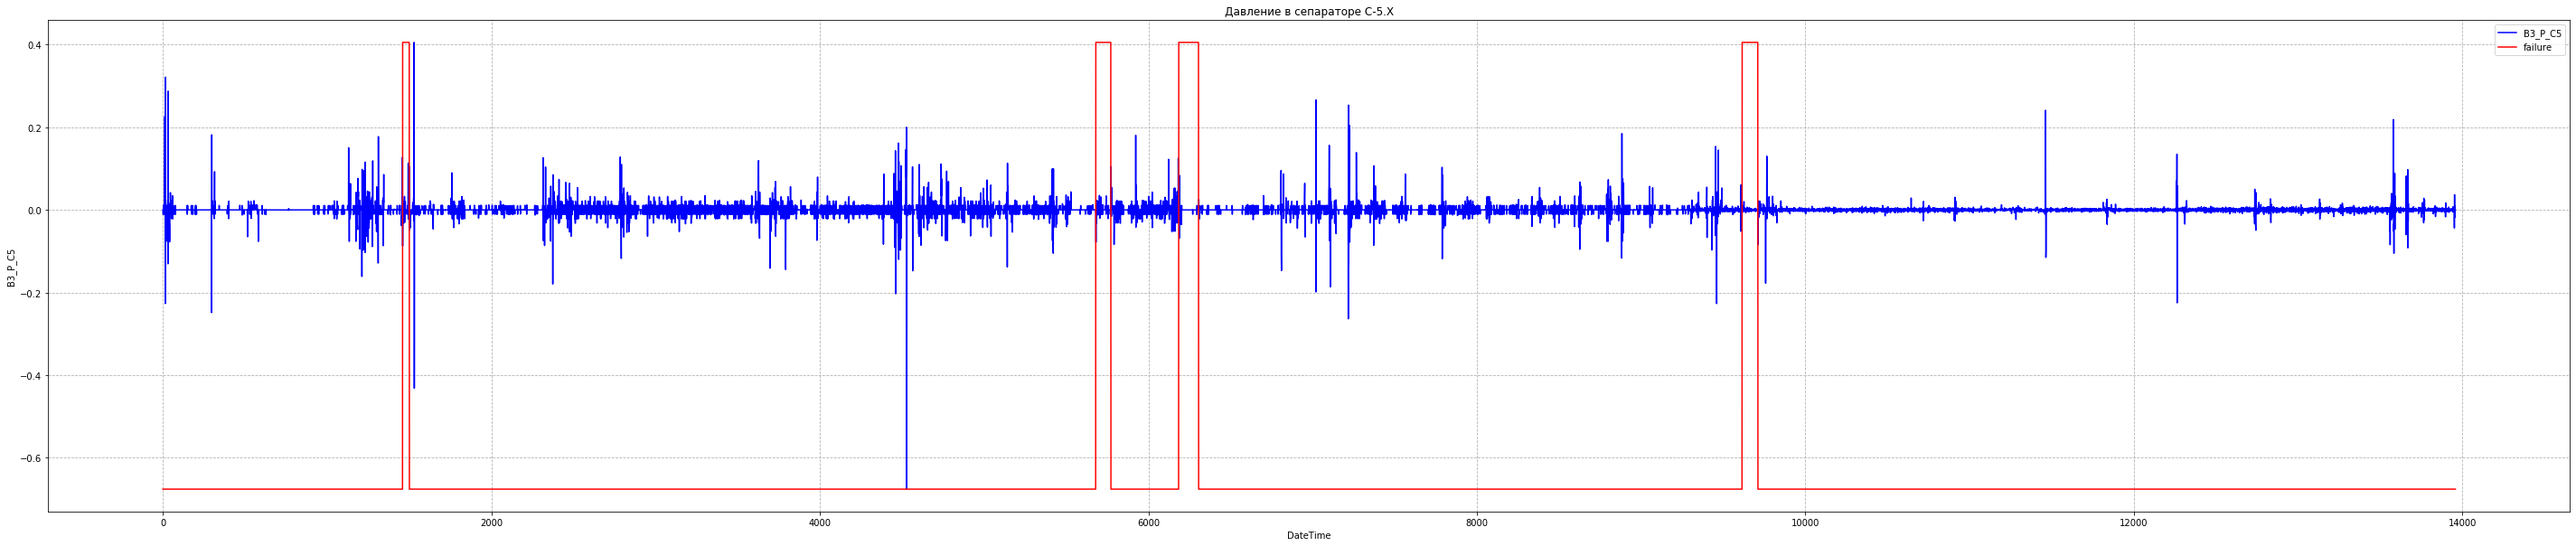

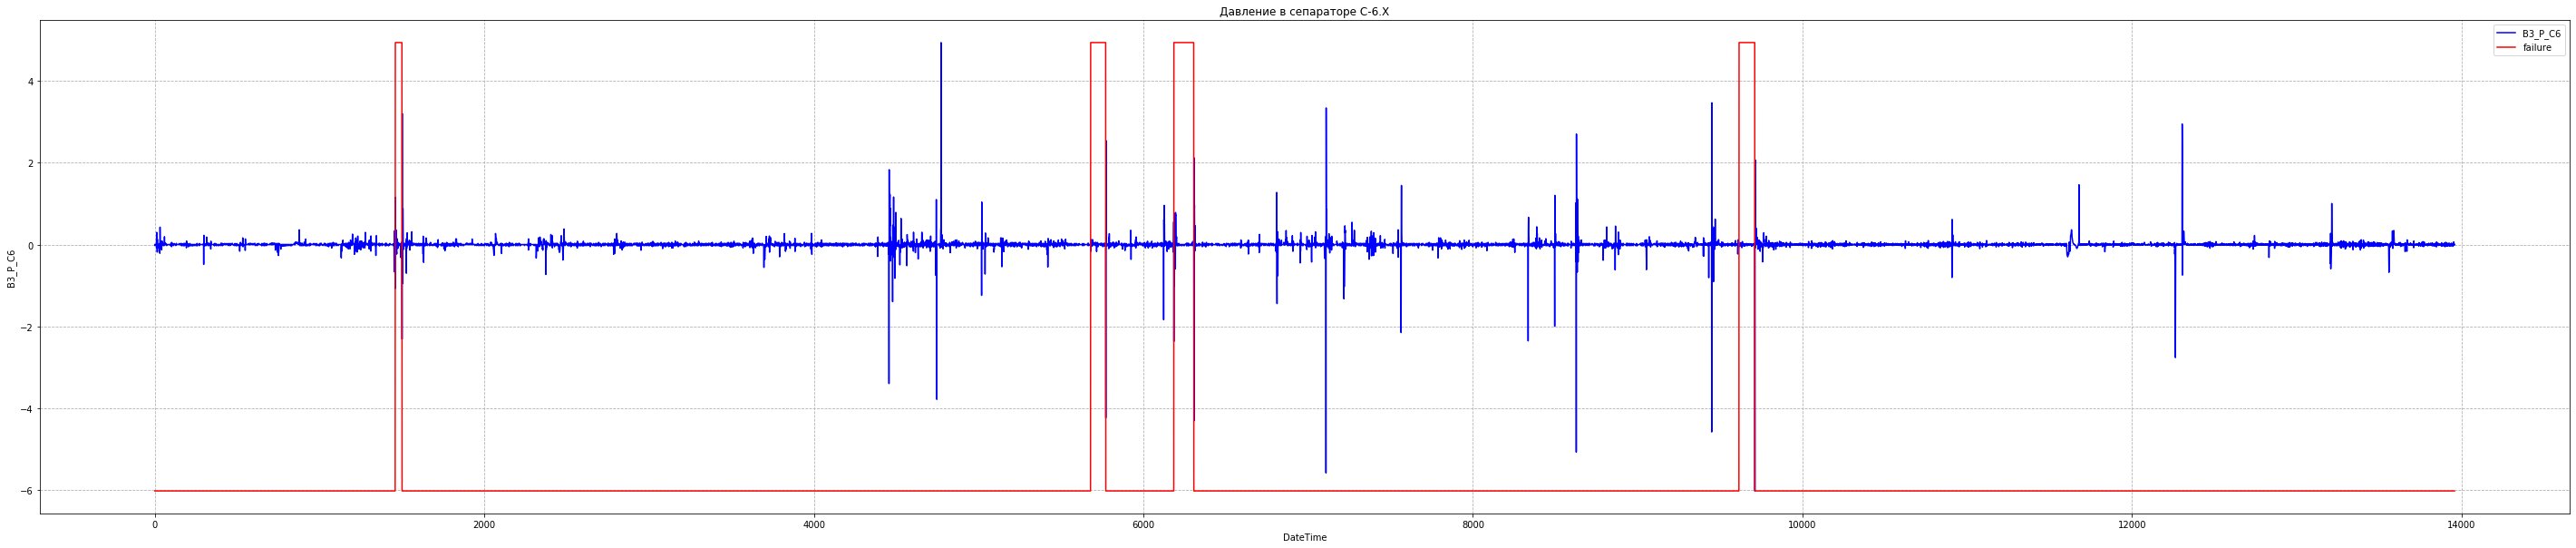

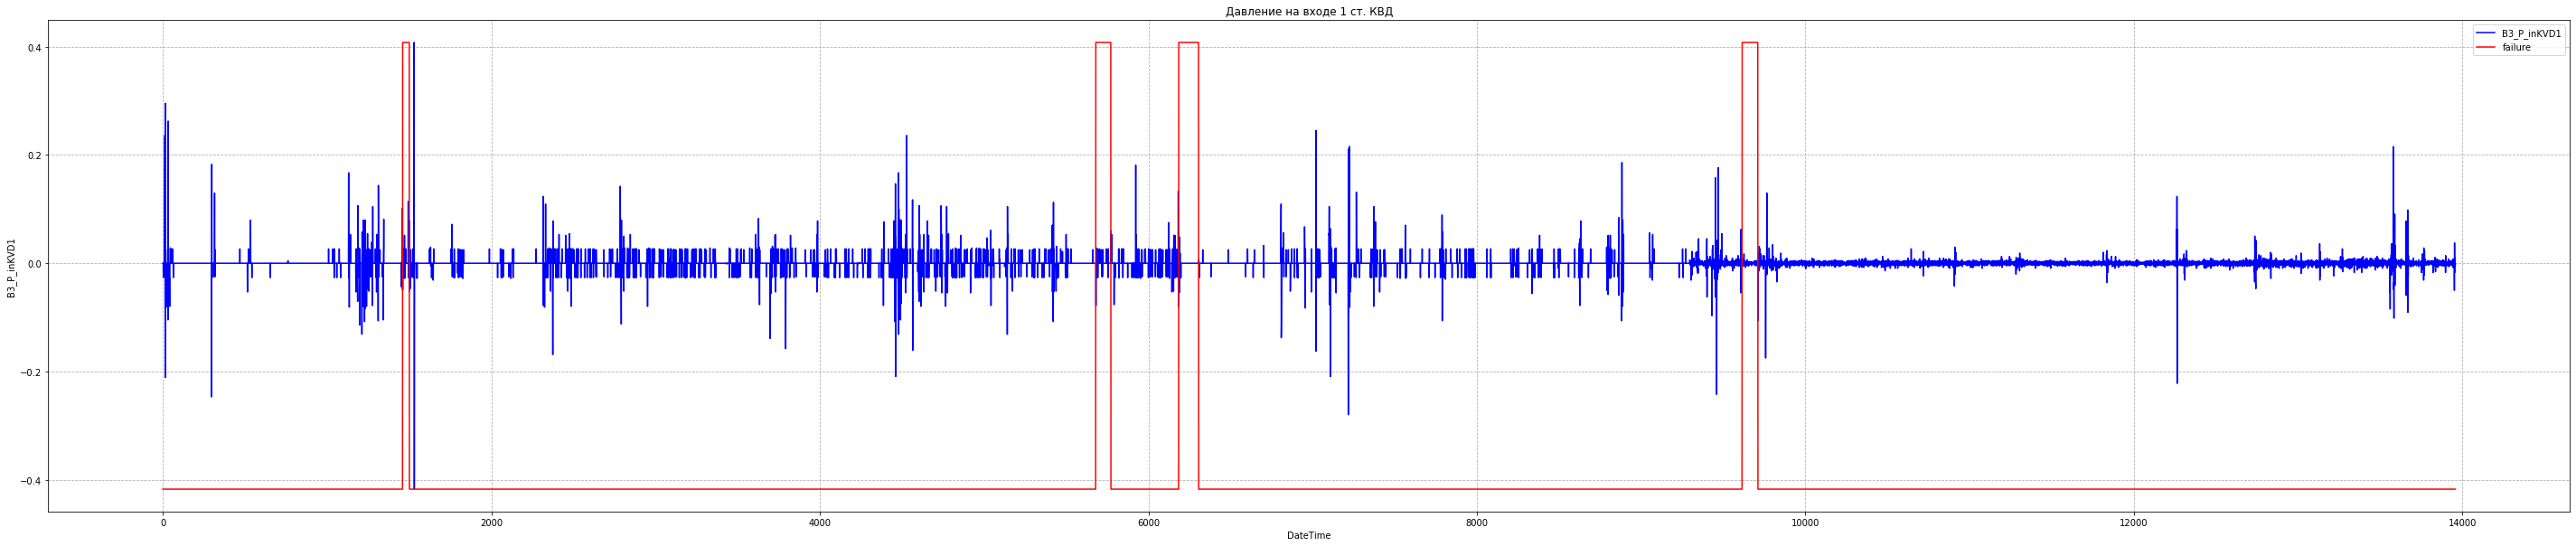

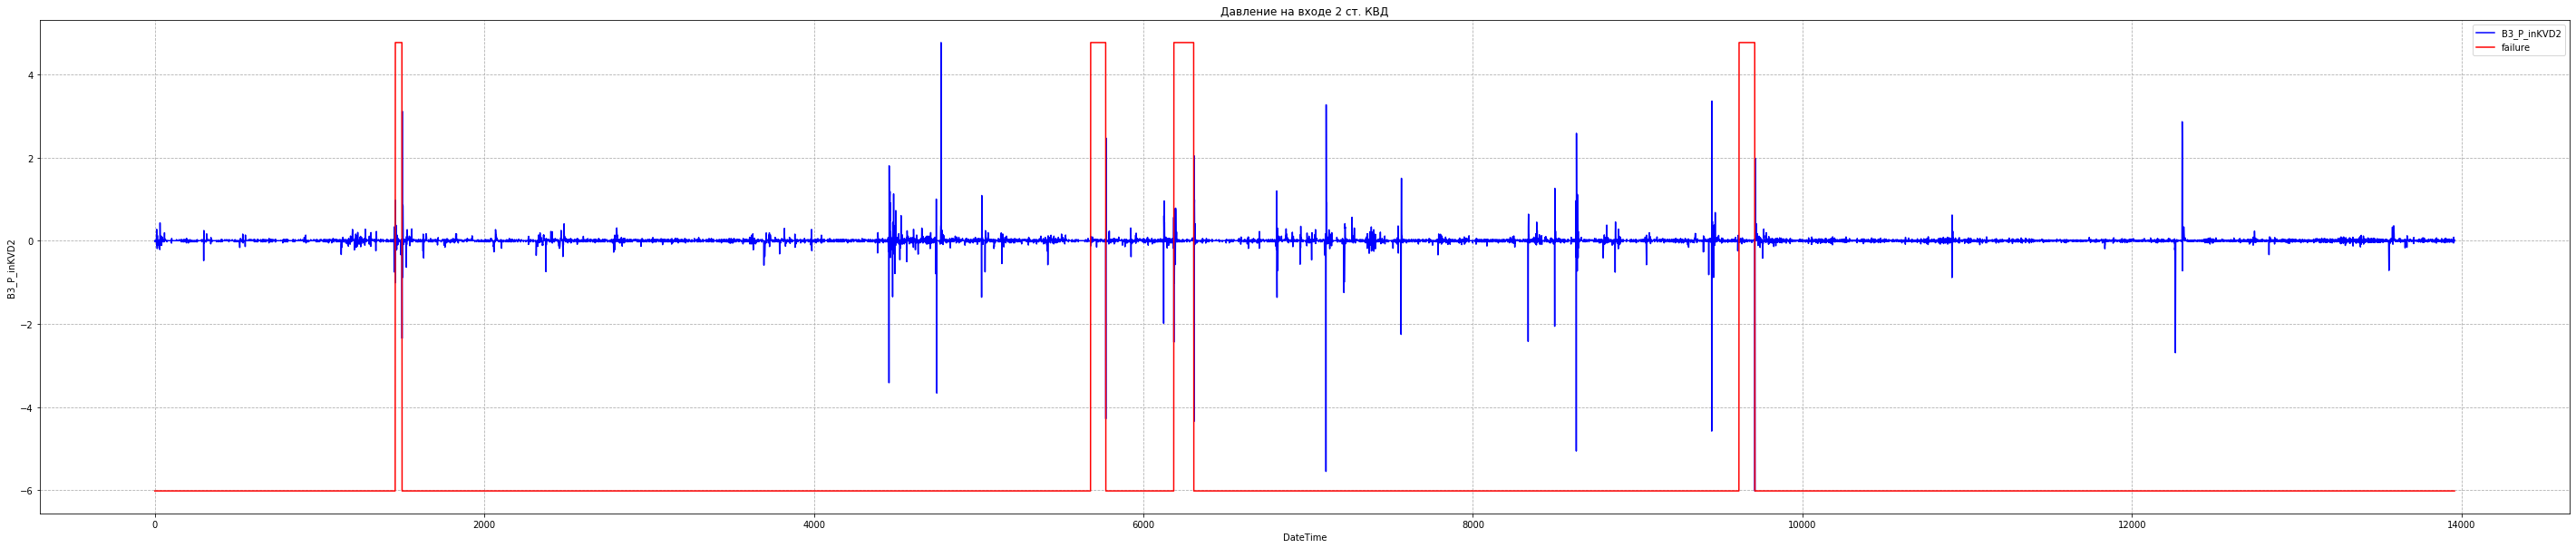

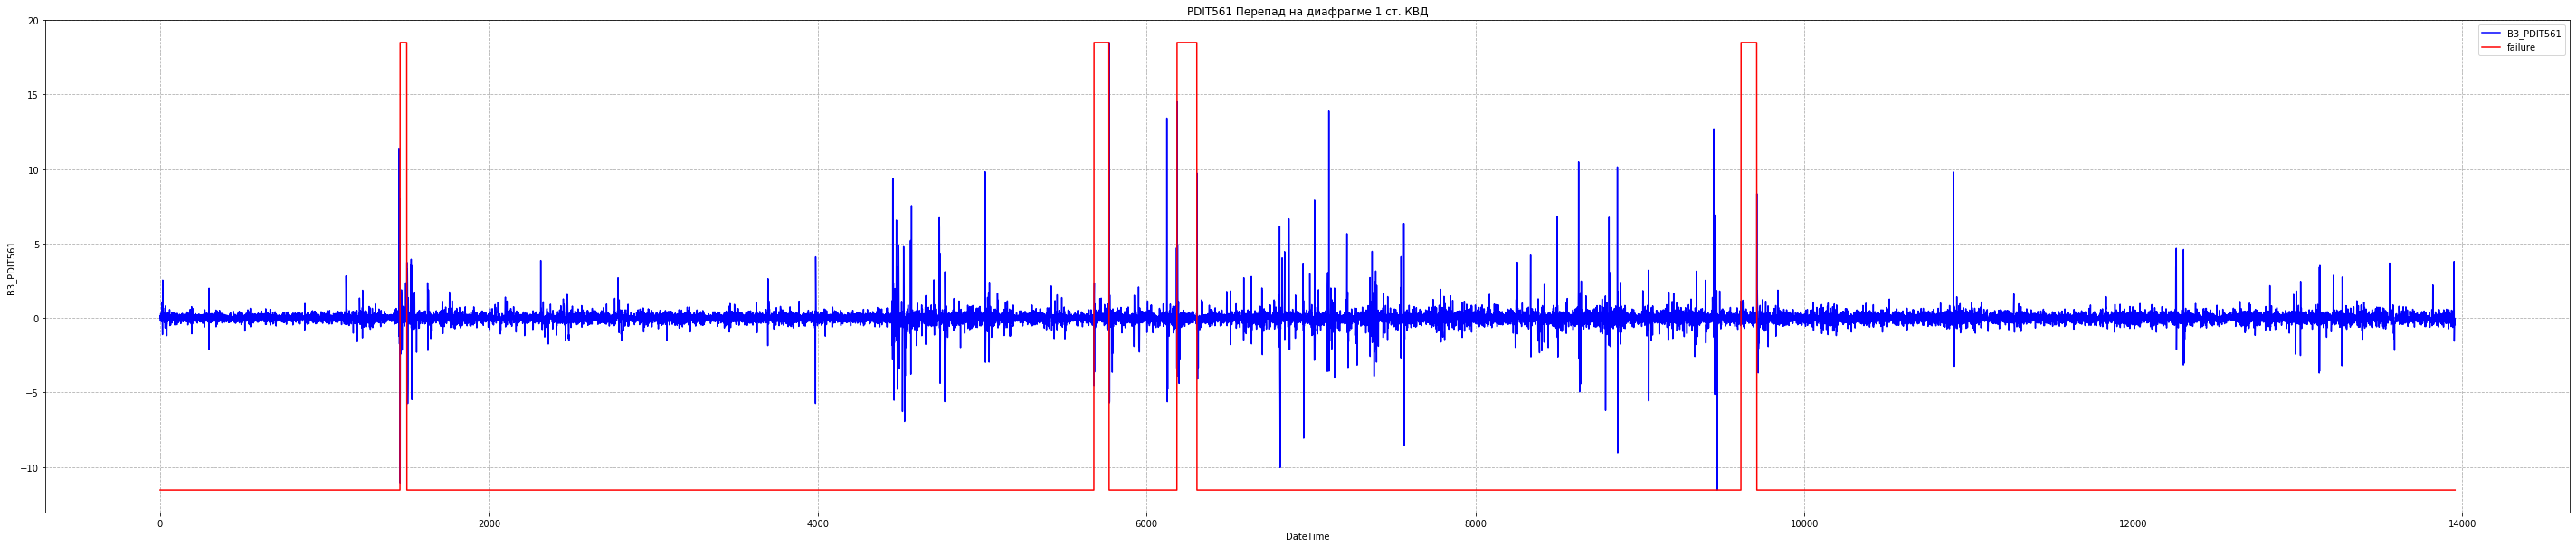

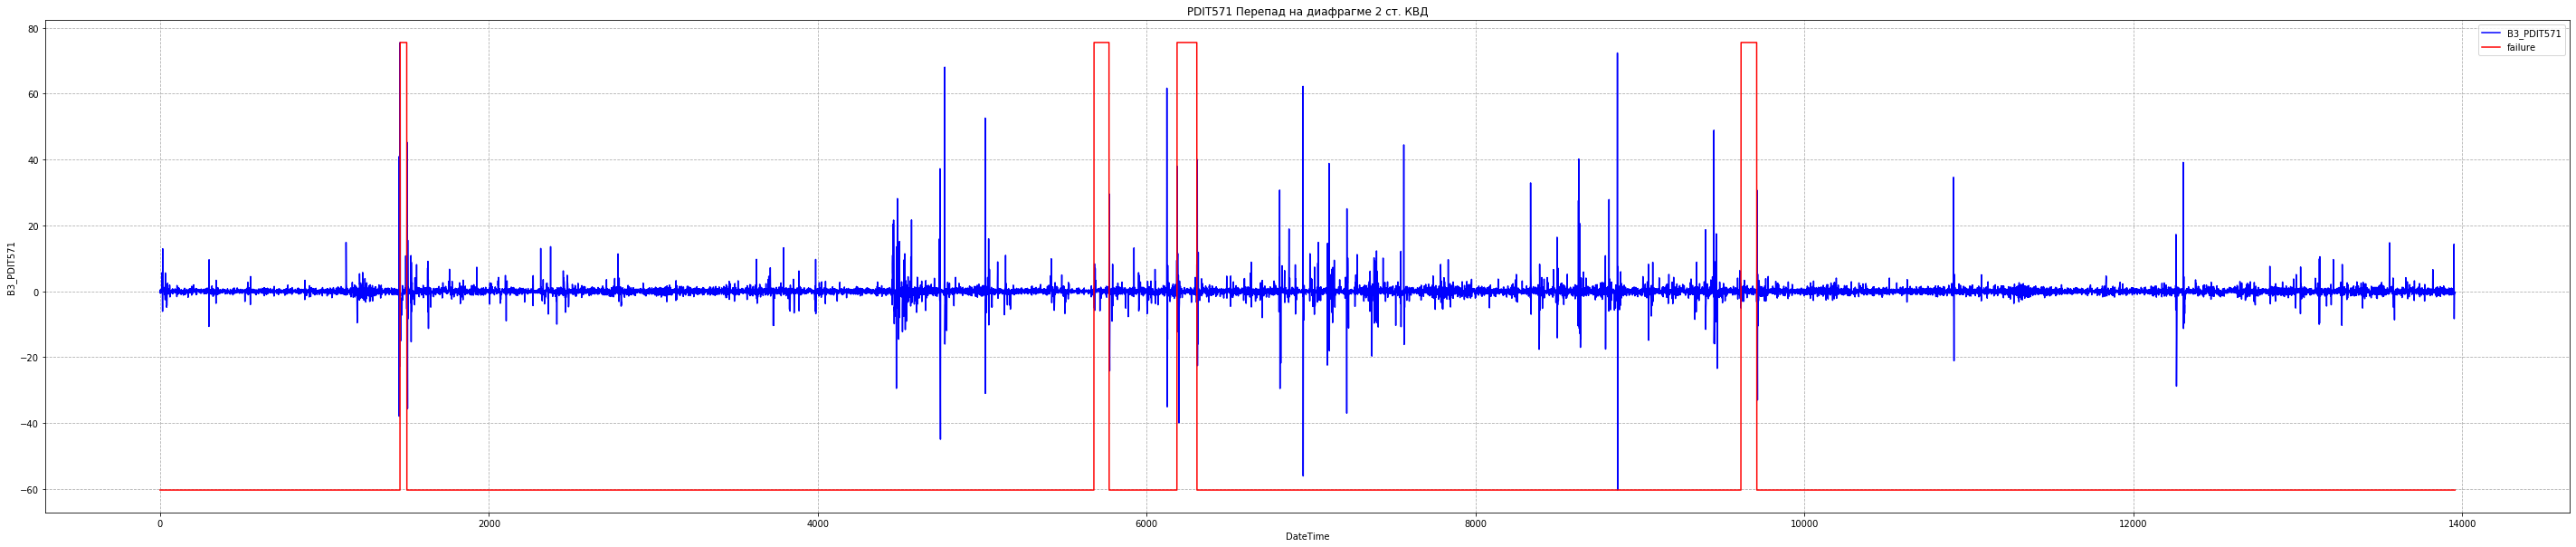

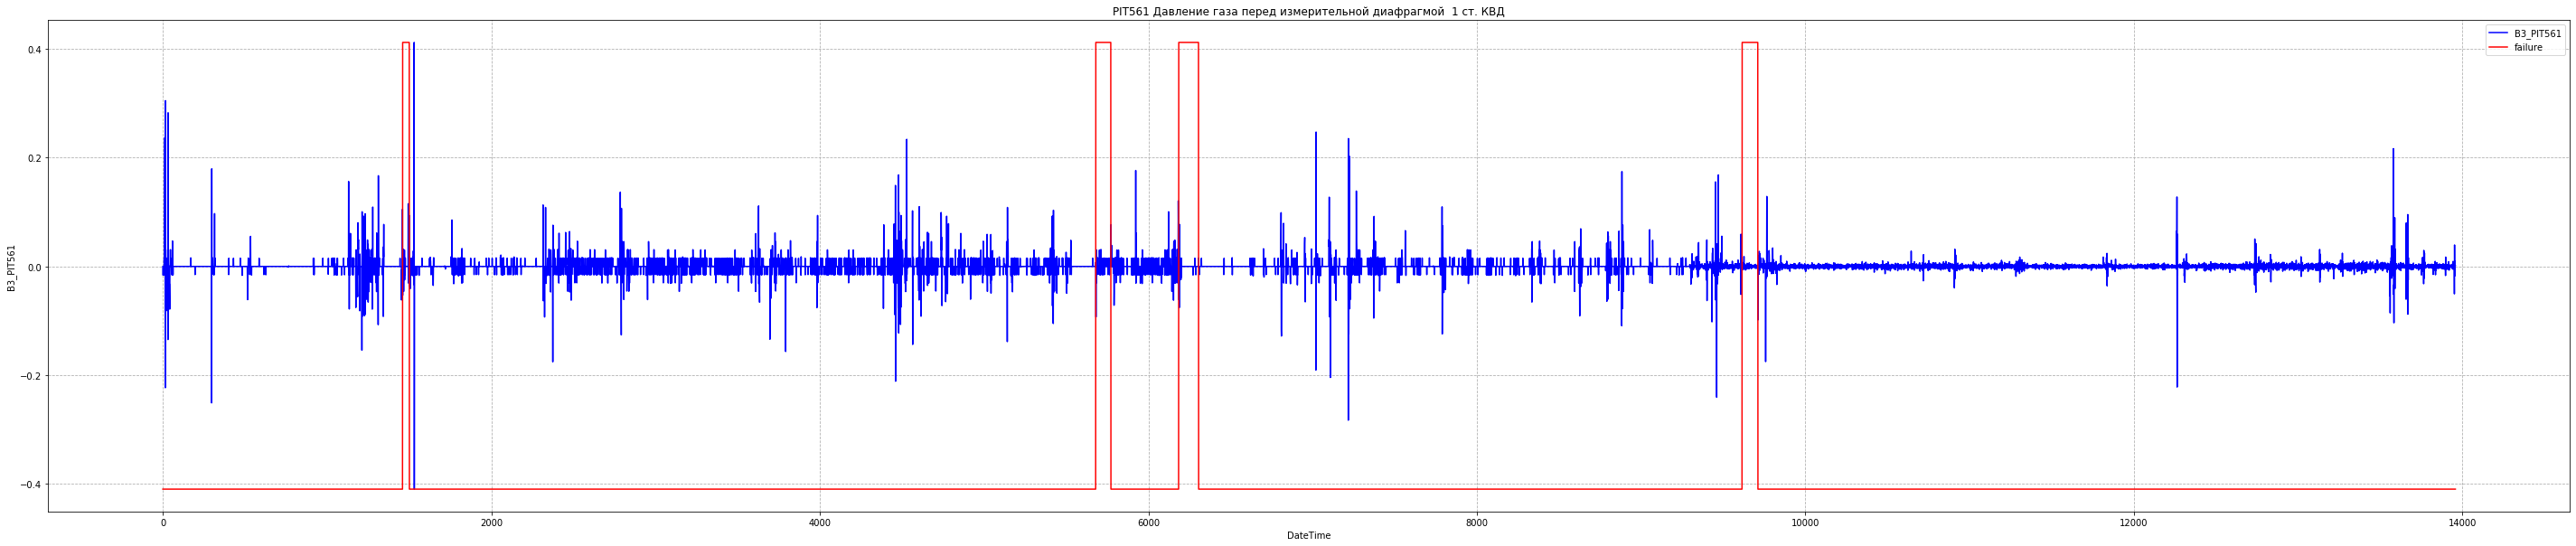

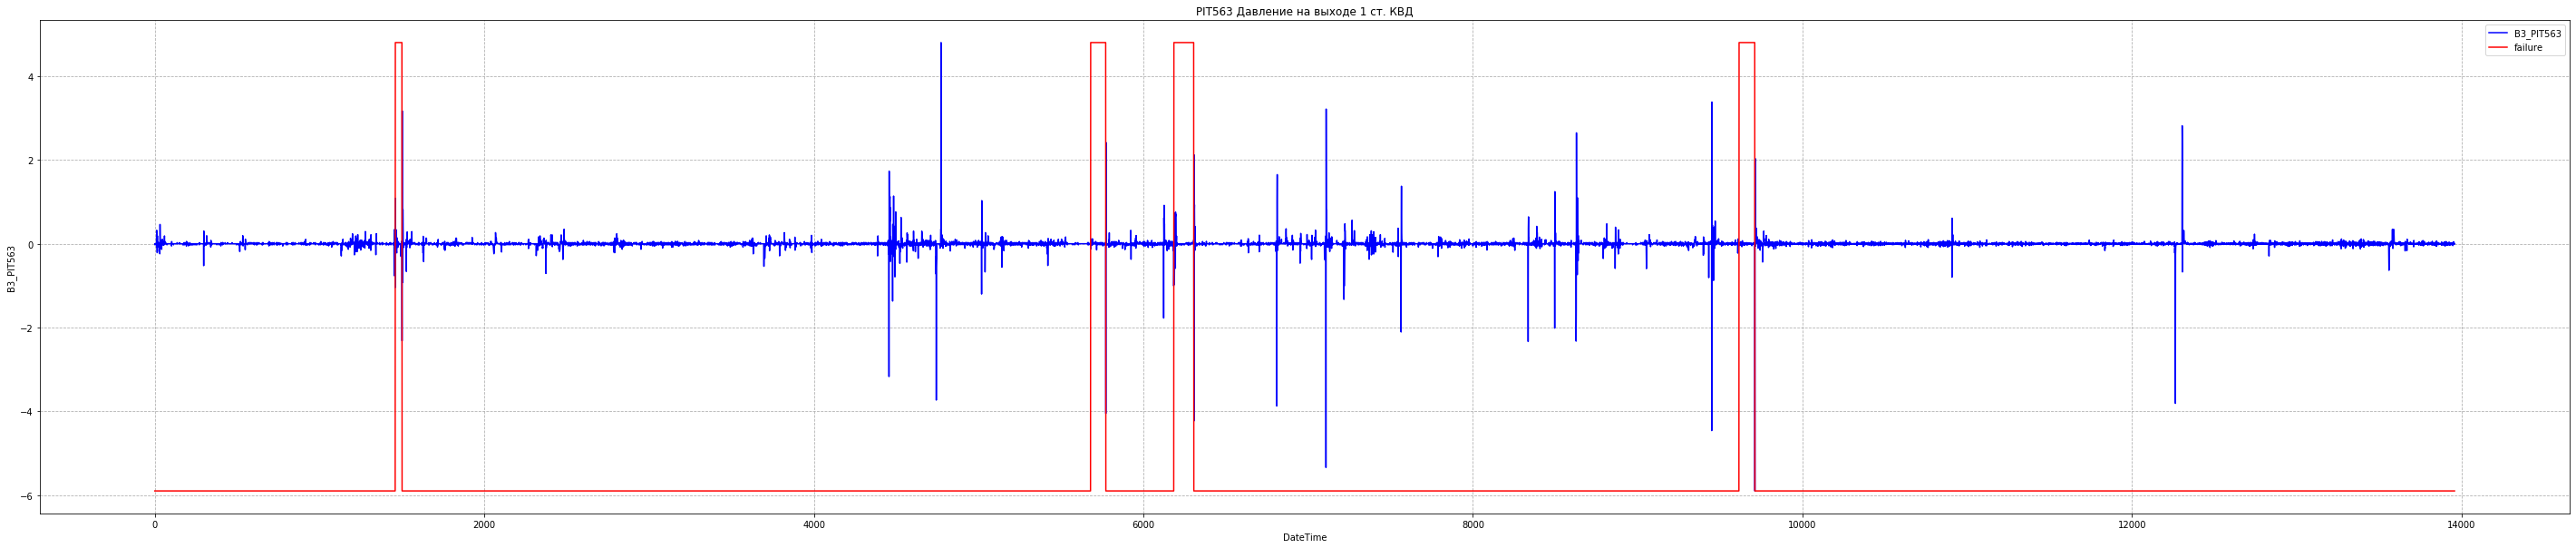

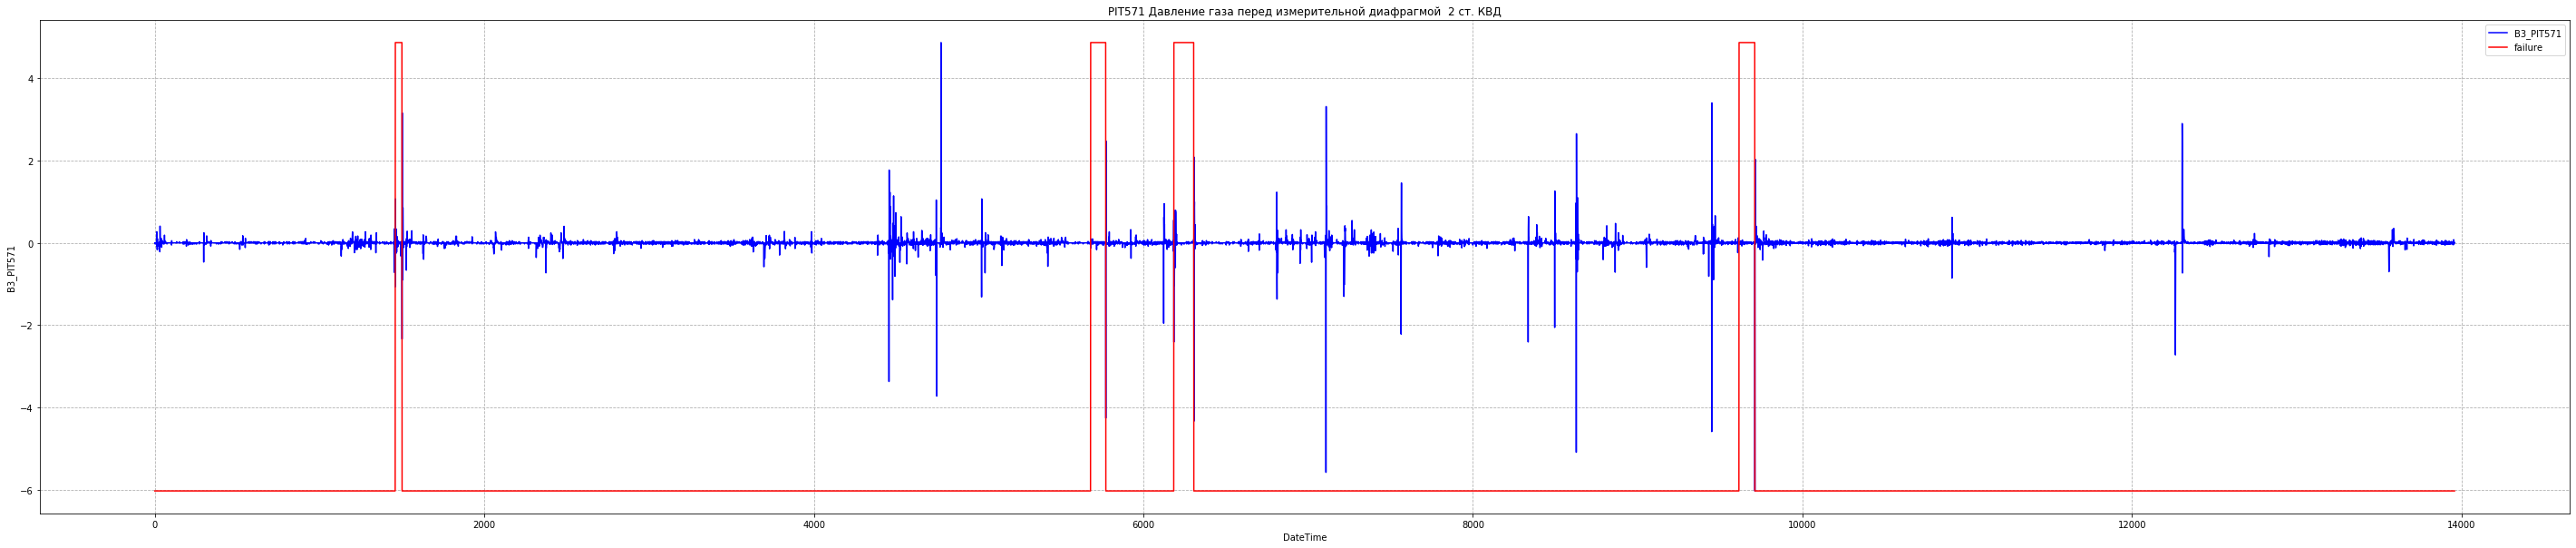

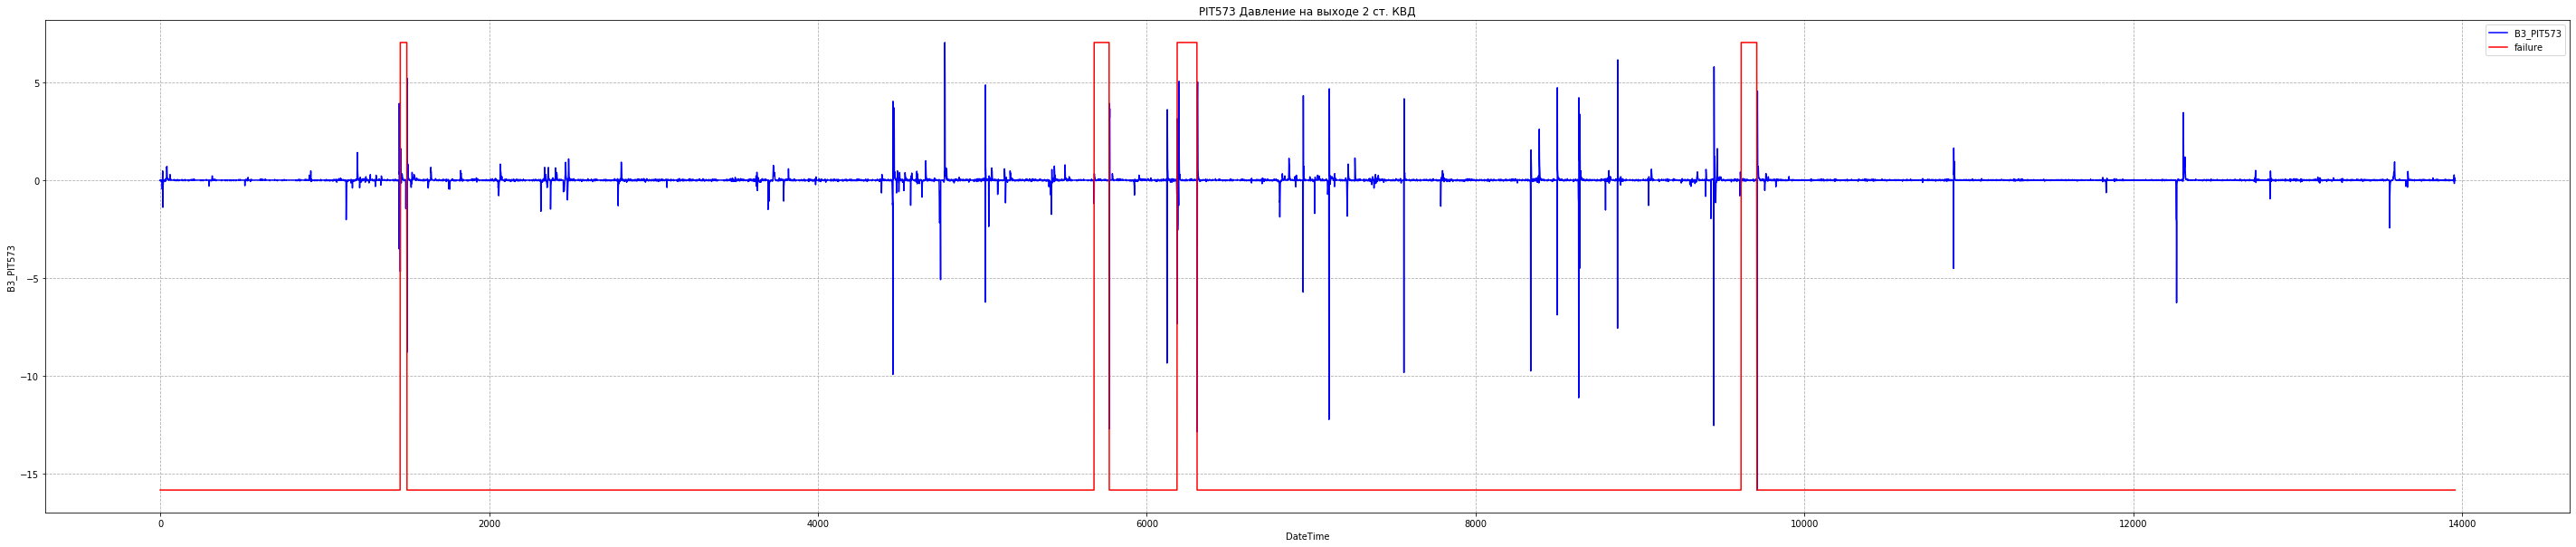

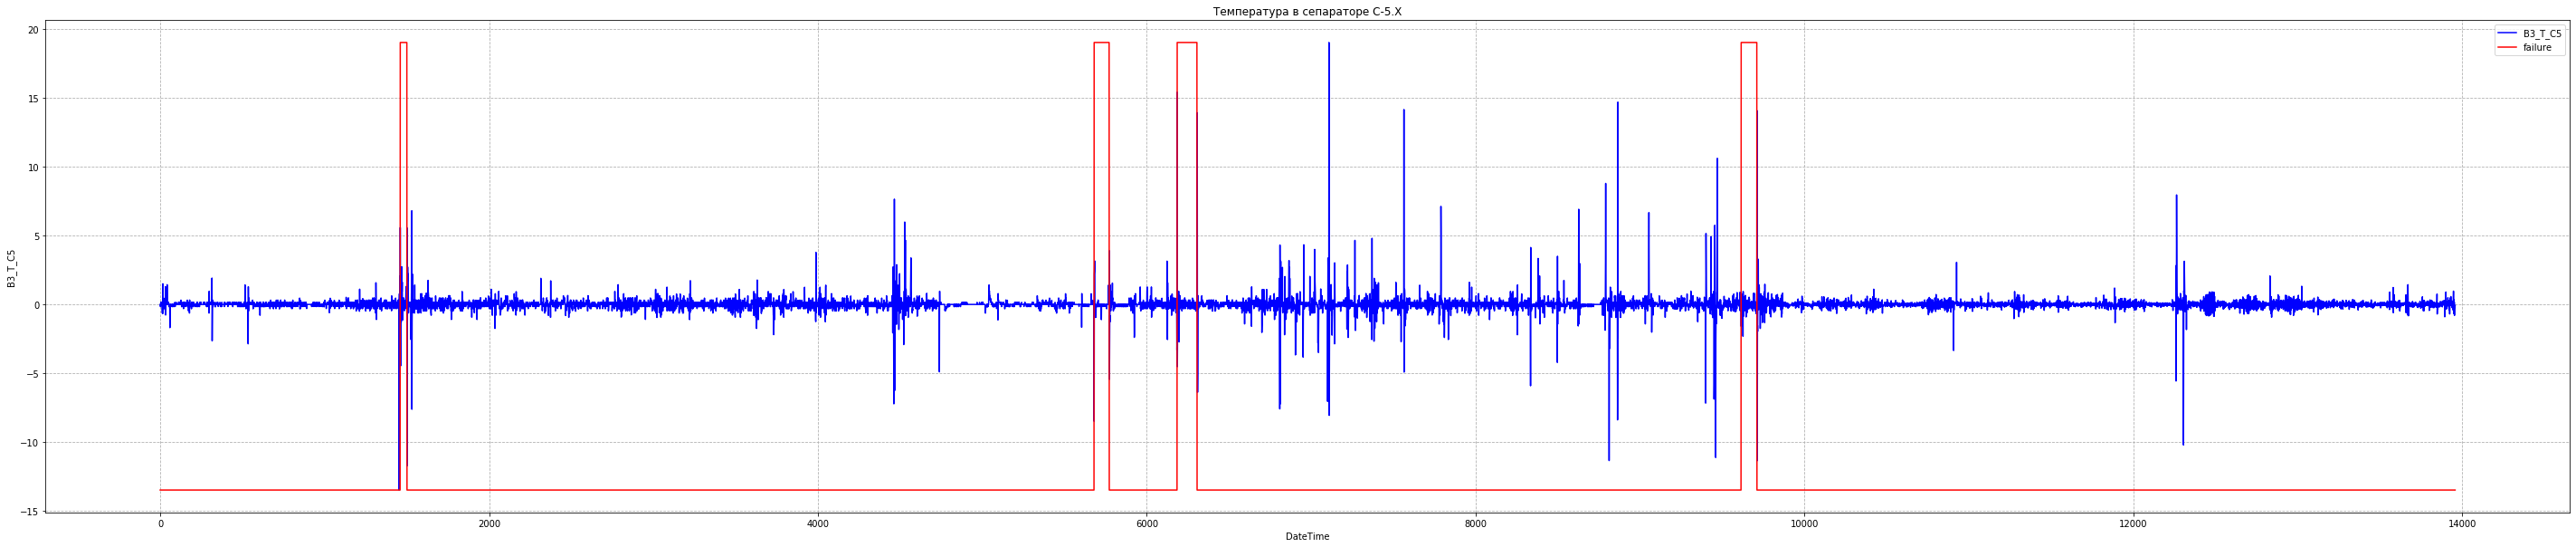

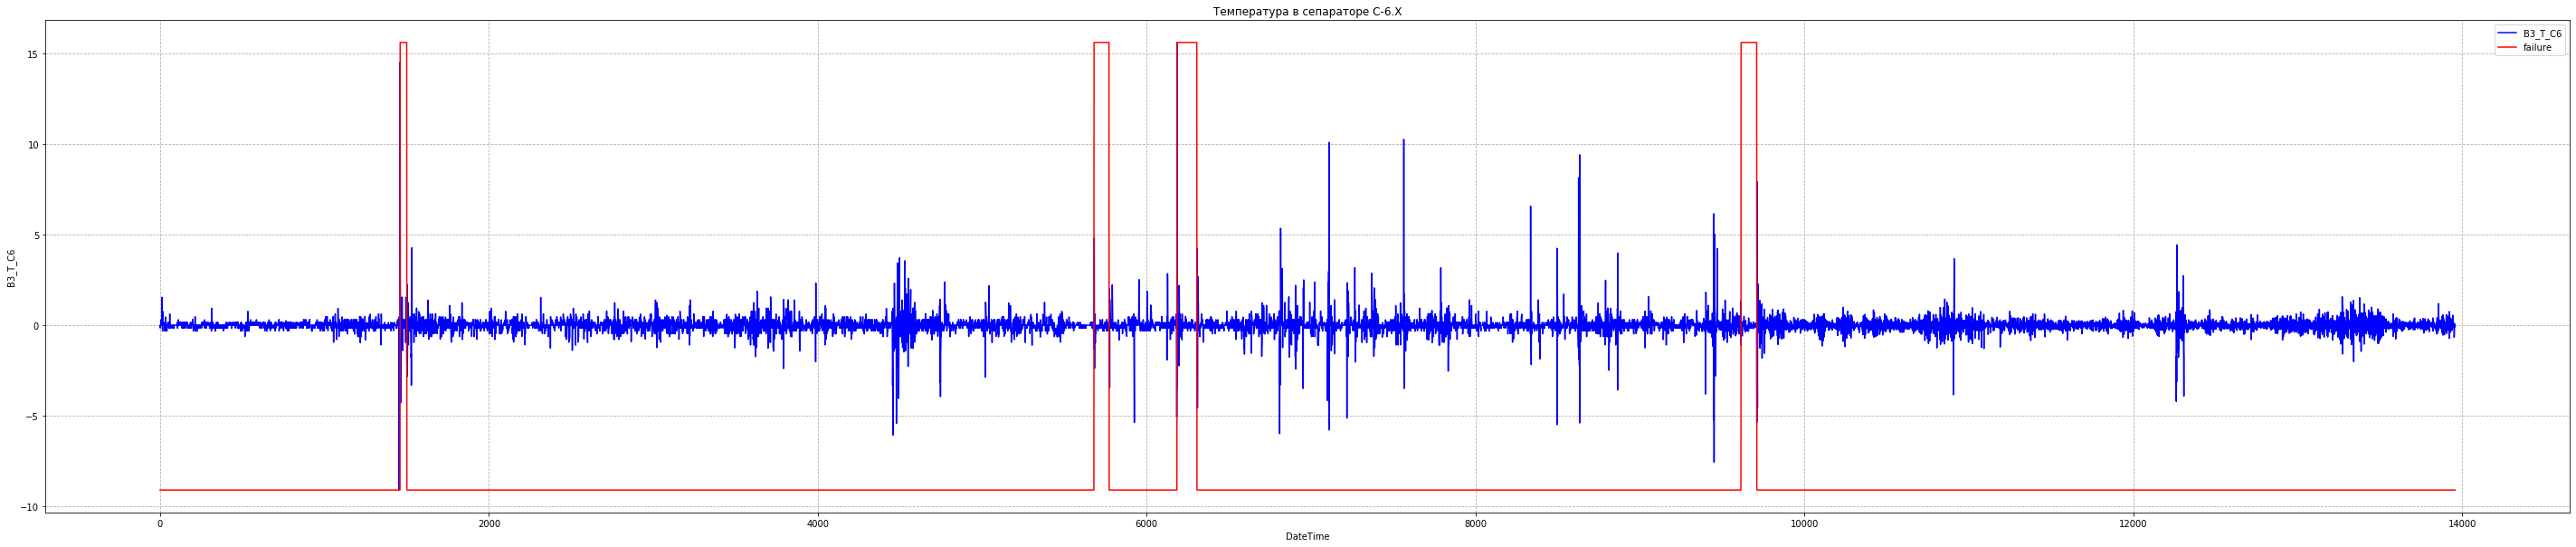

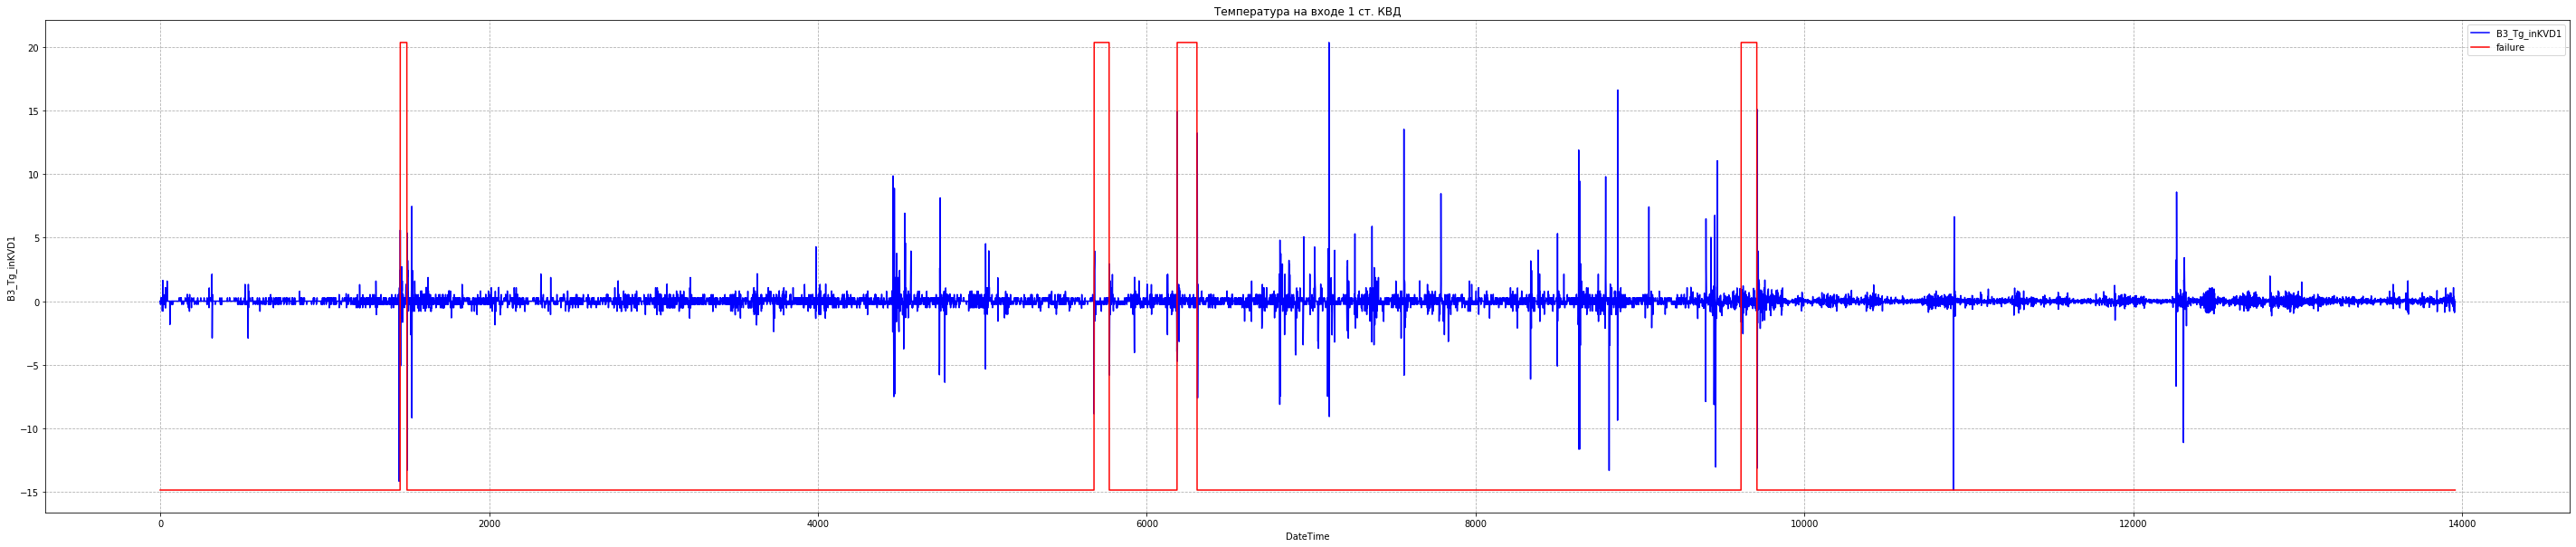

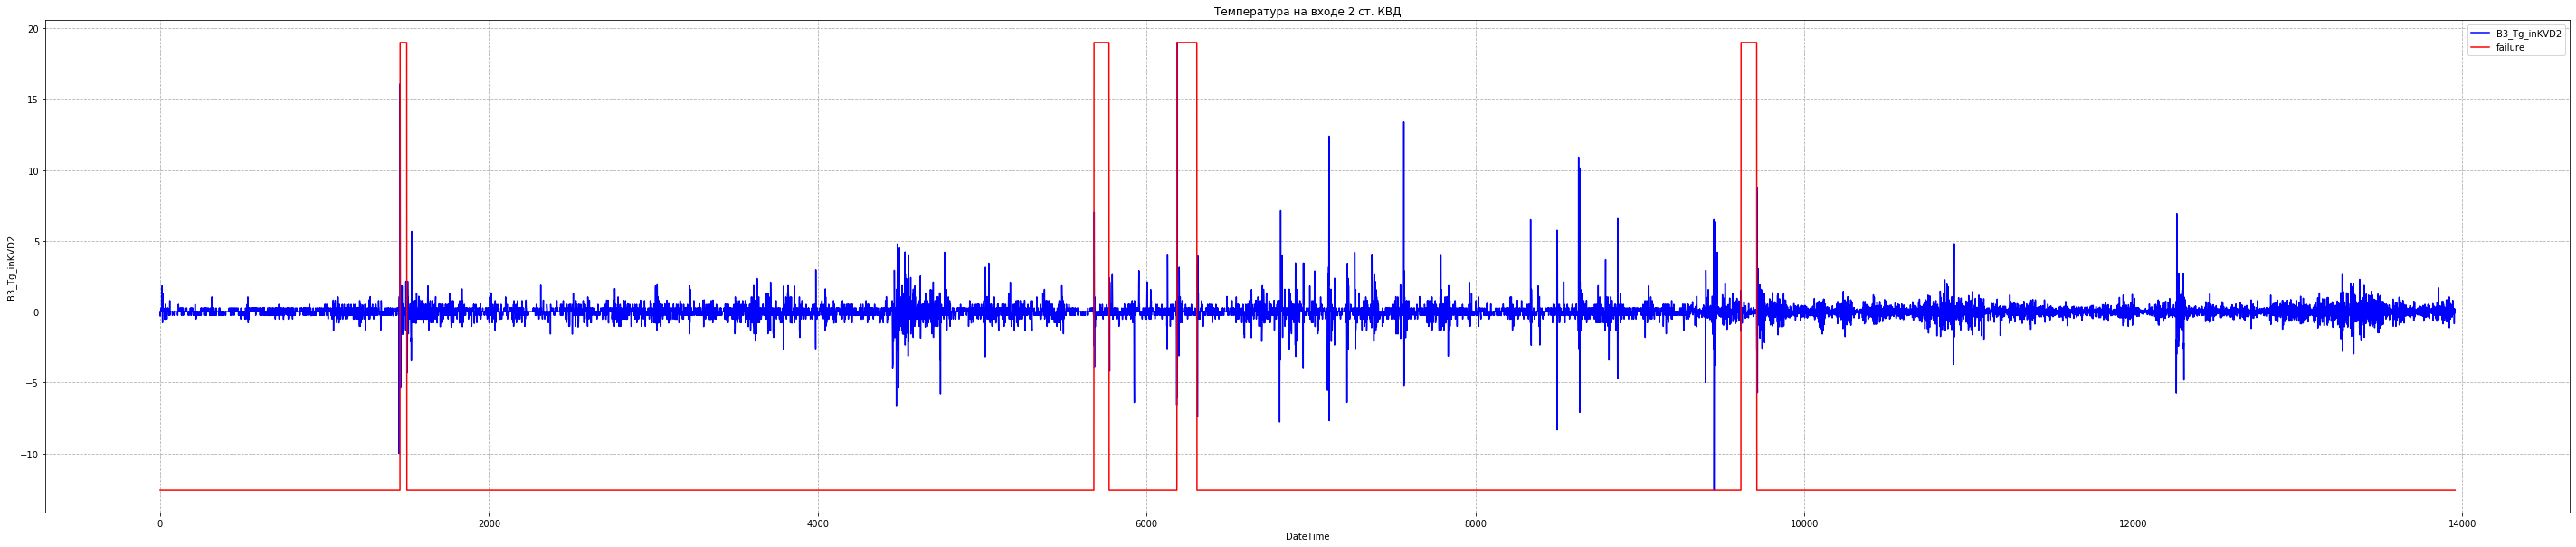

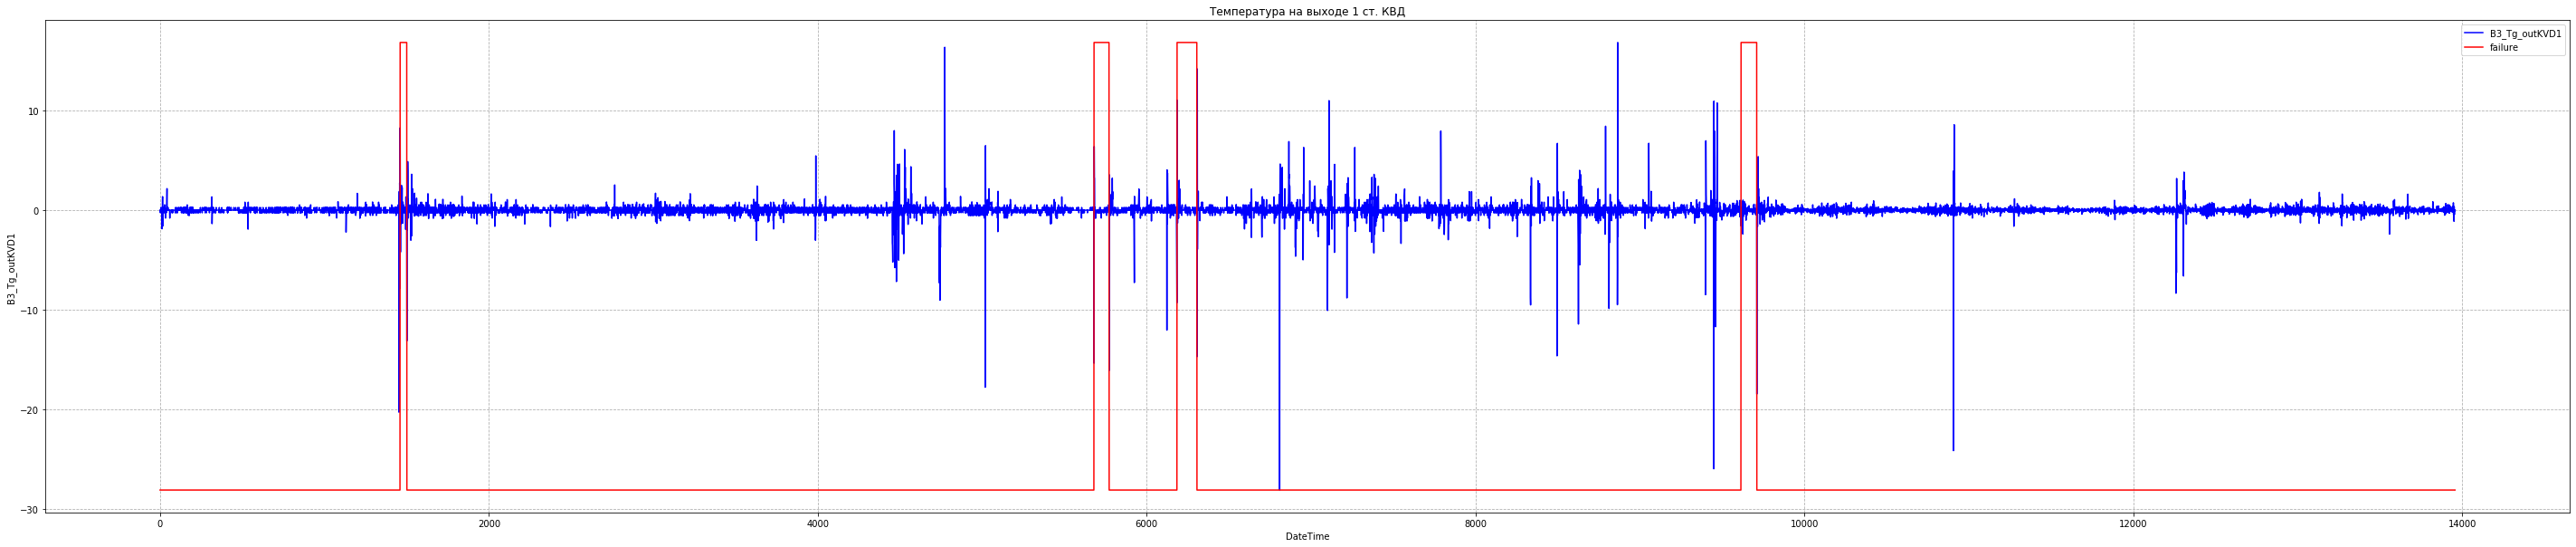

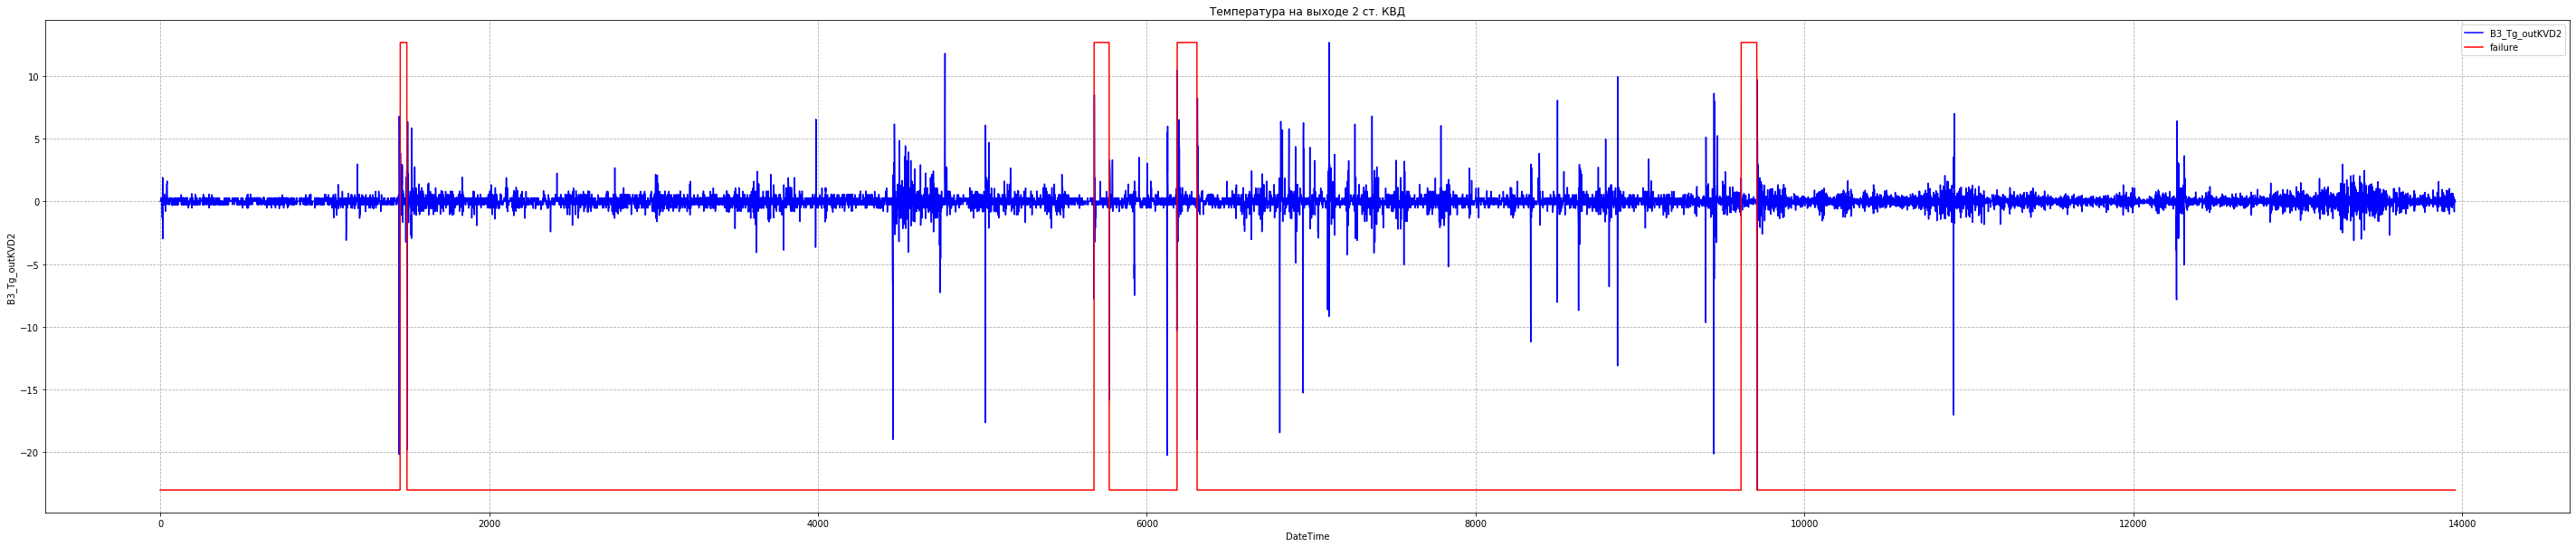

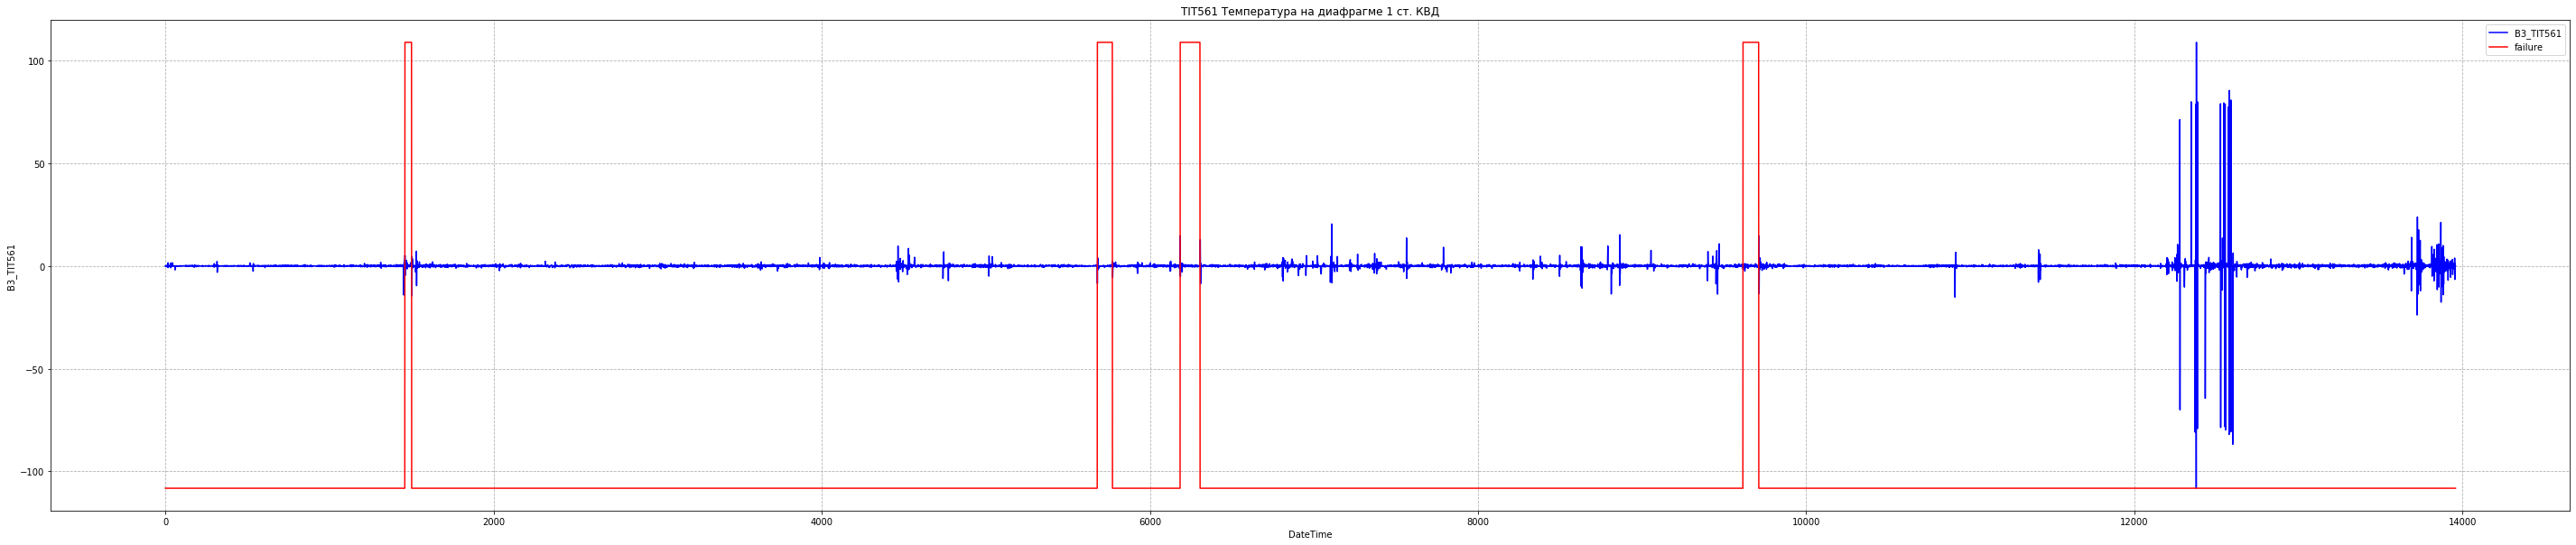

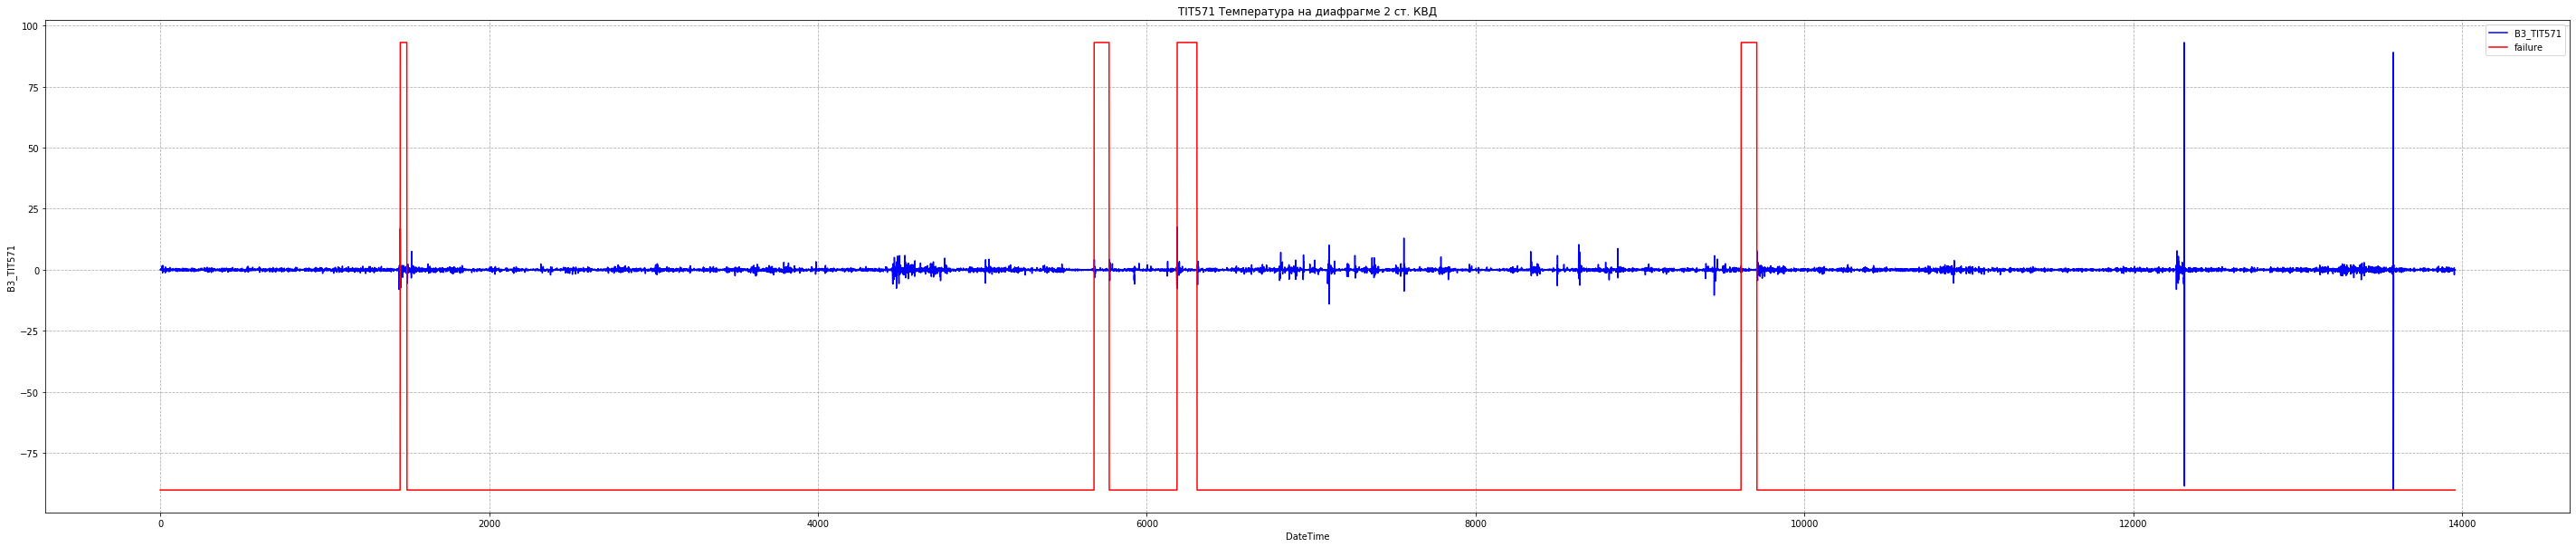

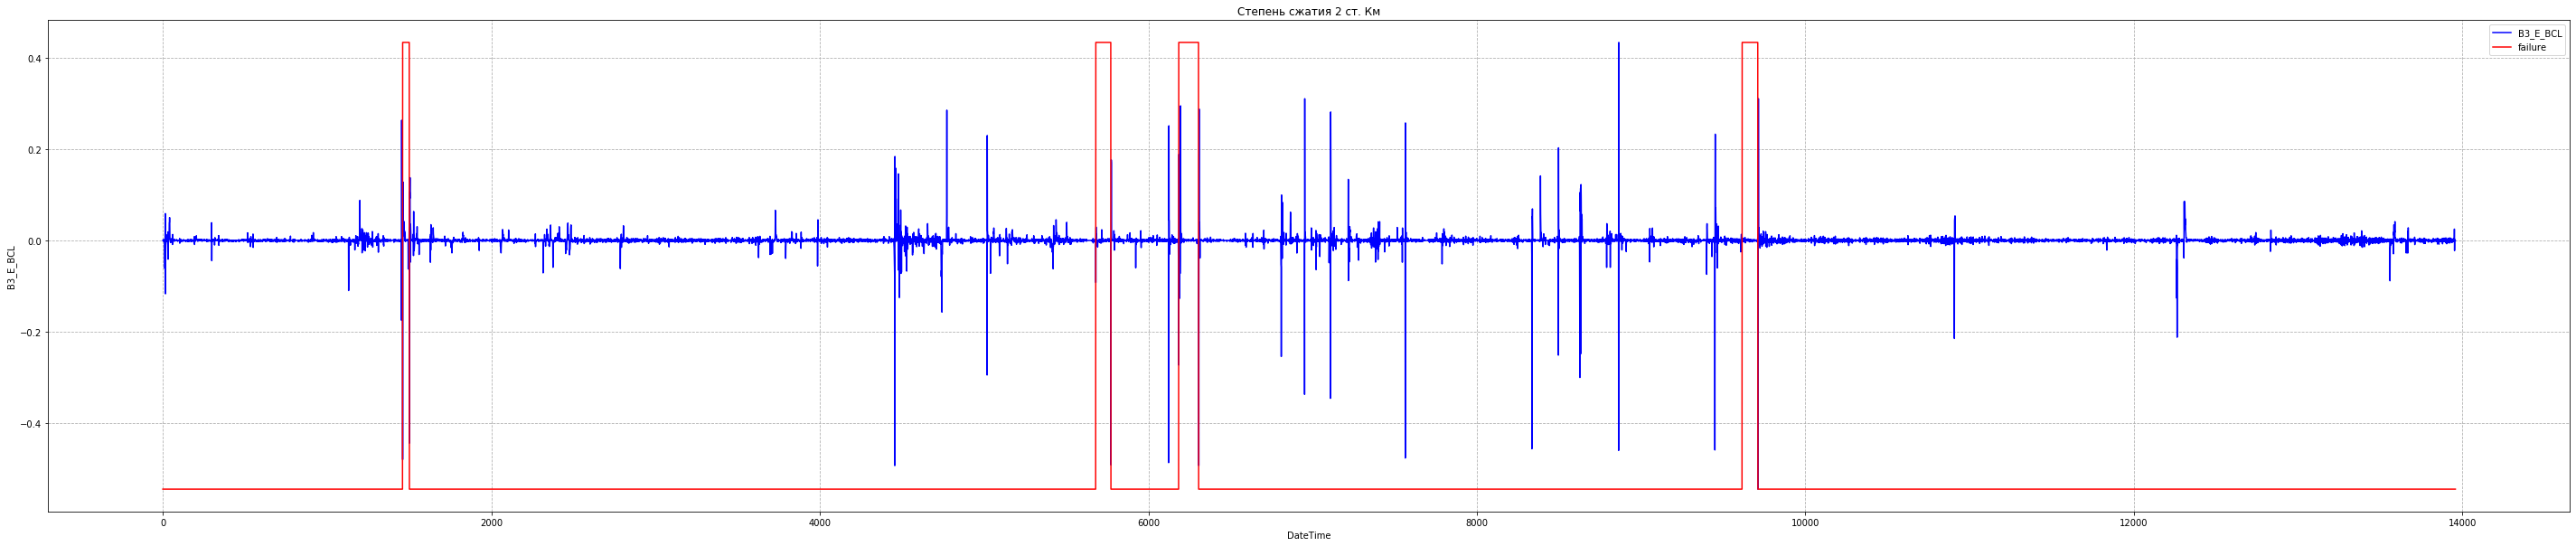

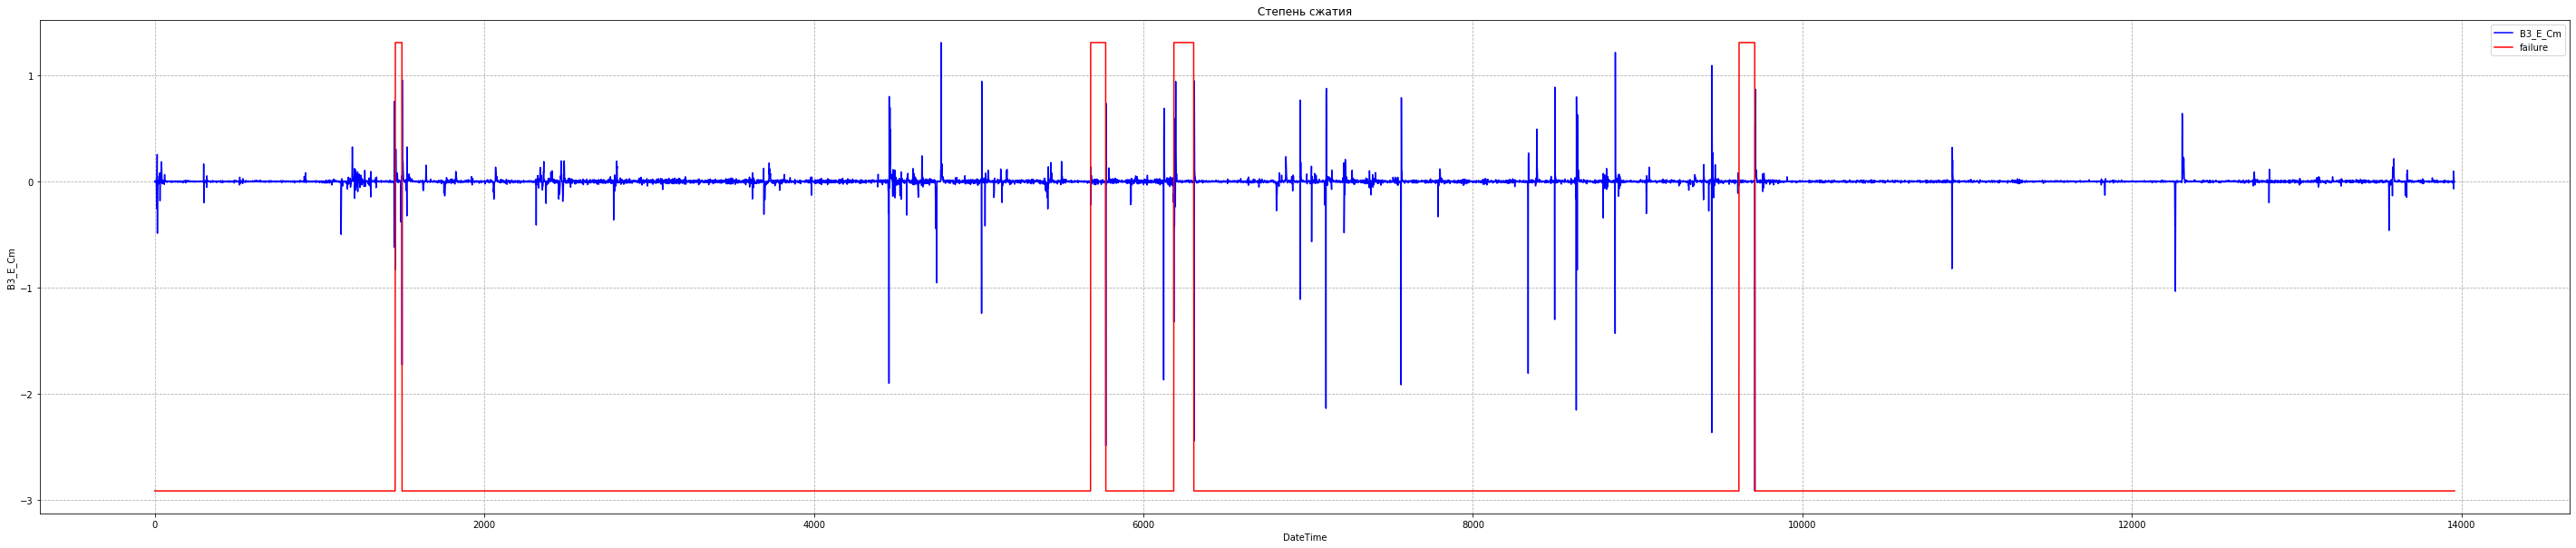

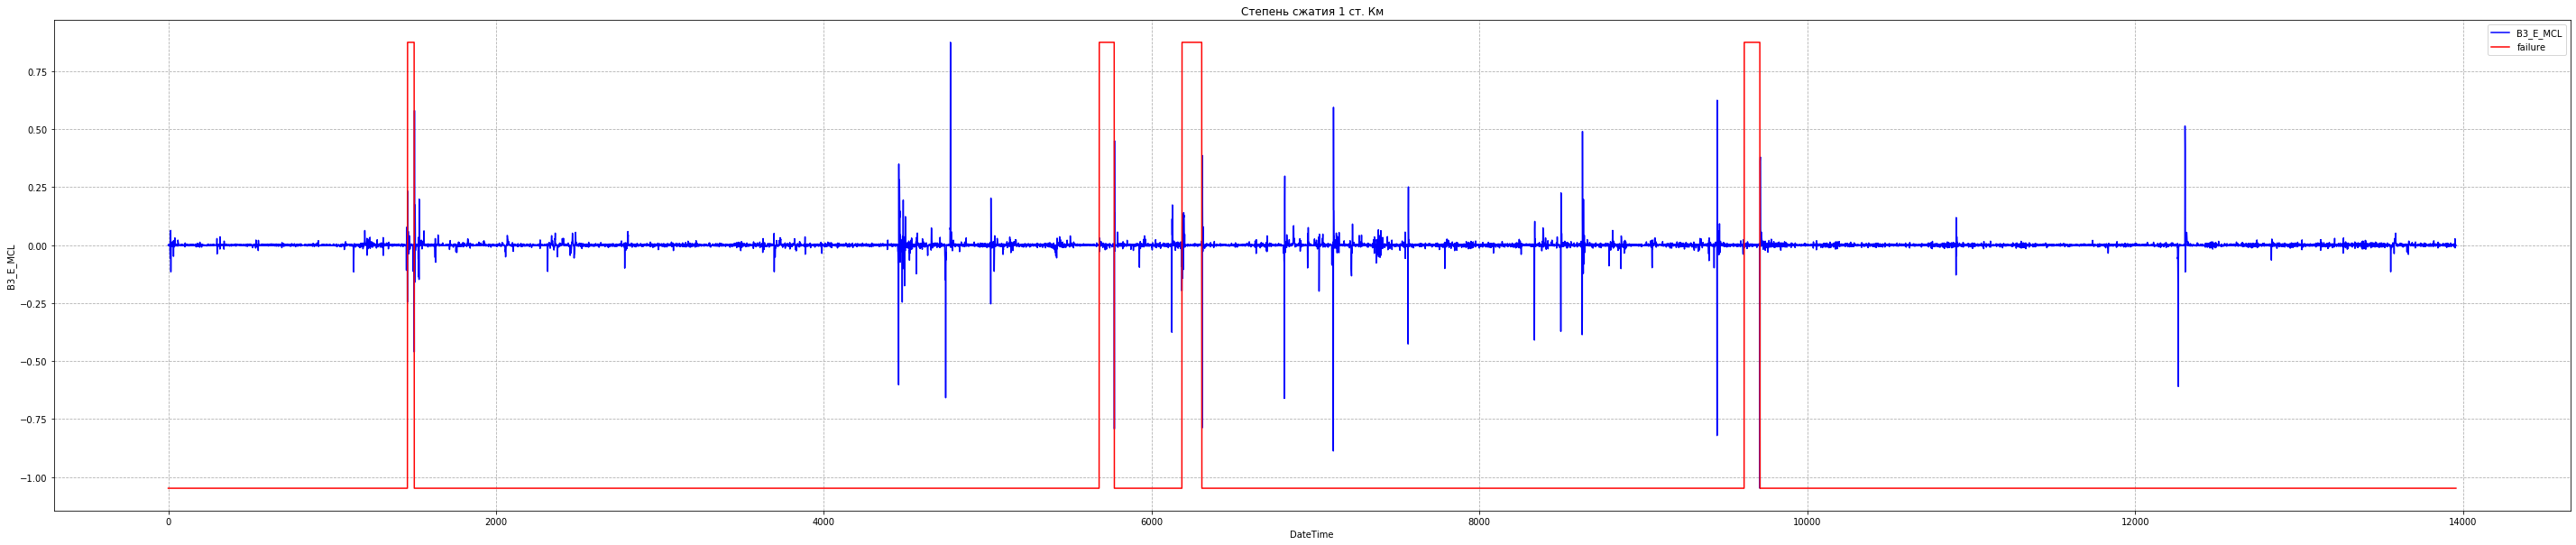

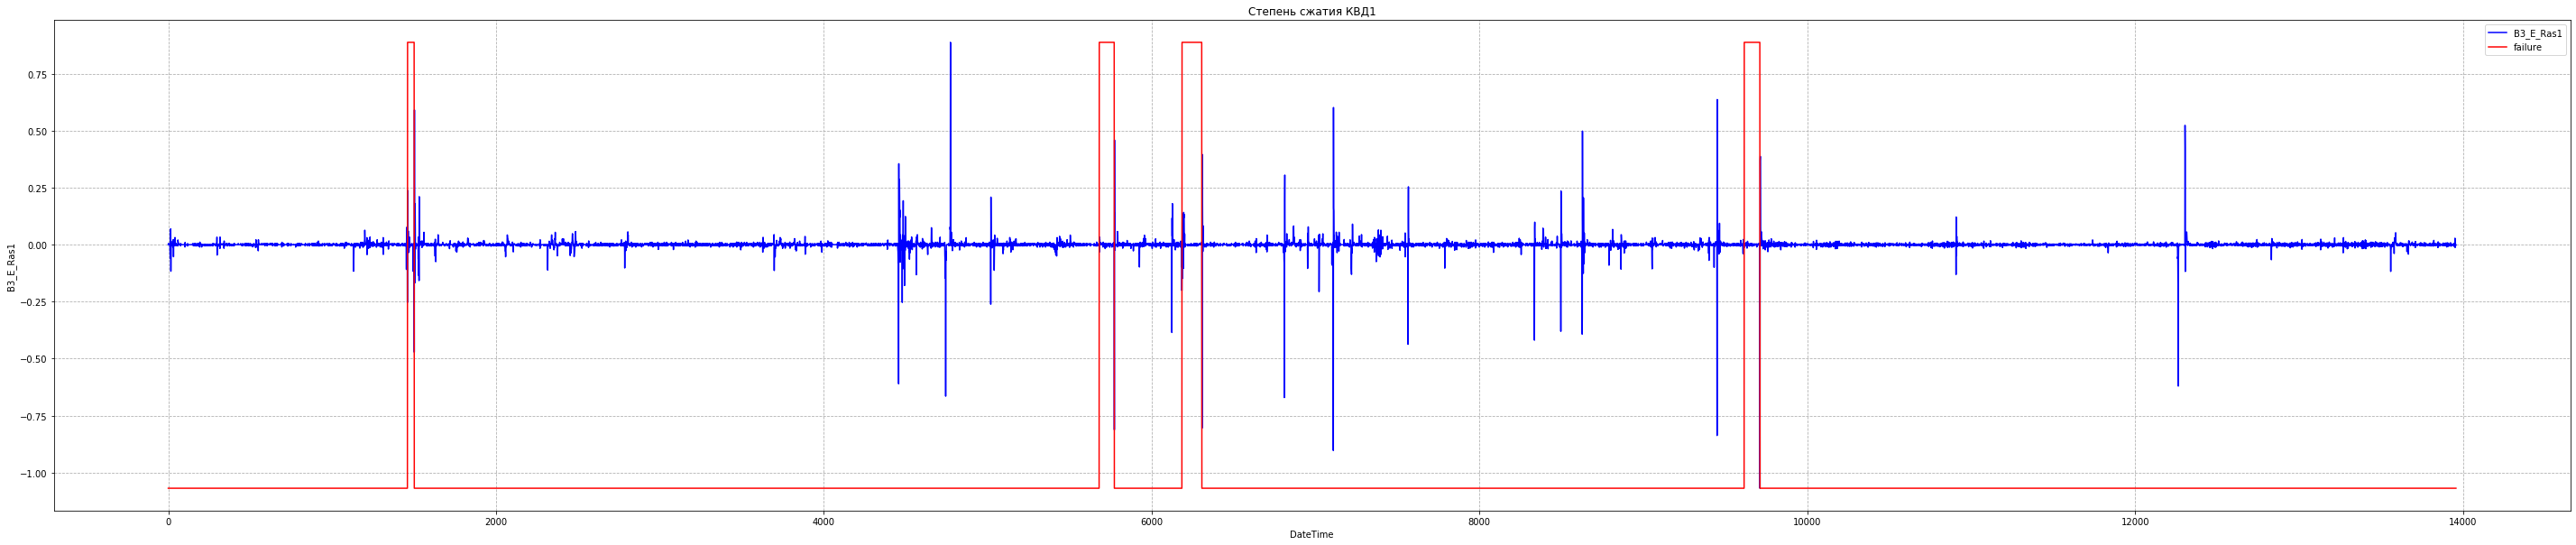

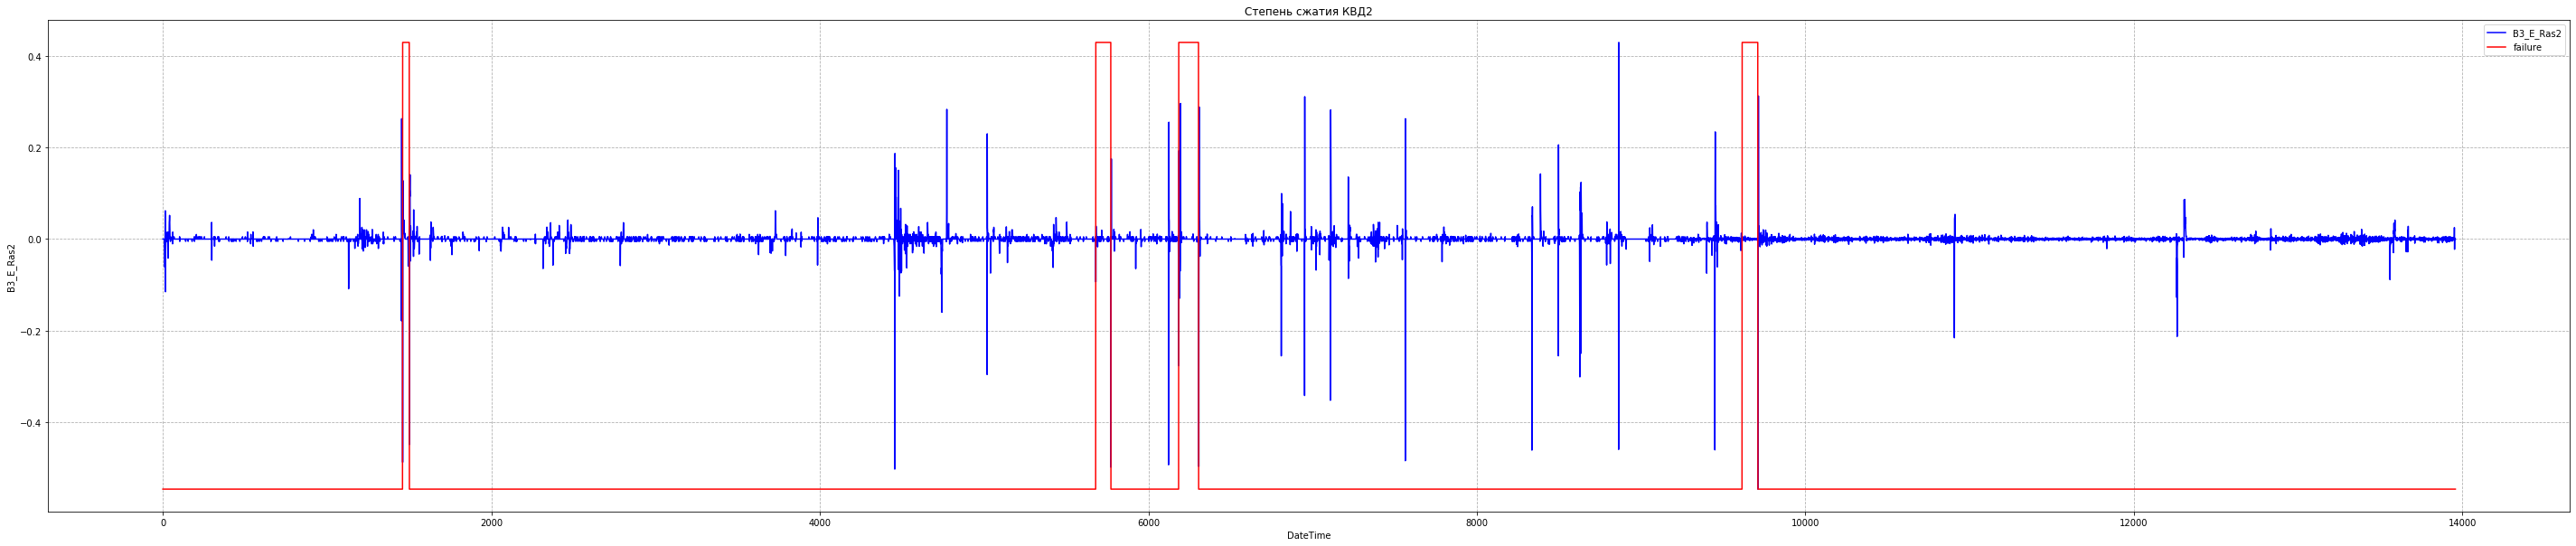

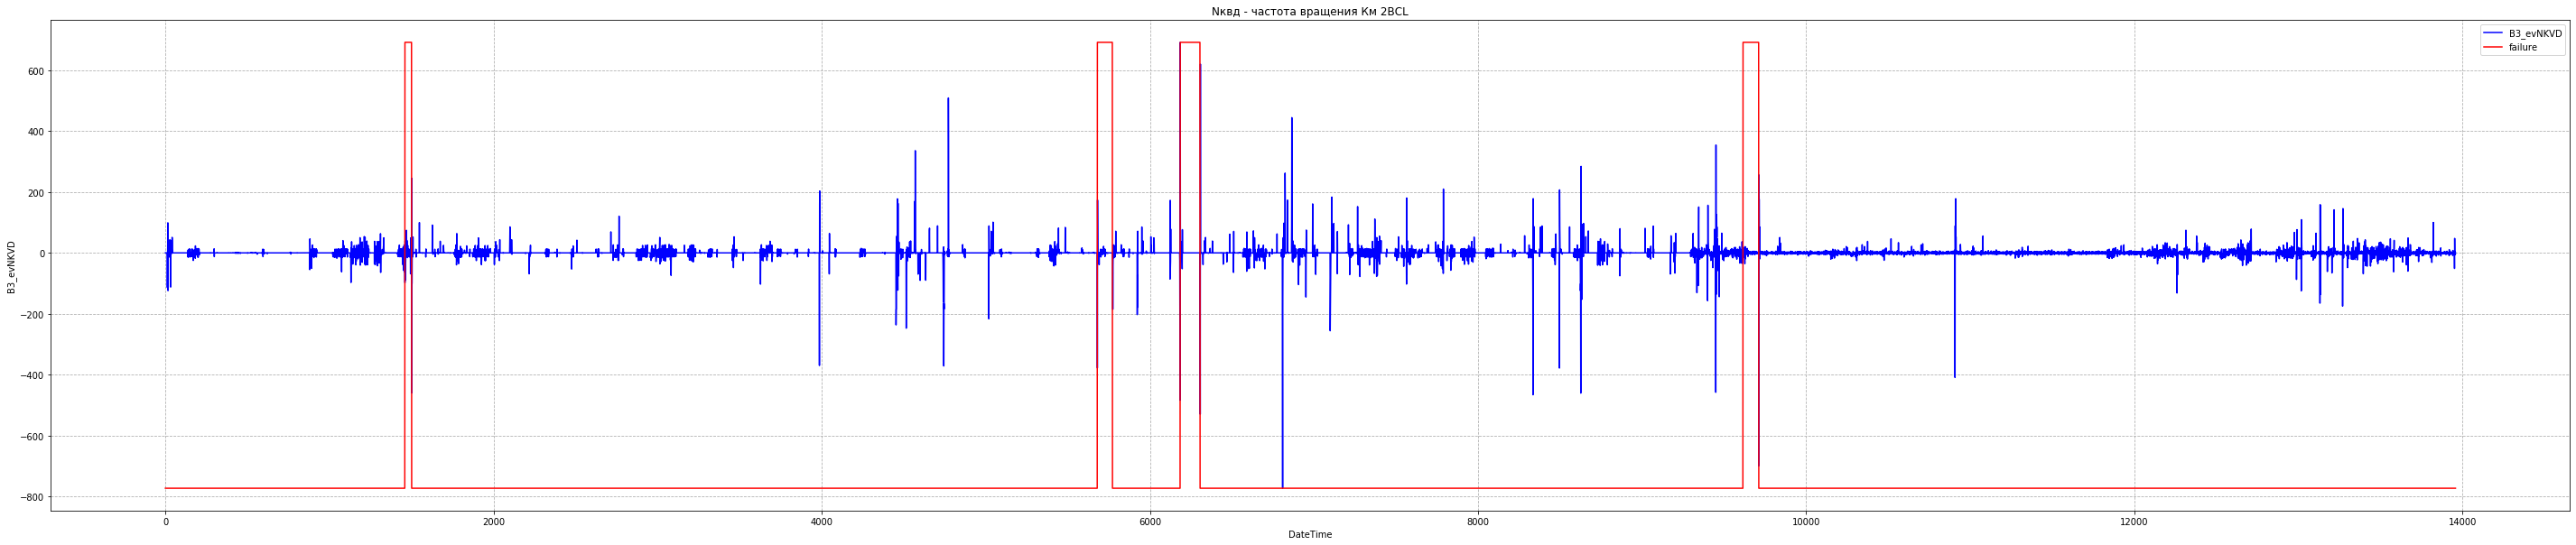

In [62]:
for col in features:

    failure_data = norm_data_relative[not_features]
    min_col = min(norm_data_relative[col])
    max_col = max(norm_data_relative[col])       
    failure_data.loc[failure_data['y']==0, 'y'] = min_col
    failure_data.loc[failure_data['y']==1, 'y'] = max_col
    
    plt.figure(figsize=(50,10)) 
    
    desc_idx = headers.loc[headers['field']==col].index[0]
    desc = headers.values[desc_idx][1]     
    plt.title(desc)
    
    plt.grid(True, linestyle='--')
    
    plt.xlabel('DateTime')
    plt.ylabel(col)
    plt.plot(norm_data_relative[col], label=col, color='blue')
    plt.plot(failure_data['y'], label='failure', color='red')
    
    plt.legend(loc=0)
    plt.show()

### Разделение на обучающую и тестовую выборки

Рассмотрим одновременно выборки с абсолютные и относительными значений показателей датчиков.

In [63]:
feature_list = norm_data.loc[:, ~norm_data.columns.isin(not_features)]
feature_list_relative = norm_data_relative.loc[:, ~norm_data_relative.columns.isin(not_features)]

target = norm_data['y']

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(feature_list, target, test_size=0.3, random_state=None)

In [65]:
X_train_relative, X_test_relative, Y_train_relative, Y_test_relative = train_test_split(feature_list_relative, target, test_size=0.3, random_state=None)

In [66]:
columns = X_train.columns

### Нормирование значений атрибутов

Абсолютные значения

In [67]:
scaler = StandardScaler()

In [68]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [69]:
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns=columns)

In [70]:
X_test = scaler.transform(X_test)

Относительные значения

In [72]:
scaler_relative = StandardScaler()

In [73]:
scaler_relative.fit(X_train_relative)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [74]:
X_train_relative = scaler_relative.transform(X_train_relative)
X_train_relative = pd.DataFrame(X_train_relative, columns=columns)

In [75]:
X_test_relative = scaler_relative.transform(X_test_relative)

## Обучение модели

In [76]:
model = LogisticRegression(max_iter=5000, n_jobs=-1)
model.fit(X_train, Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [77]:
model_relative = LogisticRegression(max_iter=5000, n_jobs=-1)
model_relative.fit(X_train_relative, Y_train_relative)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## Предсказание

In [78]:
predictions = model.predict_proba(X_test)
predictions_relative = model_relative.predict_proba(X_test_relative)

Абсолютные значения

In [79]:
model.score(X_train, Y_train)

0.9759467758444217

In [80]:
model.score(X_test, Y_test)

0.9713467048710601

Относительные значения

In [81]:
model_relative.score(X_train_relative, Y_train_relative)

0.97482088024565

In [82]:
model_relative.score(X_test_relative, Y_test_relative)

0.9751671442215855

## Оценка качества модели

### Матрица ошибок

In [88]:
beta = 0.5

In [92]:
def confusion_matrix(predictions, Y_test):
    '''
    Функция генерации матрицы ошибок.
    На вход подаются предсказанные значения целевой переменной и реальные значения.
    '''
       
    tp = 0 # True positive
    fp = 0 # False positive
    fn = 0 # False negative
    tn = 0 # True negative

    for predicted_prob, actual in zip(predictions[:, 1], Y_test):
        if predicted_prob > beta:
            predicted = 1
        else:
            predicted = 0

        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1
        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
    
    #Расчет метрик качества
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
    true_positive_rate = tp / (tp + fn)
    false_positive_rate = fp / (fp + tn)
            
    #Матрица ошибок
    print('--------------------------------------------')
    print('Confusion Matrix')
    print('--------------------------------------------')
    print('                  ', 'Actual positive', 'Actual negative')
    print('Predicted positive      ', tp,'             ', fp) 
    print('Predicted negative      ', fn,'             ', tn)
    print('--------------------------------------------')
    print('Total observations: ', tp+fn+fp+tn)
    print('Accuracy:            {:.2%}'.format(accuracy))
    print()
    print('True positive:      ', tp)
    print('True negative:      ', tn)
    print('False positive:     ', fp)
    print('False negative:     ', fn)
    print()
    print('True positive rate:  {:.2%}'.format(true_positive_rate))
    print('False positive rate: {:.2%}'.format(false_positive_rate))
    print()
    print('Recall:              {:.2%}'.format(recall))
    print('Precision:           {:.2%}'.format(precision))
    print('F1 score:            {:.2%}'.format(f1_score))
    print('--------------------------------------------')

In [86]:
def short_confusion_matrix(predictions, Y_test):
    '''
    Функция генерации матрицы ошибок.
    На вход подаются предсказанные значения целевой переменной и реальные значения.
    '''
       
    tp = 0 # True positive
    fp = 0 # False positive
    fn = 0 # False negative
    tn = 0 # True negative

    for predicted_prob, actual in zip(predictions[:, 1], Y_test):
        if predicted_prob > beta:
            predicted = 1
        else:
            predicted = 0

        if predicted == 1:
            if actual == 1:
                tp += 1
            else:
                fp += 1
        else:
            if actual == 1:
                fn += 1
            else:
                tn += 1
    
    #Расчет метрик качества
    accuracy = (tp + tn) / (tp + fp + fn + tn)
            
    #Матрица ошибок
    print('--------------------------------------------')
    print('Confusion Matrix')
    print('--------------------------------------------')
    print('                  ', 'Actual positive', 'Actual negative')
    print('Predicted positive      ', tp,'             ', fp) 
    print('Predicted negative      ', fn,'             ', tn)
    print('--------------------------------------------')
    print('Total observations: ', tp+fn+fp+tn)
    print('Accuracy:            {:.2%}'.format(accuracy))
    print()
    print('True positive:      ', tp)
    print('True negative:      ', tn)
    print('False positive:     ', fp)
    print('False negative:     ', fn)
    print('--------------------------------------------')

Абсолютные значения

In [93]:
confusion_matrix(predictions, Y_test)

--------------------------------------------
Confusion Matrix
--------------------------------------------
                   Actual positive Actual negative
Predicted positive       3               3
Predicted negative       117               4065
--------------------------------------------
Total observations:  4188
Accuracy:            97.13%

True positive:       3
True negative:       4065
False positive:      3
False negative:      117

True positive rate:  2.50%
False positive rate: 0.07%

Recall:              2.50%
Precision:           50.00%
F1 score:            10.42%
--------------------------------------------


Относительные значения

In [85]:
confusion_matrix(predictions_relative, Y_test_relative)

ZeroDivisionError: division by zero

In [87]:
short_confusion_matrix(predictions_relative, Y_test_relative)

--------------------------------------------
Confusion Matrix
--------------------------------------------
                   Actual positive Actual negative
Predicted positive       0               0
Predicted negative       104               4084
--------------------------------------------
Total observations:  4188
Accuracy:            97.52%

True positive:       0
True negative:       4084
False positive:      0
False negative:      104
--------------------------------------------


Вывод:
1. Модель, построенная на данных об изменении показаний, не показала ни одного отказа.

### Precision-Recall

In [94]:
pr, re, thres = precision_recall_curve(Y_test, predictions[:, 1])

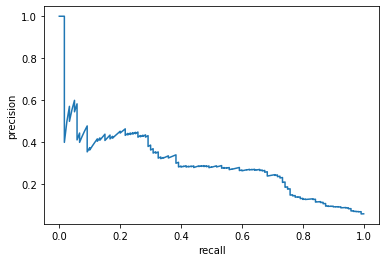

In [95]:
plt.xlabel('recall')
plt.ylabel('precision')

plt.plot(re, pr)

### ROC-AUC

In [96]:
# получаем значения false и true positive rate для различных значений порога
fpr, tpr, thres = roc_curve( Y_test, predictions[:, 1] )

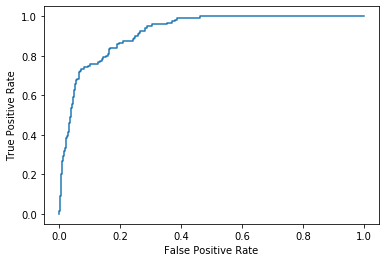

In [97]:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.plot(fpr, tpr)

In [98]:
roc_auc_score(Y_test, predictions[:, 1])

0.9209685349065881

### Итоговый вывод

Модель логистической регрессии на предоставленных данных показывает слабую предсказательную силу, что хорошо видно по характеристике Precision-Recall. Однако, из-за несбалансированности классов (записей в режиме отказа всего 2,5%) характеристики Accuracy и ROC-AUC имеют высокие показатели.

Как улучшить результат:
1. Применить обучение с кросс-валидацией с учетом временной зависимости ряда;
2. Применить ансамблирование.

## Обучение с кросс-валидацией

In [101]:
norm_data

B3_P_C5    B3_P_C6  B3_P_inKVD1  B3_P_inKVD2  B3_PDIT561  B3_PDIT571  \
0      5.168750  13.500001     5.082812    13.240625   26.105747  104.541084   
1      5.159375  13.500001     5.082812    13.240625   26.266880  104.962227   
2      5.148125  13.471874     5.082812    13.214062   26.058136  104.321358   
3      5.136875  13.445312     5.056250    13.187499   25.900665  104.586861   
4      5.148125  13.446875     5.056250    13.187499   26.208286  104.641792   
...         ...        ...          ...          ...         ...         ...   
13953  5.340000  14.207813     5.246875    13.976562   28.892651  102.737473   
13954  5.349375  14.237501     5.257812    14.004688   28.885326  102.545212   
13955  5.351250  14.234374     5.259375    14.000000   28.742504  102.297997   
13956  5.353750  14.242188     5.262500    14.014062   28.599682  102.069115   
13957  5.353750  14.237501     5.259375    14.006249   28.141909  101.538109   

       B3_PIT561  B3_PIT563  B3_PIT571  B3_PIT573  ...  B3_TIT561  B3_TIT571  \
0       5.106489  13.912589  13.340695  22.419147  ...  35.343327  41.644539   
1       5.090353  13.912589  13.340695  22.383900  ...  35.041199  41.598763   
2       5.074903  13.885215  13.314511  22.383900  ...  34.940491  41.642250   
3       5.074903  13.859031  13.288327  22.348648  ...  34.940491  41.740669   
4       5.074903  13.858436  13.288922  22.348648  ...  35.041199  41.939804   
...          ...        ...        ...        ...  ...        ...        ...   
13953   5.269569  14.550537  14.075647  26.208344  ...  38.076218  21.580452   
13954   5.279527  14.577318  14.102427  26.250000  ...  39.184021  21.530098   
13955   5.280900  14.575533  14.098856  26.241190  ...  39.074158  21.569008   
13956   5.282617  14.581484  14.108973  26.248398  ...  39.476997  21.562141   
13957   5.284333  14.574343  14.104212  26.231577  ...  39.568550  21.623940   

       B3_E_BCL   B3_E_Cm  B3_E_MCL  B3_E_Ras1  B3_E_Ras2     B3_evNKVD  y  \
0      0.673587  4.394132  1.696910   2.728573   1.678707  10080.102539  0   
1      0.673587  4.394336  1.697093   2.728573   1.678707  10080.102539  0   
2      0.673815  4.398725  1.699382   2.734113   1.678707  10080.102539  0   
3      0.675830  4.403408  1.699291   2.734113   1.678707  10080.102539  0   
4      0.673815  4.394619  1.697002   2.734113   1.678707  10080.102539  0   
...         ...       ...       ...        ...        ...           ... ..   
13953  0.855825  4.973526  1.728039   2.761238   1.861964   9888.897461  0   
13954  0.855230  4.972360  1.728039   2.761283   1.861382   9888.897461  0   
13955  0.855047  4.969075  1.726848   2.760047   1.861228   9892.110352  0   
13956  0.854223  4.968825  1.727215   2.760277   1.860405   9886.754883  0   
13957  0.853674  4.964028  1.724926   2.758029   1.859840   9887.557617  0   

       ts_interrupting  
0                    1  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
13953                0  
13954                0  
13955                0  
13956                0  
13957                0  

[13958 rows x 26 columns]

In [103]:
Y = norm_data['y']
X = norm_data.drop(['y'], axis=1)

In [110]:
columns = X.columns

In [111]:
sclr = StandardScaler()

In [112]:
sclr.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [114]:
X = sclr.transform(X)
X = pd.DataFrame(X, columns=columns)

In [116]:
logreg = LogisticRegression()

scores = cross_val_score(logreg, X, Y, cv=10)
print(scores)
print('average score: {}'.format(scores.mean()))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

[0.97492837 0.9756447  0.97492837 0.96776504 0.94126074 0.97206304
 0.96633238 0.97421203 0.9734767  0.97491039]
average score: 0.9695521767261301
